# Análisis de Series Temporales
#### Segundo Trabajo Práctico
---
**Alumnos:** Novaresse, Pagani, Edgar  
**Fecha:** 16 de Agosto de 2025  
**Descripción:** Forecast en variables macroeconómicas

# Importaciones Argentinas

## 1. Introducción

Este trabajo práctico analiza la serie temporal **"Importaciones. Total país"**. El objetivo es modelar la serie usando distintas técnicas de Machine Learning, Deep Learning y Modelos Híbridos, comparando su desempeño entre sí y con los modelos SARIMA obtenidos en el trabajo anterior, y por último generar pronósticos en un horizonte temporal determinado. 

La serie de Importaciones totales analizada cubre el período comprendido entre enero de 1990 y febrero de 2025, con una frecuencia mensual, y cada dato representa el total importado expresado en millones de dólares. Puede ser consultada en *datos.gob.ar*, a través del siguiente link: https://datos.gob.ar/series/api/series/?ids=163.3_MTALTAL_0_0_7

Como variable exógena a incorporar en los modelos se utilizará la tasa de devaluación del tipo de cambio USD - peso argentino. La misma puede ser descargada en el siguiente link: https://datos.gob.ar/series/api/series/?ids=92.2_TIPO_CAMBIION_0_0_21_24&collapse=month&collapse_aggregation=avg&representation_mode=percent_change

## 2. Carga e importación de librerías necesarias

In [1]:
# %pip install neuralprophet autots pycaret lightgbm xgboost scikit-learn matplotlib seaborn 

In [474]:
# Importamos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pmdarima as pm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera

from ydata_profiling import ProfileReport

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from matplotlib.patches import Rectangle
from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest

from darts import TimeSeries
from darts.models import NBEATSModel, NHiTSModel, TCNModel
from darts.metrics import mape

from prophet import Prophet
from neuralprophet import NeuralProphet
from xgboost import XGBRegressor

from math import sqrt

import warnings
warnings.filterwarnings('ignore')

----
## 3. Carga y exploración de los datos

In [7]:
# Cargar datasets
df_impos = pd.read_csv('importaciones-clasificadas-nomenclador-comun-mercosur-ncm-2-digitos.csv')
df_deval = pd.read_csv('tasa-devaluacion-tc-oficial.csv')

In [8]:
# Nos quedamos con las columnas de interes
df_impos = df_impos[['indice_tiempo', 'm_total']]

In [9]:
# Renombramos columnas 

df_impos.rename(
    columns={'m_total': 'importaciones_total'},
    inplace=True
)


df_deval.rename(
    columns={'tipo_cambio_valuacion_var_pct': 'tasa_devaluacion'},
    inplace=True
)

df_impos.head(5)

,indice_tiempo,importaciones_total
0,1990-01-01,385.752740
1,1990-02-01,226.159215
2,1990-03-01,302.887158
3,1990-04-01,276.457304
4,1990-05-01,302.133491


In [10]:
df_deval.head(5)

,indice_tiempo,tasa_devaluacion
0,2003-03-01,-0.029436
1,2003-04-01,-0.055238
2,2003-05-01,-0.025040
3,2003-06-01,-0.006224
4,2003-07-01,-0.007809


In [11]:
# Asegurarnos de que 'indice_tiempo' es datetime en ambos df
df_impos['indice_tiempo'] = pd.to_datetime(df_impos['indice_tiempo'])
df_deval['indice_tiempo'] = pd.to_datetime(df_deval['indice_tiempo'])

Merge de ambos dataframes, imponemos que la fecha inicial de ambas series sea 2003-03-01

In [13]:
# Definir la fecha de inicio
fecha_inicio = '2003-03-01'

# Filtrar cada DataFrame para que empiece en marzo de 2003
df_impos_f = df_impos[df_impos['indice_tiempo'] >= fecha_inicio]
df_deval_f = df_deval[df_deval['indice_tiempo'] >= fecha_inicio]

In [14]:
# Merge por la columna de fecha
df_merged = pd.merge(
    df_impos_f,
    df_deval_f,
    on='indice_tiempo',
    how='inner'
)

# Ponemos indice_tiempo en formato Index
df_merged.set_index('indice_tiempo', inplace=True)

In [15]:
# Verificamos
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2003-03-01 to 2025-02-01
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   importaciones_total  264 non-null    float64
 1   tasa_devaluacion     264 non-null    float64
dtypes: float64(2)
memory usage: 6.2 KB
None


In [16]:
df_merged.head()

,importaciones_total,tasa_devaluacion
indice_tiempo,,
2003-03-01,933.671292,-0.029436
2003-04-01,1109.900313,-0.055238
2003-05-01,1085.073495,-0.025040
2003-06-01,1149.080471,-0.006224
2003-07-01,1259.782508,-0.007809


### Profile reporting

In [18]:
# Creamos un df para el EDA automático
df_merged_profile = df_merged.reset_index()

In [19]:
import matplotlib
matplotlib.use('Agg')     # backend “sin cabeza”, sólo render en memoria

In [20]:
# Creamos Reporte 
from ydata_profiling import ProfileReport

profile = ProfileReport(
    df_merged_profile,
    title="EDA Importaciones Totales",
    explorative=True,
    interactions={"continuous": False}  
)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Estadísticas descriptivas

In [22]:
s = df_merged['importaciones_total']

# Describe con percentiles adicionales
percentiles = [0.01, 0.25, 0.5, 0.75, 0.99]
desc = s.describe(percentiles=percentiles)
print(desc)

# Skewness (asimetría) y kurtosis
print(f"Skewness : {s.skew():.4f}")
print(f"Kurtosis : {s.kurtosis():.4f}")

# Coeficiente de variación (std / mean)
cv = s.std() / s.mean()
print(f"Coef. variación: {cv:.4f}")

count     264.000000
mean     4576.661997
std      1575.290685
min       933.671292
1%       1125.756469
25%      3456.519054
50%      4767.053032
75%      5745.500000
99%      7855.130000
max      8664.000000
Name: importaciones_total, dtype: float64
Skewness : -0.2775
Kurtosis : -0.4353
Coef. variación: 0.3442


### Gráficos de las series 

In [24]:
%matplotlib inline

In [25]:
# Creamos una función que grafica automáticamente las series
def graficar(
    df, 
    column, 
    titulo='', 
    xlabel='Año', 
    ylabel='', 
    figsize=(10, 4), 
    usar_leyenda=True, 
    label=None, 
    color=None
):
    ts = df[column]
    plt.figure(figsize=figsize)
    plt.plot(
        ts.index, 
        ts.values, 
        label=label or column, 
        color=color
    )
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if usar_leyenda:
        plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

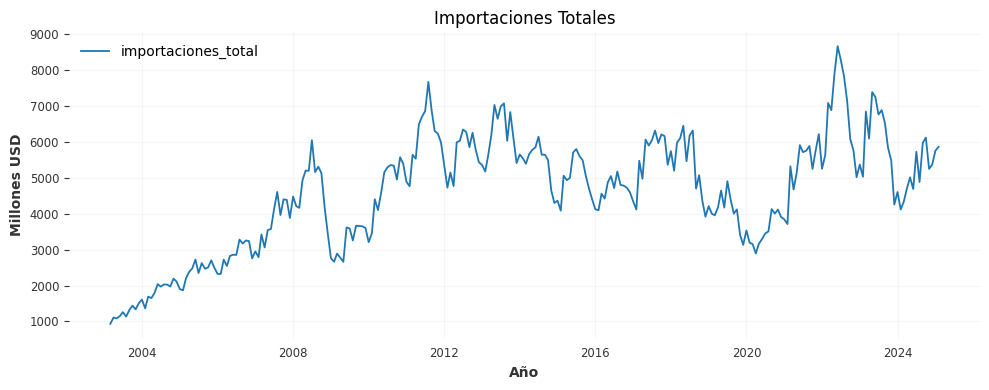

In [26]:
# 1. Gráfico solo de las importaciones
graficar(
    df_merged, 
    'importaciones_total',
    titulo='Importaciones Totales',
    ylabel='Millones USD',
    color='tab:blue'
)

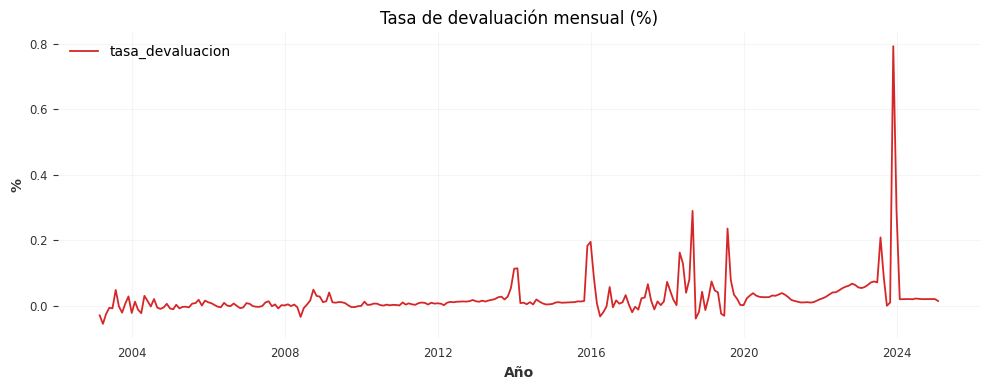

In [27]:
# 2. Gráfico de la tasa de devaluación
graficar(
    df_merged, 
    'tasa_devaluacion',
    titulo='Tasa de devaluación mensual (%)',
    ylabel='%',
    color='tab:red'
)

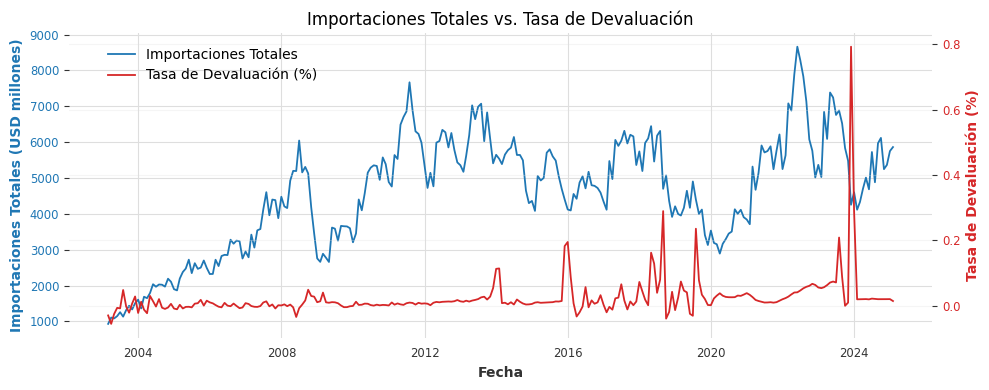

In [28]:
# Gráfico combinado
fig, ax1 = plt.subplots(figsize=(10, 4))

# Eje Y izquierdo: Importaciones Totales
ax1.plot(
    df_merged.index, 
    df_merged['importaciones_total'], 
    color='tab:blue', 
    label='Importaciones Totales'
)
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Importaciones Totales (USD millones)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Eje Y derecho: Tasa de Devaluación
ax2 = ax1.twinx()
ax2.plot(
    df_merged.index, 
    df_merged['tasa_devaluacion'], 
    color='tab:red', 
    label='Tasa de Devaluación (%)'
)
ax2.set_ylabel('Tasa de Devaluación (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Importaciones Totales vs. Tasa de Devaluación')
fig.tight_layout()

# Construimos una leyenda combinada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(
    lines_1 + lines_2, 
    labels_1 + labels_2, 
    loc='upper left',
    bbox_to_anchor=(0.1, 0.9)
)

plt.grid(True, alpha=0.3)
plt.show()

### Descomposición de la serie en sus componentes

##### Additive

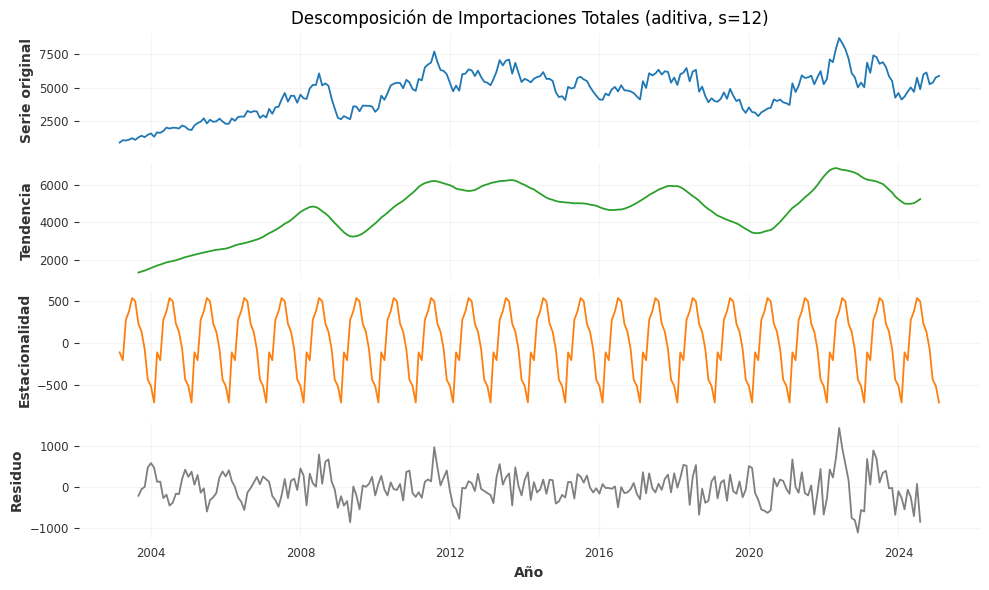

In [31]:
# Descomposición aditiva de Importaciones Totales (periodo = 12 meses)
decomp_imp = seasonal_decompose(
    df_merged['importaciones_total'], 
    model='additive', 
    period=12
)

# Configurar figura con 4 subplots (observada, tendencia, estacional, residuo)
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

componentes = ['observed', 'trend', 'seasonal', 'resid']
titulos     = ['Serie original', 'Tendencia', 'Estacionalidad', 'Residuo']
colores     = ['tab:blue',    'tab:green', 'tab:orange',      'tab:gray']

for i, (comp, titulo, color) in enumerate(zip(componentes, titulos, colores)):
    serie = getattr(decomp_imp, comp)
    axes[i].plot(serie, color=color)
    axes[i].set_ylabel(titulo, fontsize=10)
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].set_title('Descomposición de Importaciones Totales (aditiva, s=12)', fontsize=12)

# Etiqueta común para el eje X
axes[-1].set_xlabel('Año')

plt.tight_layout()
plt.show()

##### Multiplicative

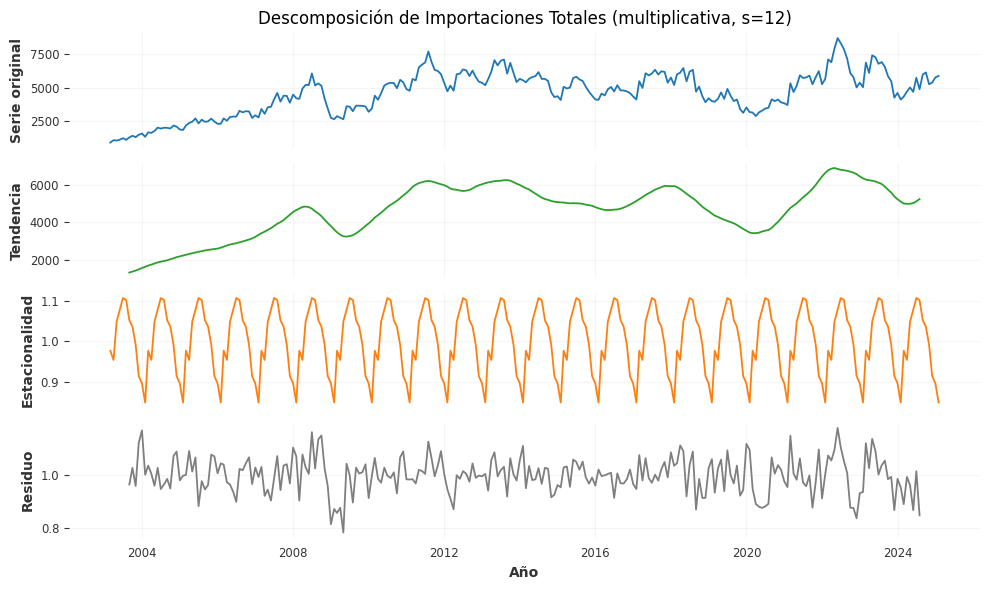

In [33]:
# Descomposición aditiva de Importaciones Totales (periodo = 12 meses)
decomp_imp = seasonal_decompose(
    df_merged['importaciones_total'], 
    model='multiplicative', 
    period=12
)

# Configurar figura con 4 subplots (observada, tendencia, estacional, residuo)
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

componentes = ['observed', 'trend', 'seasonal', 'resid']
titulos     = ['Serie original', 'Tendencia', 'Estacionalidad', 'Residuo']
colores     = ['tab:blue',    'tab:green', 'tab:orange',      'tab:gray']

for i, (comp, titulo, color) in enumerate(zip(componentes, titulos, colores)):
    serie = getattr(decomp_imp, comp)
    axes[i].plot(serie, color=color)
    axes[i].set_ylabel(titulo, fontsize=10)
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].set_title('Descomposición de Importaciones Totales (multiplicativa, s=12)', fontsize=12)

# Etiqueta común para el eje X
axes[-1].set_xlabel('Año')

plt.tight_layout()
plt.show()

### Análisis de Outliers

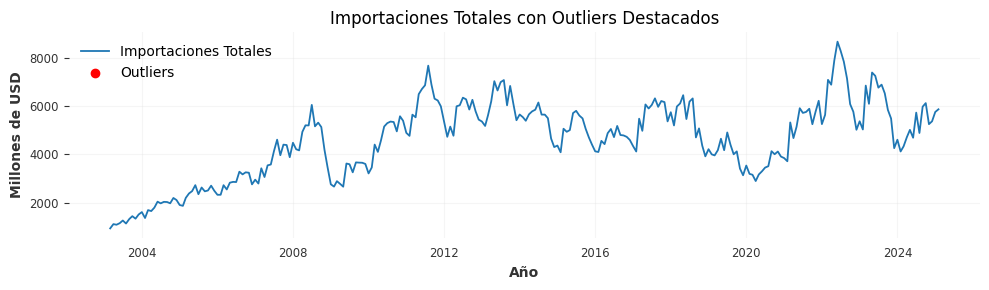

In [35]:
# 1) Calculamos los umbrales IQR sobre importaciones_total
Q1 = df_merged['importaciones_total'].quantile(0.25)
Q3 = df_merged['importaciones_total'].quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# 2) Detectamos outliers
mask_outliers = (
    (df_merged['importaciones_total'] < limite_inf) |
    (df_merged['importaciones_total'] > limite_sup)
)

# 3) Gráfico
plt.figure(figsize=(10, 3))
# Serie completa
plt.plot(
    df_merged.index,
    df_merged['importaciones_total'],
    label='Importaciones Totales',
    color='tab:blue'
)
# Puntos outliers
plt.scatter(
    df_merged.index[mask_outliers],
    df_merged.loc[mask_outliers, 'importaciones_total'],
    color='red',
    label='Outliers',
    zorder=5
)

plt.title('Importaciones Totales con Outliers Destacados')
plt.xlabel('Año')
plt.ylabel('Millones de USD')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

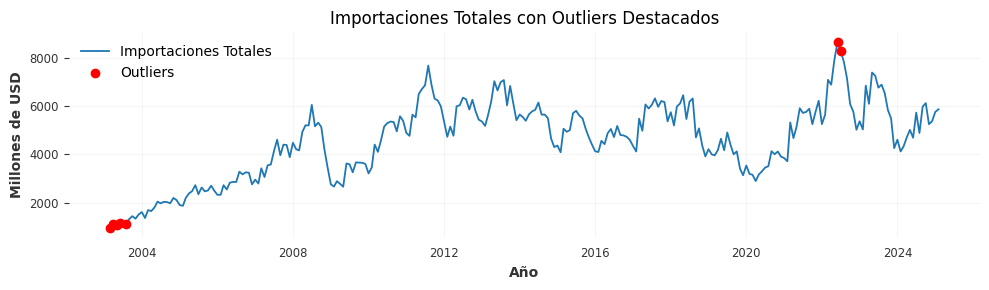

In [36]:
# Cambiamos el umbral para que sea k=1
Q1 = df_merged['importaciones_total'].quantile(0.25)
Q3 = df_merged['importaciones_total'].quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1 * IQR
limite_sup = Q3 + 1* IQR

# 2) Detectamos outliers
mask_outliers = (
    (df_merged['importaciones_total'] < limite_inf) |
    (df_merged['importaciones_total'] > limite_sup)
)

# 3) Gráfico
plt.figure(figsize=(10, 3))
# Serie completa
plt.plot(
    df_merged.index,
    df_merged['importaciones_total'],
    label='Importaciones Totales',
    color='tab:blue'
)
# Puntos outliers
plt.scatter(
    df_merged.index[mask_outliers],
    df_merged.loc[mask_outliers, 'importaciones_total'],
    color='red',
    label='Outliers',
    zorder=5
)

plt.title('Importaciones Totales con Outliers Destacados')
plt.xlabel('Año')
plt.ylabel('Millones de USD')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Correlación cruzada de variables

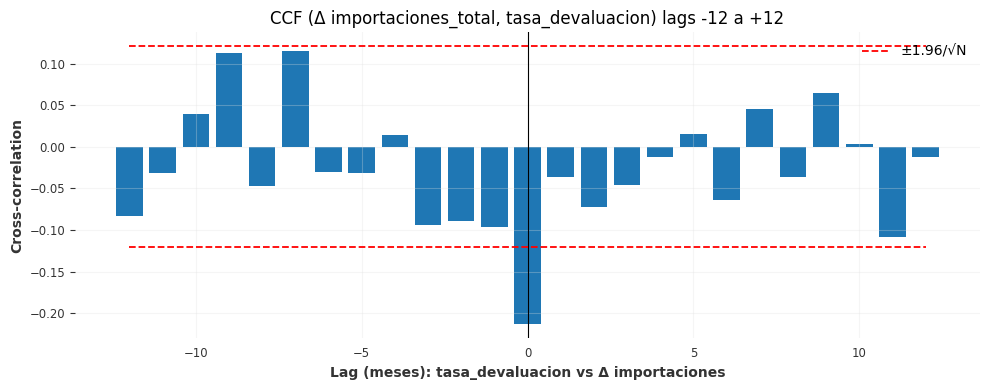

In [38]:
# 1) Diferenciar importaciones (serie no estacionaria)
imp_diff = df_merged['importaciones_total'].diff().dropna()

# 2) Tomar la serie de devaluación sin cambios (ya estacionaria)
dev = df_merged['tasa_devaluacion'].dropna()

# 3) Alinear ambas series por índice
imp_diff, dev = imp_diff.align(dev, join='inner')

# 4) Calcular cross‐correlations para lags -12…+12
max_lag = 12
lags = np.arange(-max_lag, max_lag + 1)
corrs = [imp_diff.corr(dev.shift(lag)) for lag in lags]

# 5) Calcular banda de confianza aproximada (95%): ±1.96/√N
N = len(imp_diff)  # # de observaciones tras diff+align
conf_band = 1.96 / np.sqrt(N)

# 6) Graficar
plt.figure(figsize=(10, 4))
plt.bar(lags, corrs, color='tab:blue')
plt.axvline(0, color='black', linewidth=0.8)

# Añadir bandas de confianza
plt.hlines([conf_band, -conf_band],
           xmin=lags.min(), xmax=lags.max(),
           colors='red', linestyles='--', label='±1.96/√N')

plt.xlabel('Lag (meses): tasa_devaluacion vs Δ importaciones')
plt.ylabel('Cross‐correlation')
plt.title('CCF (Δ importaciones_total, tasa_devaluacion) lags -12 a +12')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- En lag = 0 la CCF es de aproximadamente –0.22, lo cual indica que un aumento en la tasa de devaluación en el mismo mes tiende asociarse con una caída en las importaciones (Δ importaciones).
- Esta correlación, además de ser la más grande, es estadísticamente significativa ya que supera las bandas de confianza. 



-----
## 4. Modelos

Emplearemos una estrategia de validación basada en **TimeSeriesSplit (Cross Validation Time Series)** porque, a diferencia de un simple particionado aleatorio “train/test”, esta metodología respeta la estructura cronológica de los datos y evita el problema de data leakage, es decir, que información futura contamine la fase de entrenamiento. Al generar pliegues crecientes donde cada iteración entrena sobre todos los meses previos y valida sobre un bloque posterior (por ejemplo, 12 meses), simulamos de manera fiel el escenario de producción “mes a mes” en el que un modelo entrenado hasta el mes t debe predecir el mes t+1. Esto nos permite evaluar de forma más robusta la estabilidad y capacidad de generalización de cada algoritmo (XGBoost, LightGBM, ANN, RNN, SARIMA, Prophet, etc.), comparar objetivamente sus performances y ajustar hiperparámetros con metodologías como grid‐search sin incurrir en sesgos.
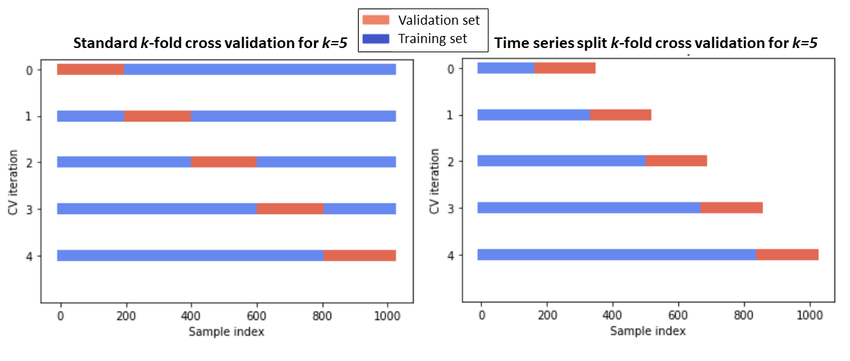

> ## 1. Modelo "base": SARIMA-X

Utilizaremos el modelo SARIMA-X con la tasa de devaluación como regresora exógena como benchmark frente al cual compararemos nuestros algoritmos de machine learning. SARIMA-X, al ser un método estadístico clásico, aporta un enfoque parsimonioso y fácilmente interpretable: describe explícitamente la dinámica autoregresiva, la estacionalidad y el impacto lineal de la tasa de devaluación sobre las importaciones. Sin embargo, su estructura lineal y rígida limita su capacidad para captar efectos no lineales, interacciones complejas y patrones de alta dimensión. Por ello, nuestra estrategia consiste en sacrificar voluntariamente parte de la explicabilidad y la simplicidad de los modelos tradicionales, asumiendo una mayor complejidad en modelos como redes neuronales (ANN, NNAR, RNN) o ensambladores (XGBoost, LightGBM, Prophet) con el fin de extraer relaciones más ricas y lograr pronósticos superiores. De este modo, el desempeño de SARIMA-X servirá como punto de referencia objetivo para cuantificar la mejora en precisión que aportan las técnicas de aprendizaje automático.

In [44]:
y_full = df_merged['importaciones_total']
exog_full = df_merged['tasa_devaluacion']

In [101]:
# Encuentra (p,d,q)(P,D,Q,12) con auto_arima sobre la serie ORIGINAL, le pedimos al algoritmo que aplique la diferencia
auto = pm.auto_arima(
    y            = y_full,
    exogenous    = exog_full,
    start_p      = 0, max_p      = 3,
    start_q      = 0, max_q      = 3,
    d            = 1,              # que SARIMA internamente haga la diff
    seasonal     = True,
    m            = 12,
    start_P      = 0, max_P      = 3,
    start_Q      = 0, max_Q      = 3,
    D            = 1,
    trace        = True,
    error_action      = 'ignore',
    suppress_warnings = True,
    stepwise     = True,
    information_criterion = 'bic'   # o 'aic'
)
print("Órdenes seleccionados:", auto.order, auto.seasonal_order)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=3874.672, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=3857.233, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=3860.407, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : BIC=3830.630, Time=0.54 sec
 ARIMA(1,1,0)(3,1,0)[12]             : BIC=3800.637, Time=1.21 sec
 ARIMA(1,1,0)(3,1,1)[12]             : BIC=3762.099, Time=5.45 sec
 ARIMA(1,1,0)(2,1,1)[12]             : BIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(3,1,2)[12]             : BIC=3764.278, Time=5.78 sec
 ARIMA(1,1,0)(2,1,2)[12]             : BIC=3763.345, Time=3.42 sec
 ARIMA(0,1,0)(3,1,1)[12]             : BIC=3772.744, Time=2.93 sec
 ARIMA(2,1,0)(3,1,1)[12]             : BIC=3767.571, Time=4.48 sec
 ARIMA(1,1,1)(3,1,1)[12]             : BIC=3767.610, Time=4.19 sec
 ARIMA(0,1,1)(3,1,1)[12]             : BIC=3764.905, Time=4.94 sec
 ARIMA(2,1,1)(3,1,1)[12]     

In [103]:
# Validación con TimeSeriesSplit 

# Función de MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Validación con TimeSeriesSplit y MAPE en niveles
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
mape_scores = []
rmse_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(y_full), 1):
    # split
    y_train  = y_full.iloc[train_idx]
    exog_train = exog_full.iloc[train_idx]
    y_test   = y_full.iloc[test_idx]
    exog_test  = exog_full.iloc[test_idx]

    # ajusto SARIMAX con los órdenes fijos
    model = SARIMAX(
        endog = y_train,
        exog  = exog_train,
        order = auto.order,
        seasonal_order = auto.seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # pronóstico niveles para los próximos len(test_idx) meses
    y_pred = model.forecast(steps=len(test_idx), exog=exog_test)

    # métricas en escala original
    m = mape(y_test, y_pred)
    r = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_scores.append(m)
    rmse_scores.append(r)

    print(f"Fold {fold} → MAPE = {m:.2f}%,  RMSE = {r:.2f}")

Fold 1 → MAPE = 16.59%,  RMSE = 630.70
Fold 2 → MAPE = 13.47%,  RMSE = 825.78
Fold 3 → MAPE = 11.92%,  RMSE = 841.56
Fold 4 → MAPE = 9.45%,  RMSE = 677.90
Fold 5 → MAPE = 15.51%,  RMSE = 1097.26


In [104]:
# Métricas promedio del modelo SARIMA-X
print(f"\nMAPE promedio: {np.mean(mape_scores):.2f}%")
print(f"RMSE promedio: {np.mean(rmse_scores):.2f}")


MAPE promedio: 13.39%
RMSE promedio: 814.64


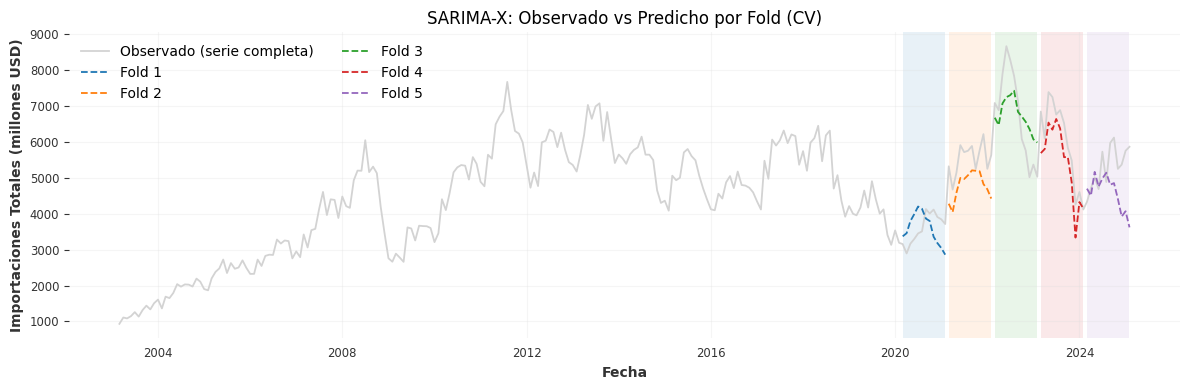

In [105]:
# Gráfico de observado vs predicho sobre el conjunto de validación sobre cada fold

# TimeSeriesSplit
colors = plt.get_cmap('tab10').colors

# Prepara figura
fig, ax = plt.subplots(figsize=(12,4))
# Serie observada completa en gris claro
ax.plot(y_full.index, y_full, color='lightgray', label='Observado (serie completa)')

# Recorre cada fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(y_full), start=1):
    # Partición
    y_train    = y_full.iloc[train_idx]
    exog_train = exog_full.iloc[train_idx]
    exog_test  = exog_full.iloc[test_idx]
    idx_test   = y_full.index[test_idx]

    # Ajusta SARIMA-X con tus órdenes
    model = SARIMAX(
        endog            = y_train,
        exog             = exog_train,
        order            = auto.order,
        seasonal_order   = auto.seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Pronóstico sobre el block de test
    y_pred = model.forecast(
        steps=len(test_idx),
        exog = exog_test
    )
    
    # Color y sombreado
    c = colors[(fold-1) % len(colors)]
    ax.axvspan(idx_test[0], idx_test[-1], facecolor=c, alpha=0.1)
    ax.plot(idx_test, y_pred, linestyle='--', color=c, label=f'Fold {fold}')

# Ajustes finales
ax.set_title('SARIMA-X: Observado vs Predicho por Fold (CV)', fontsize=12)
ax.set_xlabel('Fecha')
ax.set_ylabel('Importaciones Totales (millones USD)')
ax.legend(loc='upper left', ncol=2, fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [106]:
# Ajuste final sobre la serie completa y resultados de la regresión
final_model = SARIMAX(
    endog=df_merged['importaciones_total'],
    exog=df_merged['tasa_devaluacion'],
    order=auto.order,
    seasonal_order=auto.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Imprimir el resumen
print(final_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                  importaciones_total   No. Observations:                  264
Model:             SARIMAX(1, 1, 0)x(3, 1, [1], 12)   Log Likelihood               -1595.920
Date:                              Sat, 09 Aug 2025   AIC                           3205.841
Time:                                      19:16:17   BIC                           3229.403
Sample:                                  03-01-2003   HQIC                          3215.362
                                       - 02-01-2025                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
tasa_devaluacion  -615.2226    444.873     -1.383      0.167   -1487.158     256.712
a

En las siguientes etapas exploraremos modelos de machine learning (XGBoost, LightGBM, ANN, RNN, Prophet, etc.) que, a costa de renunciar algo de parsimonia y explicabilidad, podrían capturar relaciones no lineales y mejorar aún más la calidad de los pronósticos.

----
> ## 2. Modelo *Artificial Neural Network*

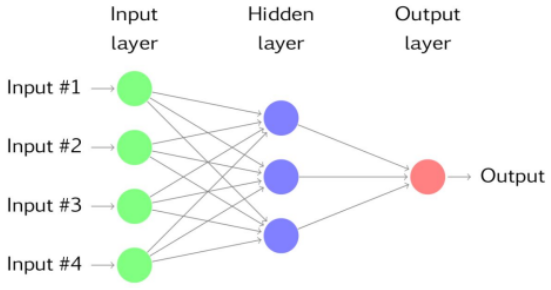

### Feature engineering 

In [111]:
# Primero debemos preparar el dataset para el modelo
# Creamos una serie de columnas derivadas que van a funcionar como input adicional al modelo (features)
# Partimos de df_merged que debe tener índice datetime y columnas:
# 'importaciones_total' y 'tasa_devaluacion'
df_feat = df_merged.copy()

In [112]:
# Imponemos que la columna indice_tiempo sea un time index
if 'indice_tiempo' in df_feat.columns:
    df_feat['indice_tiempo'] = pd.to_datetime(df_feat['indice_tiempo'])
    df_feat.set_index('indice_tiempo', inplace=True)

df_feat.head(5)

,importaciones_total,tasa_devaluacion
indice_tiempo,,
2003-03-01,933.671292,-0.029436
2003-04-01,1109.900313,-0.055238
2003-05-01,1085.073495,-0.025040
2003-06-01,1149.080471,-0.006224
2003-07-01,1259.782508,-0.007809


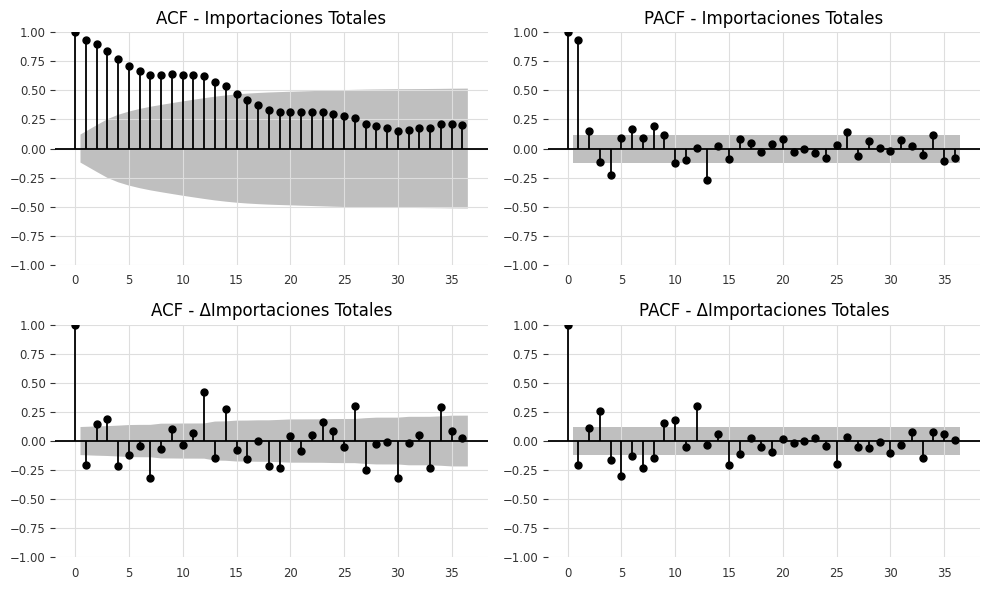

In [113]:
# Ploteamos ACF y PACF de la serie original, para determinar que lags podrían llegar a ser significativos 
# De esa manera los incluímos en el proceso de feature engineering

# Serie original de importaciones
series = df_merged['importaciones_total']
# Primera diferencia
series_diff = series.diff().dropna()

# Número de lags a mostrar
max_lags = 36

# Creamos la figura con 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# ACF y PACF de la serie original
plot_acf(series, lags=max_lags, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Importaciones Totales')
plot_pacf(series, lags=max_lags, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Importaciones Totales')

# ACF y PACF de la serie diferenciada
plot_acf(series_diff, lags=max_lags, ax=axes[1, 0])
axes[1, 0].set_title('ACF - ΔImportaciones Totales')
plot_pacf(series_diff, lags=max_lags, ax=axes[1, 1])
axes[1, 1].set_title('PACF - ΔImportaciones Totales')

plt.tight_layout()
plt.show()

In [114]:
# Feature engineering 

# 1) LAGS
# Lags de importaciones: 1…6 que sería el componente "autorregresivo"
for lag in range(1, 7):
    df_feat[f'imp_lag{lag}'] = df_feat['importaciones_total'].shift(lag)

# Lags de tasa_devaluacion: 1…3
for lag in range(1, 4):
    df_feat[f'dev_lag{lag}'] = df_feat['tasa_devaluacion'].shift(lag)

# Eliminar filas con NA creadas por los shifts 
df_feat.dropna(inplace=True)

In [115]:
df_feat.head(5)

,importaciones_total,tasa_devaluacion,imp_lag1,imp_lag2,imp_lag3,imp_lag4,imp_lag5,imp_lag6,dev_lag1,dev_lag2,dev_lag3
indice_tiempo,,,,,,,,,,,
2003-09-01,1318.223550,-0.002250,1135.068814,1259.782508,1149.080471,1085.073495,1109.900313,933.671292,0.048438,-0.007809,-0.006224
2003-10-01,1439.599106,-0.021001,1318.223550,1135.068814,1259.782508,1149.080471,1085.073495,1109.900313,-0.002250,0.048438,-0.007809
2003-11-01,1336.225802,0.007086,1439.599106,1318.223550,1135.068814,1259.782508,1149.080471,1085.073495,-0.021001,-0.002250,0.048438
2003-12-01,1508.286436,0.028566,1336.225802,1439.599106,1318.223550,1135.068814,1259.782508,1149.080471,0.007086,-0.021001,-0.002250
2004-01-01,1608.575067,-0.021838,1508.286436,1336.225802,1439.599106,1318.223550,1135.068814,1259.782508,0.028566,0.007086,-0.021001


In [116]:
# 2) Agregar estadísticas móviles (rolling mean y std) para importaciones y tasa_devaluacion
for window in [3, 6]:
    df_feat[f'imp_ma{window}']  = df_feat['importaciones_total'].shift(1).rolling(window).mean()
    df_feat[f'imp_std{window}'] = df_feat['importaciones_total'].shift(1).rolling(window).std()
    df_feat[f'dev_ma{window}']  = df_feat['tasa_devaluacion'].shift(1).rolling(window).mean()

##### Rolling window
El shift(1) es para no incluir la propia variable target en el momento t, dentro de las variables features. Sino, estaría -de una manera indirecta, porque esta incluída en esta ventana de media móvil- y(t) explicando a y(t).

In [169]:
# 3) Variables de calendario (mes, cuatrimestre)
df_feat['month']   = df_feat.index.month
df_feat['quarter'] = df_feat.index.quarter
df_feat['trimester'] = ((df_feat.index.month - 1) // 4) + 1  # 1: Jan–Apr, 2: May–Aug, 3: Sep–Dec

In [171]:
# Eliminar filas con NA generadas por rolling y calendarios
df_feat.dropna(inplace=True)
df_feat.head(5)

,importaciones_total,tasa_devaluacion,imp_lag1,imp_lag2,imp_lag3,imp_lag4,imp_lag5,imp_lag6,dev_lag1,dev_lag2,dev_lag3,imp_ma3,imp_std3,dev_ma3,imp_ma6,imp_std6,dev_ma6,month,quarter,trimester
indice_tiempo,,,,,,,,,,,,,,,,,,,,
2004-03-01,1690.058163,-0.011801,1363.731431,1608.575067,1508.286436,1336.225802,1439.599106,1318.223550,0.012512,-0.021838,0.028566,1493.530978,123.086937,0.006413,1429.106899,112.946249,0.000513,3,1,1
2004-04-01,1650.876869,-0.022655,1690.058163,1363.731431,1608.575067,1508.286436,1336.225802,1439.599106,-0.011801,0.012512,-0.021838,1554.121554,169.841611,-0.007042,1491.079334,138.954111,-0.001079,4,2,1
2004-05-01,1792.157340,0.030383,1650.876869,1690.058163,1363.731431,1608.575067,1508.286436,1336.225802,-0.022655,-0.011801,0.012512,1568.222154,178.174452,-0.007315,1526.292295,149.657307,-0.001355,5,2,2
2004-06-01,2039.339799,0.014145,1792.157340,1650.876869,1690.058163,1363.731431,1608.575067,1508.286436,0.030383,-0.022655,-0.011801,1711.030791,72.937859,-0.001358,1602.280884,149.599401,0.002528,6,2,2
2004-07-01,1969.827469,-0.002310,2039.339799,1792.157340,1650.876869,1690.058163,1363.731431,1608.575067,0.014145,0.030383,-0.022655,1827.458003,196.622645,0.007291,1690.789778,222.298221,0.000124,7,3,2


In [173]:
# Actualizamos la lista de features para el modelo ANN
features = [
    col for col in df_feat.columns 
    if col not in ['importaciones_total']
]

# Verificamos
print("Número de observaciones tras FE:", len(df_feat))
print("Features:", features)
print("Cantidad de features creados:", len(features)-1)

Número de observaciones tras FE: 252
Features: ['tasa_devaluacion', 'imp_lag1', 'imp_lag2', 'imp_lag3', 'imp_lag4', 'imp_lag5', 'imp_lag6', 'dev_lag1', 'dev_lag2', 'dev_lag3', 'imp_ma3', 'imp_std3', 'dev_ma3', 'imp_ma6', 'imp_std6', 'dev_ma6', 'month', 'quarter', 'trimester']
Cantidad de features creados: 18


Este feature engineering será utilizado para otros algoritmos de machine learning, no solo para el MLPRegressor

#### Modelado

In [175]:
# Monkey-patch: `MLPRegressor._validate_data` usando `check_X_y` / `check_array`
from sklearn.neural_network import MLPRegressor
from sklearn.utils.validation import check_array, check_X_y

def _validate_data(self, X, y=None, reset=True, **kwargs):
    """
    Parche mínimo para que MLPRegressor._validate_data haga solo lo esencial:
    - si y es None, valida X con check_array
    - si y no es None, valida X,y con check_X_y
    Ignora todos los demás kwargs (incluido 'reset').
    """
    if y is None:
        return check_array(X)
    return check_X_y(X, y)

MLPRegressor._validate_data = _validate_data

In [176]:
# Definimos features y variable objetivo
X = df_feat[features]                  # pandas.DataFrame
y = df_feat['importaciones_total']     # pandas.Series

In [177]:
# Configuramos TimeSeriesSplit al igual que con SARIMAX, n_splits =5 y test_size = 12
tscv = TimeSeriesSplit(n_splits=5, test_size=12)

In [347]:
# Definimos el modelo y unos hiperparámetros base
ann_params = dict(
    hidden_layer_sizes   = (100,), # 100 neuronas en la capa oculta 
    activation           = 'relu', # función de activación
    solver               = 'adam',
    alpha                = 1e-2,
    learning_rate_init   = 1e-1, # learning rate
    max_iter             = 1000, # hasta 1000 epochs 
    early_stopping       = False,
    validation_fraction  = 0.2, # se queda un 20% para validación en cada epoch
    random_state         = 123
)

In [336]:
# Bucle manual de validación Time Series CV
rmse_scores = []
mape_scores = []

# Loop fold‐a‐fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    # a) split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # b) escalado
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    
    # c) entrenar
    mlp = MLPRegressor(**ann_params)
    mlp.fit(X_train_s, y_train)
    
    # d) predecir + métricas
    y_pred = mlp.predict(X_test_s)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print(f"Fold {fold} → RMSE = {rmse:.2f}, MAPE = {mape:.2f}%")
    rmse_scores.append(rmse)
    mape_scores.append(mape)

print(f"\nRMSE promedio  = {np.mean(rmse_scores):.2f}")
print(f"MAPE promedio = {np.mean(mape_scores):.2f}%")

Fold 1 → RMSE = 442.15, MAPE = 10.06%
Fold 2 → RMSE = 749.35, MAPE = 10.88%
Fold 3 → RMSE = 590.70, MAPE = 6.89%
Fold 4 → RMSE = 1774.89, MAPE = 23.62%
Fold 5 → RMSE = 1246.33, MAPE = 16.82%

RMSE promedio  = 960.69
MAPE promedio = 13.66%


In [180]:
print(f"\nRMSE promedio  = {np.mean(rmse_scores):.2f}")
print(f"MAPE promedio = {np.mean(mape_scores):.2f}%")


RMSE promedio  = 960.69
MAPE promedio = 13.66%


##### Grid search para optimizar hiperparámetros

In [374]:
# --- scorers ---
rmse_scorer = 'neg_root_mean_squared_error'
def mape_fn(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100
mape_scorer = make_scorer(mape_fn, greater_is_better=False)

# --- pipeline (alineado con tu setup manual) ---
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(100,),
        activation='relu',
        solver='adam',
        learning_rate='constant',
        learning_rate_init=1e-1,
        alpha=1e-2,
        max_iter=1000,
        early_stopping=False,
        shuffle=True,           
        random_state=123
    ))
])

# --- grid alrededor de tu configuración ---
param_grid = {
    'mlp__hidden_layer_sizes': [(75,), (100,), (125,), (150,)],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [5e-3, 1e-2, 2e-2],
    'mlp__learning_rate': ['constant'],
    'mlp__learning_rate_init': [1e-1, 7e-2, 5e-2, 3e-2],
    'mlp__shuffle': [True],    
}

gsearch_mlp = GridSearchCV(
    estimator=pipe_mlp,
    param_grid=param_grid,
    cv=tscv,                                   # TimeSeriesSplit(n_splits=5, test_size=12)
    scoring={'rmse': rmse_scorer, 'mape': mape_scorer},
    refit='mape',                              
    n_jobs=-1,
    verbose=2
)

gsearch_mlp.fit(X, y)

print("Mejores hiperparámetros por MAPE:", gsearch_mlp.best_params_)

# Resumen RMSE/MAPE del ganador por MAPE
cv_res = pd.DataFrame(gsearch_mlp.cv_results_)
row_best_mape = cv_res.loc[cv_res['rank_test_mape'] == 1].iloc[0]
best_mape = -row_best_mape['mean_test_mape']
best_rmse = -row_best_mape['mean_test_rmse']
print(f"→ MAPE (CV) = {best_mape:.3f}% | RMSE (CV) = {best_rmse:.3f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros por MAPE: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (125,), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.1, 'mlp__shuffle': True, 'mlp__solver': 'adam'}
→ MAPE (CV) = 13.030% | RMSE (CV) = 910.366


No hay una mejora considerable en el resultado del modelo

In [383]:
# Revalidación fold-a-fold con los mejores hiperparámetros (por MAPE)
ann_best_params = gsearch_mlp.best_estimator_.named_steps['mlp'].get_params(deep=False)
ann_best_params.update({'early_stopping': False, 'shuffle': True, 'random_state': 123})

rmse_scores_mlp, mape_scores_mlp = [], []
fold_preds_mlp = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    # a) split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # b) escalado
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # c) entrenar
    mlp = MLPRegressor(**ann_best_params)
    mlp.fit(X_train_s, y_train)

    # d) predecir + métricas
    y_pred = mlp.predict(X_test_s)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"Fold {fold} → RMSE = {rmse:.2f}, MAPE = {mape:.2f}%")
    rmse_scores_mlp.append(rmse)
    mape_scores_mlp.append(mape)

    # guardar para gráfico (índice temporal del test)
    idx_test = df_feat.index[test_idx]
    fold_preds_mlp.append((fold, idx_test, y_test, y_pred))

print(f"\nRMSE promedio (MLP) = {np.mean(rmse_scores_mlp):.2f}")
print(f"MAPE promedio (MLP) = {np.mean(mape_scores_mlp):.2f}%")


Fold 1 → RMSE = 436.61, MAPE = 9.91%
Fold 2 → RMSE = 624.35, MAPE = 8.86%
Fold 3 → RMSE = 612.90, MAPE = 7.62%
Fold 4 → RMSE = 1828.93, MAPE = 23.94%
Fold 5 → RMSE = 1049.04, MAPE = 14.82%

RMSE promedio (MLP) = 910.37
MAPE promedio (MLP) = 13.03%


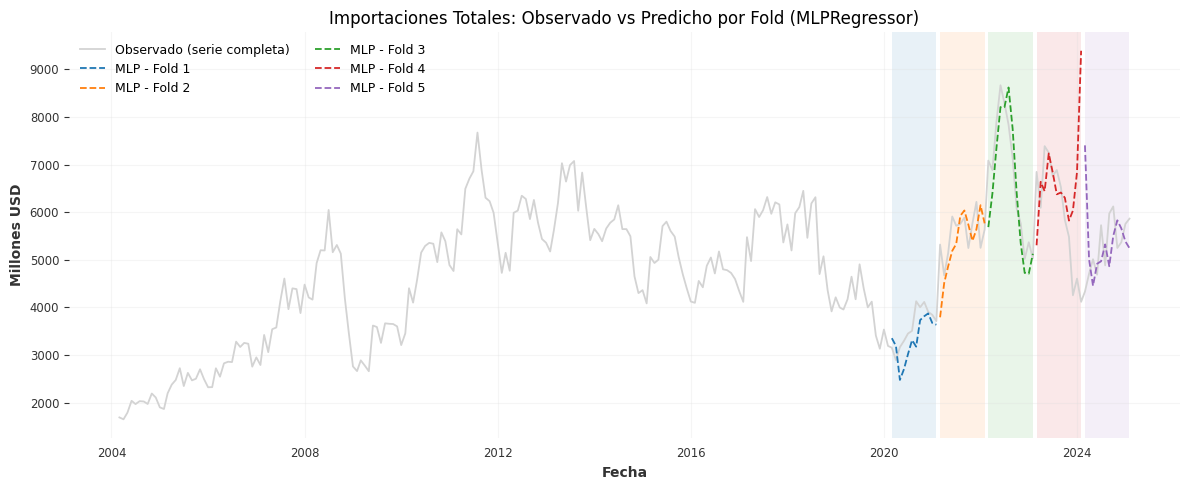

In [385]:
fig, ax = plt.subplots(figsize=(12,5))

# Observado completo en gris
ax.plot(df_feat.index, y, color='lightgray', label='Observado (serie completa)')

# Predicciones por fold con sombreado
for fold, idx_test, y_true_fold, y_pred_fold in fold_preds_mlp:
    color = colors[(fold-1) % len(colors)]
    start, end = idx_test[0], idx_test[-1]
    ax.axvspan(start, end, facecolor=color, alpha=0.1)
    ax.plot(idx_test, y_pred_fold, color=color, linestyle='--',
            label=f'MLP - Fold {fold}')

ax.set_title('Importaciones Totales: Observado vs Predicho por Fold (MLPRegressor)', fontsize=12)
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones USD')
ax.legend(loc='upper left', ncol=2, fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

El ajuste parece muy bueno, pero quedó un salto extraño ahí

##### "Importancia" de las variables
El Permutation Importance  es una técnica model-agnostic (funciona con cualquier estimador) que mide, para cada variable, cuánto empeora (aumenta) el RMSE cuando se “rompe” la relación entre esa variable y el target. El procedimiento que realiza el siguiente: 
1. Calculo un RMSE base con todas las variables intactas.
2. Para cada variable en turnos:
- Barajo al azar sus valores en todo el dataset, manteniendo fijas el resto.
- Vuelvo a predecir y mido el nuevo RMSE.
3. Registro la diferencia media (RMSE_permutado – RMSE_base) sobre varias repeticiones.

Cuanto mayor es esa diferencia media, más “importancia” tenía la variable original: al desordenarla, la predicción empeora mucho.

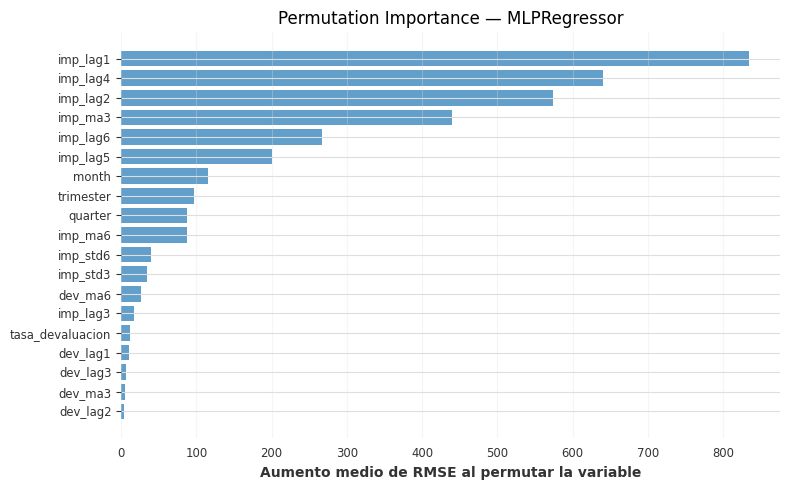

In [377]:
# Definir y entrenar el modelo final sobre TODO el df_feat
pipe_final = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(200,),
        activation='relu',
        solver='adam',
        alpha=1e-3,
        learning_rate_init=1e-2,
        max_iter=3000,
        early_stopping=False,
        random_state=123
    ))
])

X = df_feat[features]
y = df_feat['importaciones_total']
pipe_final.fit(X, y)

# Métrica base en todo el set
y_pred_base = pipe_final.predict(X)
rmse_base = np.sqrt(mean_squared_error(y, y_pred_base))

# Función para calcular el RMSE tras permutar una columna
def permute_rmse(col, n_repeat=10):
    r = []
    X_perm = X.copy()
    for _ in range(n_repeat):
        X_perm[col] = np.random.permutation(X_perm[col].values)
        y_pred = pipe_final.predict(X_perm)
        r.append(np.sqrt(mean_squared_error(y, y_pred)))
    return np.mean(r) - rmse_base  # cuánto sube el RMSE

# Calculamos la importancia para cada feature
importances = {col: permute_rmse(col, n_repeat=10) for col in features}
imp_series = pd.Series(importances).sort_values(ascending=False)

# Graficar
plt.figure(figsize=(8,5))
plt.barh(imp_series.index, imp_series.values, color='tab:blue', alpha=0.7)
plt.gca().invert_yaxis()
plt.xlabel("Aumento medio de RMSE al permutar la variable")
plt.title("Permutation Importance — MLPRegressor")
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Agregamos más hidden layers

In [579]:
# --- Métricas / scorers ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, dtype=float), np.asarray(y_pred, dtype=float)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse_scorer = make_scorer(rmse, greater_is_better=False)   # negativo para minimizar
mape_scorer = make_scorer(mape, greater_is_better=False)

In [581]:
# --- CV temporal ---
tscv = TimeSeriesSplit(n_splits=5, test_size=12)

In [ ]:
# --- Pipeline base ---
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        max_iter=1000,
        early_stopping=True,       # solo aplica con 'adam'
        validation_fraction=0.2,
        n_iter_no_change=20,
        shuffle=False,             # clave en series temporales
        random_state=123
    ))
])

In [589]:
# --- Grid search ---
param_grid = [
    # Bloque ADAM (usa early_stopping & learning_rate_init)
    {
        'mlp__solver': ['adam'],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__hidden_layer_sizes': [
            (32,), (64,), (32, 16), (64, 16), (32, 16, 8)
        ],
        'mlp__alpha': [5e-3, 1e-2, 3e-2],
        'mlp__learning_rate_init': [1e-3, 3e-3],
        'mlp__batch_size': [32],
    },
    # Bloque LBFGS (ignora learning rate y batch; no early_stopping)
    {
        'mlp__solver': ['lbfgs'],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__hidden_layer_sizes': [
            (32,), (32, 16)
        ],
        'mlp__alpha': [1e-3, 1e-2, 3e-2],
        # NOTA: no poner learning_rate_init ni batch_size aquí
    }
]

gsearch_mlp = GridSearchCV(
    estimator=pipe_mlp,
    param_grid=param_grid,
    cv=tscv,
    scoring={'rmse': rmse_scorer, 'mape': mape_scorer},
    refit='mape',            # elige el mejor por MAPE (menor es mejor)
    n_jobs=1,
    verbose=2
)

# ---- Ejecutar búsqueda (X, y deben estar definidos) ----
gsearch_mlp.fit(X, y)

# ---- Reporte ganador ----
cv_res = pd.DataFrame(gsearch_mlp.cv_results_)
best_idx = gsearch_mlp.best_index_

best_params = gsearch_mlp.best_params_
best_mape = -cv_res.loc[best_idx, 'mean_test_mape']
best_rmse = -cv_res.loc[best_idx, 'mean_test_rmse']

print("\n================ RESULTADOS =================")
print("Mejores hiperparámetros (por MAPE):")
for k, v in best_params.items():
    print(f"  {k}: {v}")

print(f"\n→ MAPE (CV, promedio 5 folds) = {best_mape:.3f}%")
print(f"→ RMSE (CV, promedio 5 folds) = {best_rmse:.3f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END mlp__activation=relu, mlp__alpha=0.005, mlp__batch_size=32, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=   0.5s
[CV] END mlp__activation=relu, mlp__alpha=0.005, mlp__batch_size=32, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=   0.5s
[CV] END mlp__activation=relu, mlp__alpha=0.005, mlp__batch_size=32, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=   0.5s
[CV] END mlp__activation=relu, mlp__alpha=0.005, mlp__batch_size=32, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=   0.5s
[CV] END mlp__activation=relu, mlp__alpha=0.005, mlp__batch_size=32, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.001, mlp__solver=adam; total time=   0.6s
[CV] END mlp__activation=relu, mlp__alpha=0.005, mlp__batch_size=32, mlp__hidden_layer_sizes=(32,)

In [591]:
print("Mejores hiperparámetros (por MAPE):")
for k, v in best_params.items():
    print(f"  {k}: {v}")

print(f"\n→ MAPE (CV, promedio 5 folds) = {best_mape:.3f}%")
print(f"→ RMSE (CV, promedio 5 folds) = {best_rmse:.3f}")

Mejores hiperparámetros (por MAPE):
  mlp__activation: tanh
  mlp__alpha: 0.01
  mlp__hidden_layer_sizes: (32, 16)
  mlp__solver: lbfgs

→ MAPE (CV, promedio 5 folds) = 13.422%
→ RMSE (CV, promedio 5 folds) = 925.574


In [597]:
def safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

rmse_scores_mlp = []
mape_scores_mlp = []
fold_preds_mlp = []  # guardamos un DF por fold
colors = plt.get_cmap('tab10').colors

# Serie observada completa (asegúrate que y es una Series con el mismo index que X)
y_full = y.copy()

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    # a) split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]

    # b) escalado (sólo con train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # c) entrenar
    mlp = MLPRegressor(**ann_best_params)  # ann_best_params debe ser un dict válido
    mlp.fit(X_train_s, y_train)

    # d) predecir + métricas
    y_pred = mlp.predict(X_test_s)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = safe_mape(y_test, y_pred)

    print(f"Fold {fold} → RMSE = {rmse:.2f}, MAPE = {mape:.2f}%")
    rmse_scores_mlp.append(rmse)
    mape_scores_mlp.append(mape)

    # guardar para gráfico y análisis
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_mlp.append(fold_df)

# --- resumen numérico ---
metrics_df = pd.DataFrame({
    'fold': np.arange(1, len(rmse_scores_mlp) + 1),
    'RMSE': rmse_scores_mlp,
    'MAPE': mape_scores_mlp
})
print("\nResultados por fold:")
print(metrics_df.round(3))
print(f"\nRMSE promedio (MLP) = {metrics_df['RMSE'].mean():.2f}")
print(f"MAPE promedio (MLP) = {metrics_df['MAPE'].mean():.2f}%")


TypeError: MLPRegressor.__init__() got an unexpected keyword argument 'mlp__activation'

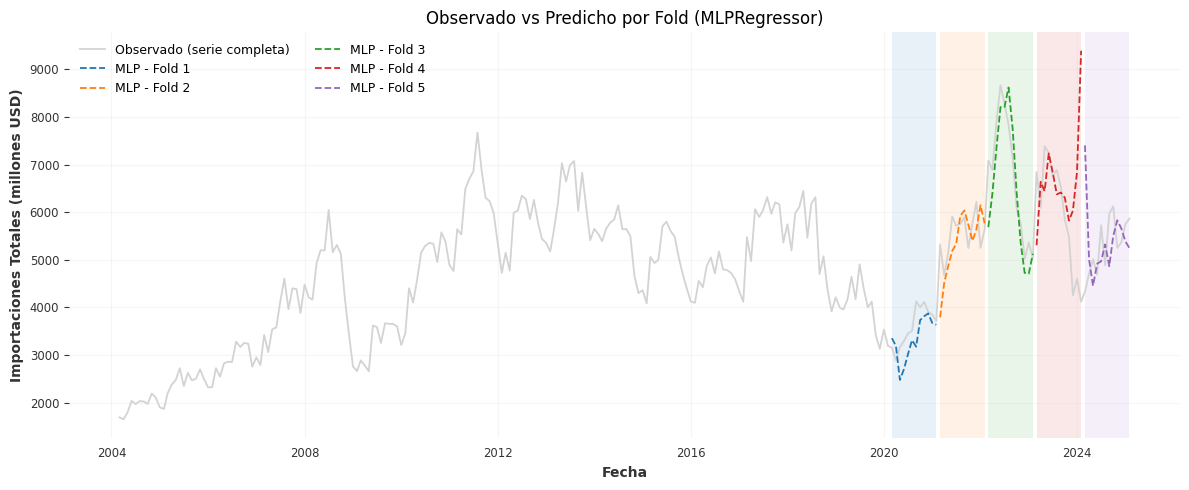

In [595]:
# --- gráfico Observado vs Predicho por fold ---
fig, ax = plt.subplots(figsize=(12,5))

# Observado completo en gris
ax.plot(y_full.index, y_full.values, color='lightgray', label='Observado (serie completa)')

# Predicciones por fold con sombreado
for i, fold_df in enumerate(fold_preds_mlp):
    c = colors[i % len(colors)]
    idx = fold_df.index
    ax.axvspan(idx[0], idx[-1], facecolor=c, alpha=0.10)
    ax.plot(idx, fold_df['y_pred'].values, color=c, linestyle='--', label=f'MLP - Fold {i+1}')

ax.set_title('Observado vs Predicho por Fold (MLPRegressor)', fontsize=12)
ax.set_xlabel('Fecha')
ax.set_ylabel('Importaciones Totales (millones USD)')
ax.legend(loc='upper left', ncol=2, fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Hiperparámetros MLP a usar en los folds:
  activation: tanh
  alpha: 0.01
  hidden_layer_sizes: (32, 16)
  solver: lbfgs
  shuffle: False
  early_stopping: True
  max_iter: 1000
  random_state: 123
Fold 1 → RMSE = 649.65, MAPE = 13.30%
Fold 2 → RMSE = 699.65, MAPE = 10.10%
Fold 3 → RMSE = 1520.81, MAPE = 17.51%
Fold 4 → RMSE = 1171.93, MAPE = 16.62%
Fold 5 → RMSE = 585.83, MAPE = 9.58%

RMSE promedio (MLP) = 925.57
MAPE promedio (MLP) = 13.42%


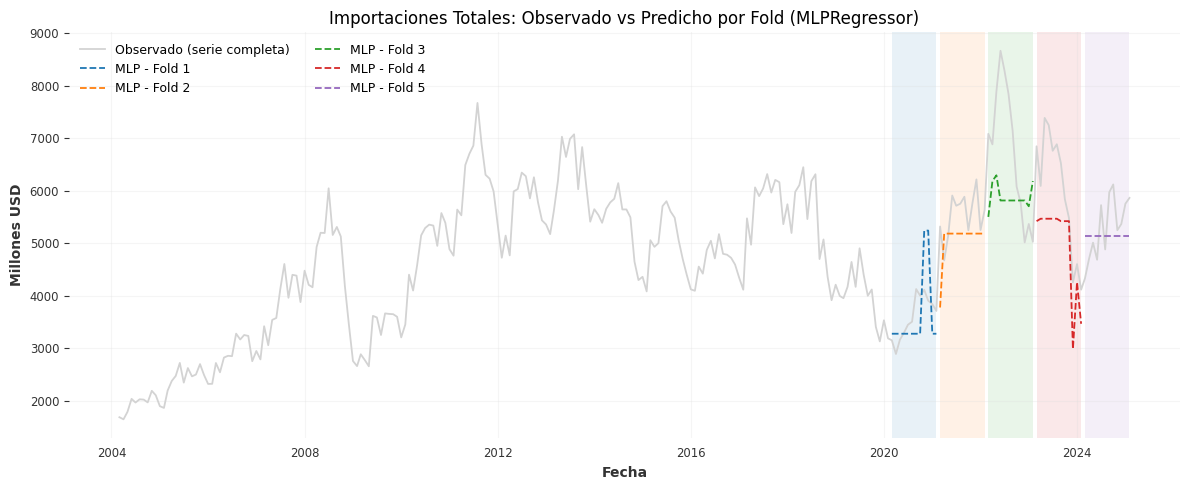

In [599]:
# --- tomar mejores hiperparámetros y normalizar claves ---
best_params = gsearch_mlp.best_params_  # o la variable que tengas

if any(k.startswith('mlp__') for k in best_params):
    mlp_best_params = {k.split('__', 1)[1]: v
                       for k, v in best_params.items() if k.startswith('mlp__')}
else:
    mlp_best_params = best_params.copy()

# Defaults “seguros” para TS si no están en el grid
mlp_best_params.setdefault('shuffle', False)
mlp_best_params.setdefault('early_stopping', True)
mlp_best_params.setdefault('max_iter', 1000)
mlp_best_params.setdefault('random_state', 123)

print("Hiperparámetros MLP a usar en los folds:")
for k, v in mlp_best_params.items():
    print(f"  {k}: {v}")

# --- cross-validation manual con esos hiperparámetros ---
rmse_scores_mlp, mape_scores_mlp, fold_preds_mlp = [], [], []
colors = plt.get_cmap('tab10').colors

def safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    # a) split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # b) escalado (solo con train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # c) entrenar
    mlp = MLPRegressor(**mlp_best_params)
    mlp.fit(X_train_s, y_train)

    # d) predecir + métricas
    y_pred = mlp.predict(X_test_s)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = safe_mape(y_test, y_pred)

    print(f"Fold {fold} → RMSE = {rmse:.2f}, MAPE = {mape:.2f}%")
    rmse_scores_mlp.append(rmse)
    mape_scores_mlp.append(mape)

    # guardar para gráfico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({'fold': fold, 'y_true': y_test.values, 'y_pred': y_pred}, index=idx_test)
    fold_preds_mlp.append(fold_df)

print(f"\nRMSE promedio (MLP) = {np.mean(rmse_scores_mlp):.2f}")
print(f"MAPE promedio (MLP) = {np.mean(mape_scores_mlp):.2f}%")

# --- gráfico Observado vs Predicho por fold ---
fig, ax = plt.subplots(figsize=(12,5))

# Observado completo en gris
ax.plot(y.index, y.values, color='lightgray', label='Observado (serie completa)')

# Predicciones por fold con sombreado
for i, fold_df in enumerate(fold_preds_mlp):
    c = colors[i % len(colors)]
    idx = fold_df.index
    ax.axvspan(idx[0], idx[-1], facecolor=c, alpha=0.10)
    ax.plot(idx, fold_df['y_pred'].values, color=c, linestyle='--', label=f'MLP - Fold {i+1}')

ax.set_title('Importaciones Totales: Observado vs Predicho por Fold (MLPRegressor)', fontsize=12)
ax.set_xlabel('Fecha'); ax.set_ylabel('Millones USD')
ax.legend(loc='upper left', ncol=2, fontsize=9)
ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

-----
> ### Método de Ensemble - Random Forest

Utilizamos Random Forest Regressor de Scikit Learn:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

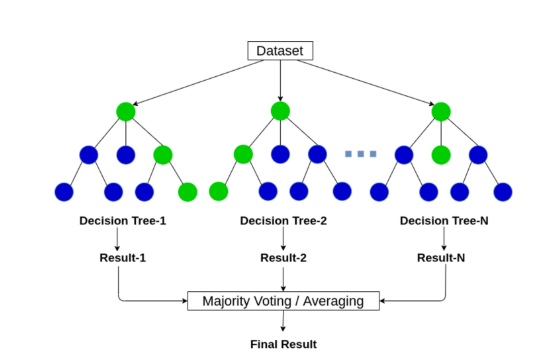

In [190]:
# Preparamos de nuevo los datos con el feature engineering utilizado anteriormente
X = df_feat[features]
y = df_feat['importaciones_total']

In [191]:
# Guardamos el modelo y sus parámetros
rf = RandomForestRegressor(
        n_estimators= 500, # cantidad de árboles
        max_depth= None, # Profundidad máxima permitida de cada árbol. Limitarla reduce el sobreajuste. Acá no le imponemos una restricción y puede crecer al max
        random_state=123,
        n_jobs=-1
    )

# En este primer intento vamos a dejar crecer el árbol al máximo

In [192]:
# Validación con TimeSeriesSplit y MAPE
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
mape_scores = []
rmse_scores = []

# Bucle fold‐a‐fold
for fold, (tr, te) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[tr], X.iloc[te]
    y_train, y_test = y.iloc[tr], y.iloc[te]
    
    # 3) Entrenar RandomForest
    rf.fit(X_train, y_train)
    
    # 4) Predecir
    y_pred = rf.predict(X_test)
    
    # 5) Métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print(f"Fold {fold} → RMSE = {rmse:.2f}, MAPE = {mape:.2f}%")
    rmse_scores.append(rmse)
    mape_scores.append(mape)

Fold 1 → RMSE = 348.50, MAPE = 7.69%
Fold 2 → RMSE = 739.10, MAPE = 11.70%
Fold 3 → RMSE = 1053.46, MAPE = 12.78%
Fold 4 → RMSE = 778.13, MAPE = 10.80%
Fold 5 → RMSE = 556.75, MAPE = 8.22%


In [193]:
# Errores Promedios
print(f"\nRMSE promedio  = {np.mean(rmse_scores):.2f}")
print(f"MAPE promedio = {np.mean(mape_scores):.2f}%")


RMSE promedio  = 695.19
MAPE promedio = 10.24%


##### Definimos hiperparámetros 
... **para frenar la profundidad de los árboles**, y de este modo reducir el riesgo de sobreajuste. 

##### Optimización de hiperparámetros con Grid Search

In [537]:
# Preparo el estimador base
rf = RandomForestRegressor(
    bootstrap=True,
    oob_score=False,    # lo usaremos con CV, no out‐of‐bag
    random_state=42,
    n_jobs=-1
)

# Grid de hiperparámetros a explorar
param_grid = {
    'n_estimators':      [100, 250, 500],
    'max_depth':         [None, 5, 10, 15],
    'min_samples_split': [None, 2, 5],
    'min_samples_leaf':  [1, 3, 5],
    'max_features':      ['sqrt', 'log2', 1]
}

# Configuro el GridSearchCV
gsearch_rf = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = 1,           # evita problemas de paralelismo
    verbose = 2,
    refit = True
)

# Ajusto sobre todo el df_train 
X = df_feat[features]
y = df_feat['importaciones_total']
gsearch_rf.fit(X, y)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=None, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=None, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=None, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=None, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=None, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=None, n_estimators=250; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=None, n_estimators=250; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=12),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'max_features': ['sqrt', 'log2', 1],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [None, 2, 5],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [541]:
print("Mejores hiperparámetros RF:", gsearch_rf.best_params_)
print("Mejor RMSE (CV):", -gsearch_rf.best_score_)

Mejores hiperparámetros RF: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
Mejor RMSE (CV): 642.3700735119579


In [543]:
# Cross validation fold a fold

best_rf = gsearch_rf.best_estimator_
colors = plt.get_cmap('tab10').colors
fold_preds = []
rmse_scores, mape_scores = [], []

for fold, (tr, te) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[tr], X.iloc[te]
    y_train, y_test = y.iloc[tr], y.iloc[te]

    best_rf.fit(X_train, y_train)
    y_pred = best_rf.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    rmse_scores.append(rmse)
    mape_scores.append(mape)

    print(f"Fold {fold} → RMSE = {rmse:.2f}, MAPE = {mape:.2f}%")

    fold_preds.append((fold, df_feat.index[te], y_test, y_pred))

# Resultados promedio (sin std)
print(f"\nRMSE promedio  = {np.mean(rmse_scores):.2f}")
print(f"MAPE promedio = {np.mean(mape_scores):.2f}%")


Fold 1 → RMSE = 293.75, MAPE = 6.37%
Fold 2 → RMSE = 646.56, MAPE = 8.84%
Fold 3 → RMSE = 1158.83, MAPE = 13.01%
Fold 4 → RMSE = 653.53, MAPE = 8.35%
Fold 5 → RMSE = 459.18, MAPE = 7.07%

RMSE promedio  = 642.37
MAPE promedio = 8.73%


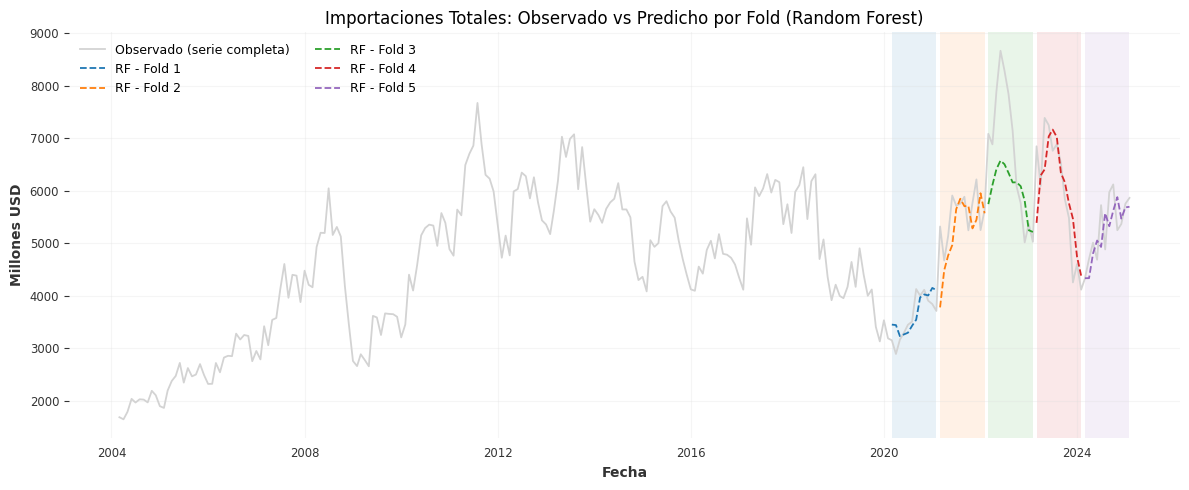

In [545]:
# Gráfico Observado vs Predicho por fold
fig, ax = plt.subplots(figsize=(12,5))

# Observado completo
ax.plot(df_feat.index, y, color='lightgray', label='Observado (serie completa)')

for fold, idx_test, y_true_fold, y_pred_fold in fold_preds:
    color = colors[(fold-1) % len(colors)]
    start, end = idx_test[0], idx_test[-1]
    ax.axvspan(start, end, facecolor=color, alpha=0.1)
    ax.plot(idx_test, y_pred_fold, color=color, linestyle='--',
            label=f'RF - Fold {fold}')

ax.set_title('Importaciones Totales: Observado vs Predicho por Fold (Random Forest)', fontsize=12)
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones USD')
ax.legend(loc='upper left', ncol=2, fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##### "Importancia" de las variables

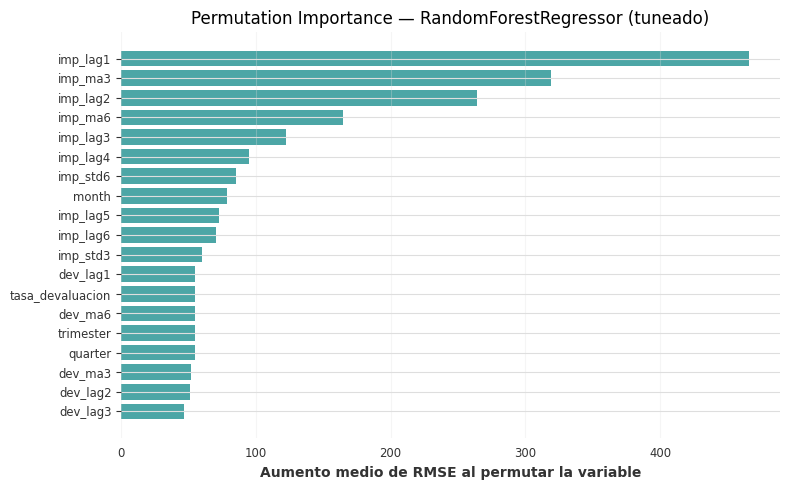

In [551]:
# Entrena el Random Forest definitivo sobre TODO el dataset
#  (dejando crecer los árboles al máximo)
def permute_importance(model, X, y, col, n_rounds=10, rng_seed=123):
    rng = np.random.default_rng(rng_seed)
    rmses = []
    X_perm = X.copy()
    original = X_perm[col].values.copy()
    for _ in range(n_rounds):
        X_perm[col] = rng.permutation(original)
        y_pred = model.predict(X_perm)
        rmses.append(np.sqrt(mean_squared_error(y, y_pred)))
        X_perm[col] = original  # restaurar la columna
    return float(np.mean(rmses) - rmse_base)  # aumento de RMSE vs base

# Calcula la importancia de cada feature
importances = {col: permute_importance(best_rf, X, y, col, n_rounds=10)
               for col in features}
imp_series = pd.Series(importances).sort_values(ascending=False)

# Gráfico
plt.figure(figsize=(8,5))
plt.barh(imp_series.index, imp_series.values, color='teal', alpha=0.7)
plt.gca().invert_yaxis()
plt.xlabel("Aumento medio de RMSE al permutar la variable")
plt.title("Permutation Importance — RandomForestRegressor (tuneado)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

----
> ### XGBoostRegressor

https://xgboost.readthedocs.io/en/stable/parameter.html

In [557]:
# Guardamos el modelo y sus hiperparámetros
# Hiperparámetros base, dejqando crecer los árboles al máximo
xgb_params = dict(
    n_estimators=2000,
    random_state=123,
    tree_method="hist",
    n_jobs=-1,
)

In [555]:
# Cross Validation 
rmse_scores, mape_scores = [], []
fold_preds = []   # para graficar predicciones por fold

for fold, (tr, te) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[tr], X.iloc[te]
    y_train, y_test = y.iloc[tr], y.iloc[te]

    # Early stopping: reservamos los últimos 12 puntos del train como validación interna
    n_val = min(12, len(X_train) // 5)  # fallback por si el primer fold es chico
    if n_val >= 3:  # nos aseguramos de tener algo de validación
        X_tr_i, X_val_i = X_train.iloc[:-n_val], X_train.iloc[-n_val:]
        y_tr_i, y_val_i = y_train.iloc[:-n_val], y_train.iloc[-n_val:]
        eval_set = [(X_val_i, y_val_i)]
    else:
        X_tr_i, y_tr_i = X_train, y_train
        eval_set = None

    model = XGBRegressor(**xgb_params)
    model.fit(
        X_tr_i, y_tr_i,
        eval_set=eval_set,
        verbose=False
    )

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    rmse_scores.append(rmse)
    mape_scores.append(mape)
    print(f"Fold {fold} → RMSE = {rmse:.2f} | MAPE = {mape:.2f}%")

    # guardar para gráfico
    fold_preds.append((fold, df_feat.index[te], y_test, y_pred))

print(f"\nRMSE promedio = {np.mean(rmse_scores):.2f}")
print(f"MAPE promedio = {np.mean(mape_scores):.2f}%")

Fold 1 → RMSE = 349.55 | MAPE = 8.58%
Fold 2 → RMSE = 750.53 | MAPE = 11.90%
Fold 3 → RMSE = 1098.21 | MAPE = 13.37%
Fold 4 → RMSE = 629.04 | MAPE = 8.60%
Fold 5 → RMSE = 610.54 | MAPE = 8.36%

RMSE promedio = 687.58
MAPE promedio = 10.16%


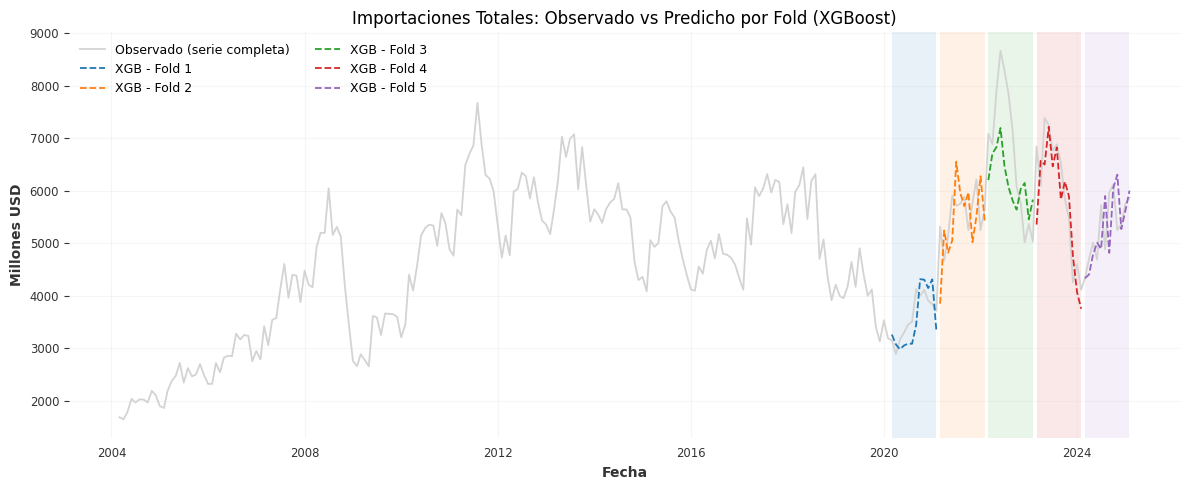

In [559]:
# Gráfico de observado vs predicho
fig, ax = plt.subplots(figsize=(12,5))

# Observado completo en gris
ax.plot(df_feat.index, y, color='lightgray', label='Observado (serie completa)')

# Predicciones por fold con sombreado
for fold, idx_test, y_true_fold, y_pred_fold in fold_preds:
    color = colors[(fold-1) % len(colors)]
    start, end = idx_test[0], idx_test[-1]
    ax.axvspan(start, end, facecolor=color, alpha=0.1)
    ax.plot(idx_test, y_pred_fold, color=color, linestyle='--',
            label=f'XGB - Fold {fold}')

ax.set_title('Importaciones Totales: Observado vs Predicho por Fold (XGBoost)', fontsize=12)
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones USD')
ax.legend(loc='upper left', ncol=2, fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##### Optimización de hiperparámetros con Grid Search
Recomiendo no correr porque tarda bastante, son 570 combinaciones posibles de hiperparámetros

In [226]:
rmse_scorer = 'neg_root_mean_squared_error'

# Espacio de hiperparámetros

param_grid = {
    'n_estimators':      [250, 500, 750], #cantidad de árboles que va a estimar el modelo
    'max_depth':         [5, 8, 12], # profundidad máxima de cada árbol, limita sobreajuste
    'min_child_weight':  [3, 5, 8, 12], # cuanto más grande, el modelo evita splits en nodos con pocos datos, menos sobreajuste
    'subsample':         [0.8, 1.0], # Proporción de datos que se usan al entrenar cada árbol. <1.0 introduce aleatoriedad y puede reducir overfitting.
    'colsample_bytree':  [0.8, 1.0], # Proporción de features usadas para entrenar cada árbol.
    'reg_alpha':         [0.0, 0.1],      # L1
    'reg_lambda':        [1.0, 2.0],      # L2
}

base_xgb = XGBRegressor(
    random_state=123,
    n_jobs=-1,
    tree_method="hist"   
)

gsearch_xgb = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=1,           # evita conflictos de paralelismo entre XGB y CV
    verbose=2,
    refit=True
)

# Entrenar GS 
gsearch_xgb.fit(X, y)

print("Mejores hiperparámetros XGB:", gsearch_xgb.best_params_)
print("Mejor RMSE (CV):", -gsearch_xgb.best_score_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END colsample_bytree=0.8, max_depth=5, min_child_weight=3, n_estimators=250, reg_alpha=0.0, reg_lambda=1.0, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, max_depth=5, min_child_weight=3, n_estimators=250, reg_alpha=0.0, reg_lambda=1.0, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, max_depth=5, min_child_weight=3, n_estimators=250, reg_alpha=0.0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, max_depth=5, min_child_weight=3, n_estimators=250, reg_alpha=0.0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, max_depth=5, min_child_weight=3, n_estimators=250, reg_alpha=0.0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, max_depth=5, min_child_weight=3, n_estimators=250, reg_alpha=0.0, reg_lambda=1.0, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, max_depth=5, min_child_

In [562]:
print("Mejores hiperparámetros XGB:", gsearch_xgb.best_params_)
print("Mejor RMSE (CV):", -gsearch_xgb.best_score_)

Mejores hiperparámetros XGB: {'colsample_bytree': 0.8, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 250, 'reg_alpha': 0.1, 'reg_lambda': 2.0, 'subsample': 1.0}
Mejor RMSE (CV): 613.2978290154155


In [564]:
best_params = gsearch_xgb.best_params_
print(best_params)

{'colsample_bytree': 0.8, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 250, 'reg_alpha': 0.1, 'reg_lambda': 2.0, 'subsample': 1.0}


In [566]:
# Cross validation con los 5 folds
# Usamos los mejores hiperparámetros encontrados

# Hiperparámetros resultantes de la optimización
best_params = dict(
    n_estimators=250,
    learning_rate=0.03,
    max_depth=5,
    subsample=1.0,
    colsample_bytree=0.8,
    reg_alpha=0.1, 
    reg_lambda=2.0,
    min_child_weight = 8
)


# Lista para almacenar métricas y predicciones por fold
rmse_scores, mape_scores = [], []
fold_preds = []

for fold, (tr, te) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[tr], X.iloc[te]
    y_train, y_test = y.iloc[tr], y.iloc[te]

    # Early stopping: últimos 12 puntos del train como validación interna
    n_val = min(12, len(X_train) // 5)
    if n_val >= 3:
        X_tr_i, X_val_i = X_train.iloc[:-n_val], X_train.iloc[-n_val:]
        y_tr_i, y_val_i = y_train.iloc[:-n_val], y_train.iloc[-n_val:]
        eval_set = [(X_val_i, y_val_i)]
    else:
        X_tr_i, y_tr_i = X_train, y_train
        eval_set = None

    # Entrenamos el modelo con los hiperparámetros optimizados
    model = XGBRegressor(
        **best_params,
        random_state=123,
        tree_method="hist",
        n_jobs=-1
    )

    model.fit(
        X_tr_i, y_tr_i,
        eval_set=eval_set,
        verbose=False
    )

    # Predicción
    y_pred = model.predict(X_test)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    rmse_scores.append(rmse)
    mape_scores.append(mape)

    print(f"Fold {fold} → RMSE = {rmse:.2f} | MAPE = {mape:.2f}%")

    fold_preds.append((fold, df_feat.index[te], y_test, y_pred))

# Promedios finales
print(f"\nRMSE promedio = {np.mean(rmse_scores):.2f}")
print(f"MAPE promedio = {np.mean(mape_scores):.2f}%")

Fold 1 → RMSE = 337.52 | MAPE = 8.08%
Fold 2 → RMSE = 678.53 | MAPE = 9.43%
Fold 3 → RMSE = 1089.57 | MAPE = 12.31%
Fold 4 → RMSE = 771.99 | MAPE = 10.46%
Fold 5 → RMSE = 551.27 | MAPE = 8.92%

RMSE promedio = 685.78
MAPE promedio = 9.84%


Los resultados de la optimización no son mejores que el modelo base...
Por lo que nos quedamos con los parámetros originales del modelo base

RMSE base (entrenamiento): 118.7192


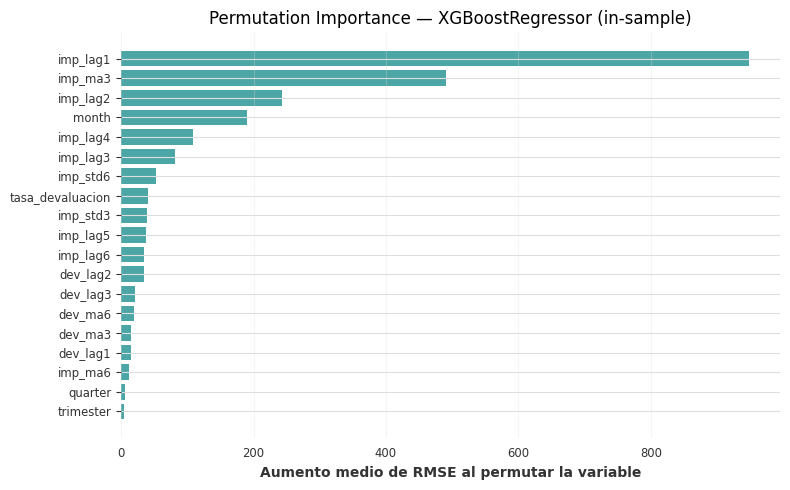

In [305]:
# Gráfico de feature importance
xgb_final = XGBRegressor(
    **best_params
)

X = df_feat[features]
y = df_feat['importaciones_total']
xgb_final.fit(X, y)

# --- RMSE base (in-sample) ---
y_pred_base = xgb_final.predict(X)
rmse_base   = sqrt(mean_squared_error(y, y_pred_base))
print(f"RMSE base (entrenamiento): {rmse_base:.4f}")

# --- Función de Permutation Importance ---
def permute_importance(model, X, y, col, n_rounds=10):
    rmses = []
    X_perm = X.copy()
    for _ in range(n_rounds):
        X_perm[col] = np.random.permutation(X_perm[col].values)
        y_pred = model.predict(X_perm)
        rmses.append(sqrt(mean_squared_error(y, y_pred)))
    return np.mean(rmses) - rmse_base

# --- Importancia por feature ---
importances = {col: permute_importance(xgb_final, X, y, col, n_rounds=10)
               for col in features}
imp_series = pd.Series(importances).sort_values(ascending=False)

# --- Gráfico ---
plt.figure(figsize=(8,5))
plt.barh(imp_series.index, imp_series.values, color='teal', alpha=0.7)
plt.gca().invert_yaxis()
plt.xlabel("Aumento medio de RMSE al permutar la variable")
plt.title("Permutation Importance — XGBoostRegressor (in-sample)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

----
> ### Facebook Prophet

In [307]:
# Primero debemos preparar los datos para que sean adecuados para Prophet
df_prophet = df_merged.reset_index()[['indice_tiempo', 'importaciones_total', 'tasa_devaluacion']].copy()
df_prophet.rename(columns={'indice_tiempo': 'ds', 'importaciones_total': 'y'}, inplace=True)

In [309]:
# Definimos los hiperparámetros estándar
# Este primer modelo va a ser uno con poca complejidad, sin definir tantos hiperparámetros
prophet_params = dict(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive'
)

In [311]:
# Guardamos el modelo y añadimos la variable regresora
base_prophet = Prophet(**prophet_params)
base_prophet.add_regressor('tasa_devaluacion')

In [313]:
# 0) Preparar df para Prophet y sanear
dfp = (
    df_merged
      .reset_index()
      .rename(columns={'indice_tiempo': 'ds', 'importaciones_total': 'y'})
      [['ds', 'y', 'tasa_devaluacion']]
      .copy()
)

In [315]:
# Tipos y limpieza básica
dfp['ds'] = pd.to_datetime(dfp['ds'], errors='coerce')
dfp['y'] = pd.to_numeric(dfp['y'], errors='coerce')
dfp['tasa_devaluacion'] = pd.to_numeric(dfp['tasa_devaluacion'], errors='coerce')
dfp = dfp.dropna(subset=['ds', 'y', 'tasa_devaluacion'])
dfp = dfp.sort_values('ds')
dfp = dfp[~dfp['ds'].duplicated()].reset_index(drop=True)  # sin fechas duplicadas

20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:32 - cmdstanpy - INFO - Chain [1] done processing
20:28:32 - cmdstanpy - INFO - Chain [1] start processing
20:28:32 - cmdstanpy - INFO - Chain [1] done processing


Fold 1 → RMSE = 1058.07 | MAPE = 25.64%


20:28:32 - cmdstanpy - INFO - Chain [1] start processing
20:28:32 - cmdstanpy - INFO - Chain [1] done processing


Fold 2 → RMSE = 1744.12 | MAPE = 29.60%
Fold 3 → RMSE = 2604.07 | MAPE = 34.56%


20:28:32 - cmdstanpy - INFO - Chain [1] start processing
20:28:32 - cmdstanpy - INFO - Chain [1] done processing
20:28:32 - cmdstanpy - INFO - Chain [1] start processing
20:28:32 - cmdstanpy - INFO - Chain [1] done processing


Fold 4 → RMSE = 1167.90 | MAPE = 14.51%
Fold 5 → RMSE = 922.92 | MAPE = 15.45%

RMSE promedio = 1499.42
MAPE promedio = 23.95%


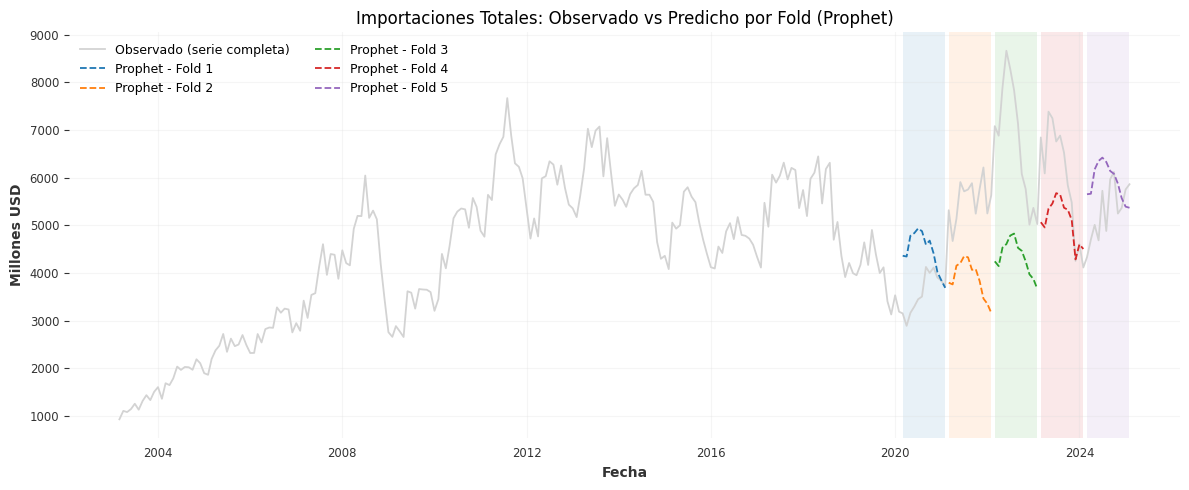

In [324]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit

# --- Configuración ---
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
colors = plt.get_cmap('tab10').colors

rmse_scores, mape_scores = [], []
fold_preds = []

# --- Validación ---
for fold, (train_idx, test_idx) in enumerate(tscv.split(df_prophet), start=1):
    train_df = df_prophet.iloc[train_idx].copy()
    test_df  = df_prophet.iloc[test_idx].copy()

    # Modelo Prophet
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive'
    )
    model.add_regressor('tasa_devaluacion')

    # Entrenar
    model.fit(train_df)

    # Predecir
    forecast = model.predict(test_df[['ds', 'tasa_devaluacion']])
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values
    idx_test = test_df['ds']

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    print(f"Fold {fold} → RMSE = {rmse:.2f} | MAPE = {mape:.2f}%")

    # Guardar para gráfico
    fold_preds.append((fold, idx_test, y_true, y_pred))

# --- Promedios ---
print(f"\nRMSE promedio = {np.mean(rmse_scores):.2f}")
print(f"MAPE promedio = {np.mean(mape_scores):.2f}%")

# --- Gráfico Observado vs Predicho por fold ---
fig, ax = plt.subplots(figsize=(12,5))

# Serie observada completa en gris
ax.plot(df_prophet['ds'], df_prophet['y'], color='lightgray', label='Observado (serie completa)')

# Predicciones y sombreado por fold
for fold, idx_test, y_true_fold, y_pred_fold in fold_preds:
    color = colors[(fold-1) % len(colors)]
    start, end = idx_test.iloc[0], idx_test.iloc[-1]
    ax.axvspan(start, end, facecolor=color, alpha=0.1)
    ax.plot(idx_test, y_pred_fold, color=color, linestyle='--',
            label=f'Prophet - Fold {fold}')

ax.set_title('Importaciones Totales: Observado vs Predicho por Fold (Prophet)', fontsize=12)
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones USD')
ax.legend(loc='upper left', ncol=2, fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Los resultados del modelo no son los mejores, esto es porque hay hiperparámetros clave que no definimos todavía. 

##### Agregamos hiperparámetros faltantes y optimizamos con grid search

In [332]:
import itertools


# Split temporal
tscv = TimeSeriesSplit(n_splits=5, test_size=12)

# --- Espacio de búsqueda (sin yearly_seasonality) ---
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [1, 5, 10, 15],
    'monthly_fourier_order': [3, 5, 7],
    'changepoint_range': [0.8, 0.9],
}

# Helper para producto cartesiano
def product_dict(d):
    keys = d.keys()
    for values in itertools.product(*d.values()):
        yield dict(zip(keys, values))

# --- Función de evaluación ---
def evaluate_params(params, df):
    rmse_scores, mape_scores = [], []

    for tr, te in tscv.split(df):
        train_df = df.iloc[tr].copy()
        test_df  = df.iloc[te].copy()

        # Modelo Prophet con yearly_seasonality fijo
        model = Prophet(
            yearly_seasonality=True,  # FIJO
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode=params['seasonality_mode'],
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            changepoint_range=params['changepoint_range'],
            interval_width=0.95
        )
        model.add_regressor('tasa_devaluacion')
        model.add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=params['monthly_fourier_order']
        )

        model.fit(train_df)
        fcst = model.predict(test_df[['ds', 'tasa_devaluacion']])

        y_true = test_df['y'].to_numpy()
        y_pred = fcst['yhat'].to_numpy()

        rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
        mape = float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
        rmse_scores.append(rmse)
        mape_scores.append(mape)

    return np.mean(rmse_scores), np.std(rmse_scores), np.mean(mape_scores), np.std(mape_scores)

# --- Grid Search ---
results = []
for combo in product_dict(param_grid):
    mean_rmse, std_rmse, mean_mape, std_mape = evaluate_params(combo, dfp)
    row = {
        **combo,
        'rmse_mean': round(mean_rmse, 4),
        'rmse_std': round(std_rmse, 4),
        'mape_mean': round(mean_mape, 4),
        'mape_std': round(std_mape, 4),
    }
    results.append(row)
    print(f"Evaluado: {row}")

res_df = pd.DataFrame(results).sort_values('rmse_mean', ascending=True).reset_index(drop=True)

print("\nTop 10 combinaciones por RMSE promedio:")
display(res_df.head(10))

best_params = res_df.iloc[0].to_dict()
print("\n>> Mejores hiperparámetros (según RMSE):")
for k in param_grid.keys():
    print(f"  {k}: {best_params[k]}")
print(f"  rmse_mean = {best_params['rmse_mean']} | mape_mean = {best_params['mape_mean']}")

20:44:55 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] done processing
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] done processing
20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1461.3109, 'rmse_std': 286.2918, 'mape_mean': 25.5014, 'mape_std': 6.9477}


20:44:57 - cmdstanpy - INFO - Chain [1] start processing
20:44:57 - cmdstanpy - INFO - Chain [1] done processing
20:44:58 - cmdstanpy - INFO - Chain [1] start processing
20:44:58 - cmdstanpy - INFO - Chain [1] done processing
20:44:58 - cmdstanpy - INFO - Chain [1] start processing
20:44:58 - cmdstanpy - INFO - Chain [1] done processing
20:44:58 - cmdstanpy - INFO - Chain [1] start processing
20:44:58 - cmdstanpy - INFO - Chain [1] done processing
20:44:59 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1439.8543, 'rmse_std': 259.1022, 'mape_mean': 25.2356, 'mape_std': 7.1937}


20:44:59 - cmdstanpy - INFO - Chain [1] done processing
20:44:59 - cmdstanpy - INFO - Chain [1] start processing
20:44:59 - cmdstanpy - INFO - Chain [1] done processing
20:44:59 - cmdstanpy - INFO - Chain [1] start processing
20:44:59 - cmdstanpy - INFO - Chain [1] done processing
20:45:00 - cmdstanpy - INFO - Chain [1] start processing
20:45:00 - cmdstanpy - INFO - Chain [1] done processing
20:45:00 - cmdstanpy - INFO - Chain [1] start processing
20:45:00 - cmdstanpy - INFO - Chain [1] done processing
20:45:01 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 1617.8742, 'rmse_std': 271.51, 'mape_mean': 28.8002, 'mape_std': 7.7982}


20:45:01 - cmdstanpy - INFO - Chain [1] done processing
20:45:01 - cmdstanpy - INFO - Chain [1] start processing
20:45:01 - cmdstanpy - INFO - Chain [1] done processing
20:45:01 - cmdstanpy - INFO - Chain [1] start processing
20:45:01 - cmdstanpy - INFO - Chain [1] done processing
20:45:01 - cmdstanpy - INFO - Chain [1] start processing
20:45:02 - cmdstanpy - INFO - Chain [1] done processing
20:45:02 - cmdstanpy - INFO - Chain [1] start processing
20:45:02 - cmdstanpy - INFO - Chain [1] done processing
20:45:02 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1571.3447, 'rmse_std': 209.9414, 'mape_mean': 27.7512, 'mape_std': 5.5428}


20:45:02 - cmdstanpy - INFO - Chain [1] done processing
20:45:03 - cmdstanpy - INFO - Chain [1] start processing
20:45:03 - cmdstanpy - INFO - Chain [1] done processing
20:45:03 - cmdstanpy - INFO - Chain [1] start processing
20:45:03 - cmdstanpy - INFO - Chain [1] done processing
20:45:03 - cmdstanpy - INFO - Chain [1] start processing
20:45:03 - cmdstanpy - INFO - Chain [1] done processing
20:45:04 - cmdstanpy - INFO - Chain [1] start processing
20:45:04 - cmdstanpy - INFO - Chain [1] done processing
20:45:04 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1476.8123, 'rmse_std': 434.9959, 'mape_mean': 26.6417, 'mape_std': 8.3153}


20:45:04 - cmdstanpy - INFO - Chain [1] done processing
20:45:04 - cmdstanpy - INFO - Chain [1] start processing
20:45:04 - cmdstanpy - INFO - Chain [1] done processing
20:45:05 - cmdstanpy - INFO - Chain [1] start processing
20:45:05 - cmdstanpy - INFO - Chain [1] done processing
20:45:05 - cmdstanpy - INFO - Chain [1] start processing
20:45:05 - cmdstanpy - INFO - Chain [1] done processing
20:45:05 - cmdstanpy - INFO - Chain [1] start processing
20:45:05 - cmdstanpy - INFO - Chain [1] done processing
20:45:06 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1519.3261, 'rmse_std': 494.8157, 'mape_mean': 27.5035, 'mape_std': 9.2318}


20:45:06 - cmdstanpy - INFO - Chain [1] done processing
20:45:06 - cmdstanpy - INFO - Chain [1] start processing
20:45:06 - cmdstanpy - INFO - Chain [1] done processing
20:45:06 - cmdstanpy - INFO - Chain [1] start processing
20:45:06 - cmdstanpy - INFO - Chain [1] done processing
20:45:07 - cmdstanpy - INFO - Chain [1] start processing
20:45:07 - cmdstanpy - INFO - Chain [1] done processing
20:45:07 - cmdstanpy - INFO - Chain [1] start processing
20:45:07 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1462.1095, 'rmse_std': 279.5918, 'mape_mean': 25.587, 'mape_std': 7.1552}


20:45:07 - cmdstanpy - INFO - Chain [1] start processing
20:45:07 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:09 - cmdstanpy - INFO - Chain [1] start processing
20:45:09 - cmdstanpy - INFO - Chain [1] done processing
20:45:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1440.3654, 'rmse_std': 257.7965, 'mape_mean': 25.2032, 'mape_std': 7.0191}


20:45:09 - cmdstanpy - INFO - Chain [1] done processing
20:45:09 - cmdstanpy - INFO - Chain [1] start processing
20:45:09 - cmdstanpy - INFO - Chain [1] done processing
20:45:10 - cmdstanpy - INFO - Chain [1] start processing
20:45:10 - cmdstanpy - INFO - Chain [1] done processing
20:45:10 - cmdstanpy - INFO - Chain [1] start processing
20:45:10 - cmdstanpy - INFO - Chain [1] done processing
20:45:11 - cmdstanpy - INFO - Chain [1] start processing
20:45:11 - cmdstanpy - INFO - Chain [1] done processing
20:45:11 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 1634.5452, 'rmse_std': 304.1379, 'mape_mean': 29.0449, 'mape_std': 8.0572}


20:45:11 - cmdstanpy - INFO - Chain [1] done processing
20:45:11 - cmdstanpy - INFO - Chain [1] start processing
20:45:11 - cmdstanpy - INFO - Chain [1] done processing
20:45:11 - cmdstanpy - INFO - Chain [1] start processing
20:45:12 - cmdstanpy - INFO - Chain [1] done processing
20:45:12 - cmdstanpy - INFO - Chain [1] start processing
20:45:12 - cmdstanpy - INFO - Chain [1] done processing
20:45:12 - cmdstanpy - INFO - Chain [1] start processing
20:45:12 - cmdstanpy - INFO - Chain [1] done processing
20:45:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1574.2124, 'rmse_std': 219.9422, 'mape_mean': 27.8001, 'mape_std': 5.5582}


20:45:12 - cmdstanpy - INFO - Chain [1] done processing
20:45:13 - cmdstanpy - INFO - Chain [1] start processing
20:45:13 - cmdstanpy - INFO - Chain [1] done processing
20:45:13 - cmdstanpy - INFO - Chain [1] start processing
20:45:13 - cmdstanpy - INFO - Chain [1] done processing
20:45:13 - cmdstanpy - INFO - Chain [1] start processing
20:45:13 - cmdstanpy - INFO - Chain [1] done processing
20:45:14 - cmdstanpy - INFO - Chain [1] start processing
20:45:14 - cmdstanpy - INFO - Chain [1] done processing
20:45:14 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1497.7523, 'rmse_std': 433.5507, 'mape_mean': 27.1138, 'mape_std': 8.38}


20:45:14 - cmdstanpy - INFO - Chain [1] done processing
20:45:14 - cmdstanpy - INFO - Chain [1] start processing
20:45:14 - cmdstanpy - INFO - Chain [1] done processing
20:45:15 - cmdstanpy - INFO - Chain [1] start processing
20:45:15 - cmdstanpy - INFO - Chain [1] done processing
20:45:15 - cmdstanpy - INFO - Chain [1] start processing
20:45:15 - cmdstanpy - INFO - Chain [1] done processing
20:45:15 - cmdstanpy - INFO - Chain [1] start processing
20:45:15 - cmdstanpy - INFO - Chain [1] done processing
20:45:16 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1552.0036, 'rmse_std': 485.8116, 'mape_mean': 28.1239, 'mape_std': 8.9792}


20:45:16 - cmdstanpy - INFO - Chain [1] done processing
20:45:16 - cmdstanpy - INFO - Chain [1] start processing
20:45:16 - cmdstanpy - INFO - Chain [1] done processing
20:45:16 - cmdstanpy - INFO - Chain [1] start processing
20:45:16 - cmdstanpy - INFO - Chain [1] done processing
20:45:17 - cmdstanpy - INFO - Chain [1] start processing
20:45:17 - cmdstanpy - INFO - Chain [1] done processing
20:45:17 - cmdstanpy - INFO - Chain [1] start processing
20:45:17 - cmdstanpy - INFO - Chain [1] done processing
20:45:17 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1532.0968, 'rmse_std': 195.3894, 'mape_mean': 26.9502, 'mape_std': 5.5879}


20:45:17 - cmdstanpy - INFO - Chain [1] done processing
20:45:18 - cmdstanpy - INFO - Chain [1] start processing
20:45:18 - cmdstanpy - INFO - Chain [1] done processing
20:45:18 - cmdstanpy - INFO - Chain [1] start processing
20:45:18 - cmdstanpy - INFO - Chain [1] done processing
20:45:18 - cmdstanpy - INFO - Chain [1] start processing
20:45:18 - cmdstanpy - INFO - Chain [1] done processing
20:45:18 - cmdstanpy - INFO - Chain [1] start processing
20:45:19 - cmdstanpy - INFO - Chain [1] done processing
20:45:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1439.1462, 'rmse_std': 256.1569, 'mape_mean': 25.2228, 'mape_std': 7.1619}


20:45:19 - cmdstanpy - INFO - Chain [1] done processing
20:45:19 - cmdstanpy - INFO - Chain [1] start processing
20:45:19 - cmdstanpy - INFO - Chain [1] done processing
20:45:19 - cmdstanpy - INFO - Chain [1] start processing
20:45:20 - cmdstanpy - INFO - Chain [1] done processing
20:45:20 - cmdstanpy - INFO - Chain [1] start processing
20:45:20 - cmdstanpy - INFO - Chain [1] done processing
20:45:20 - cmdstanpy - INFO - Chain [1] start processing
20:45:20 - cmdstanpy - INFO - Chain [1] done processing
20:45:20 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 1630.1853, 'rmse_std': 301.6893, 'mape_mean': 28.9422, 'mape_std': 7.9643}


20:45:20 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:22 - cmdstanpy - INFO - Chain [1] start processing
20:45:22 - cmdstanpy - INFO - Chain [1] done processing
20:45:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1579.8209, 'rmse_std': 218.7794, 'mape_mean': 27.9019, 'mape_std': 5.5823}


20:45:22 - cmdstanpy - INFO - Chain [1] done processing
20:45:22 - cmdstanpy - INFO - Chain [1] start processing
20:45:22 - cmdstanpy - INFO - Chain [1] done processing
20:45:23 - cmdstanpy - INFO - Chain [1] start processing
20:45:23 - cmdstanpy - INFO - Chain [1] done processing
20:45:23 - cmdstanpy - INFO - Chain [1] start processing
20:45:23 - cmdstanpy - INFO - Chain [1] done processing
20:45:23 - cmdstanpy - INFO - Chain [1] start processing
20:45:24 - cmdstanpy - INFO - Chain [1] done processing
20:45:24 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1499.8731, 'rmse_std': 456.3538, 'mape_mean': 27.0587, 'mape_std': 8.5812}


20:45:24 - cmdstanpy - INFO - Chain [1] done processing
20:45:24 - cmdstanpy - INFO - Chain [1] start processing
20:45:24 - cmdstanpy - INFO - Chain [1] done processing
20:45:24 - cmdstanpy - INFO - Chain [1] start processing
20:45:25 - cmdstanpy - INFO - Chain [1] done processing
20:45:25 - cmdstanpy - INFO - Chain [1] start processing
20:45:25 - cmdstanpy - INFO - Chain [1] done processing
20:45:25 - cmdstanpy - INFO - Chain [1] start processing
20:45:25 - cmdstanpy - INFO - Chain [1] done processing
20:45:25 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1544.3818, 'rmse_std': 468.0094, 'mape_mean': 27.9638, 'mape_std': 8.7787}


20:45:26 - cmdstanpy - INFO - Chain [1] done processing
20:45:26 - cmdstanpy - INFO - Chain [1] start processing
20:45:26 - cmdstanpy - INFO - Chain [1] done processing
20:45:26 - cmdstanpy - INFO - Chain [1] start processing
20:45:26 - cmdstanpy - INFO - Chain [1] done processing
20:45:26 - cmdstanpy - INFO - Chain [1] start processing
20:45:26 - cmdstanpy - INFO - Chain [1] done processing
20:45:27 - cmdstanpy - INFO - Chain [1] start processing
20:45:27 - cmdstanpy - INFO - Chain [1] done processing
20:45:27 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1468.0518, 'rmse_std': 284.1497, 'mape_mean': 25.6521, 'mape_std': 7.0263}


20:45:27 - cmdstanpy - INFO - Chain [1] done processing
20:45:27 - cmdstanpy - INFO - Chain [1] start processing
20:45:27 - cmdstanpy - INFO - Chain [1] done processing
20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:29 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1439.6552, 'rmse_std': 258.4042, 'mape_mean': 25.1854, 'mape_std': 6.9637}


20:45:29 - cmdstanpy - INFO - Chain [1] done processing
20:45:29 - cmdstanpy - INFO - Chain [1] start processing
20:45:29 - cmdstanpy - INFO - Chain [1] done processing
20:45:29 - cmdstanpy - INFO - Chain [1] start processing
20:45:29 - cmdstanpy - INFO - Chain [1] done processing
20:45:30 - cmdstanpy - INFO - Chain [1] start processing
20:45:30 - cmdstanpy - INFO - Chain [1] done processing
20:45:30 - cmdstanpy - INFO - Chain [1] start processing
20:45:30 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 1612.6881, 'rmse_std': 279.1061, 'mape_mean': 28.6122, 'mape_std': 7.673}


20:45:30 - cmdstanpy - INFO - Chain [1] start processing
20:45:30 - cmdstanpy - INFO - Chain [1] done processing
20:45:31 - cmdstanpy - INFO - Chain [1] start processing
20:45:31 - cmdstanpy - INFO - Chain [1] done processing
20:45:31 - cmdstanpy - INFO - Chain [1] start processing
20:45:31 - cmdstanpy - INFO - Chain [1] done processing
20:45:31 - cmdstanpy - INFO - Chain [1] start processing
20:45:31 - cmdstanpy - INFO - Chain [1] done processing
20:45:32 - cmdstanpy - INFO - Chain [1] start processing
20:45:32 - cmdstanpy - INFO - Chain [1] done processing
20:45:32 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1574.9071, 'rmse_std': 217.3456, 'mape_mean': 27.8061, 'mape_std': 5.5358}


20:45:32 - cmdstanpy - INFO - Chain [1] done processing
20:45:32 - cmdstanpy - INFO - Chain [1] start processing
20:45:32 - cmdstanpy - INFO - Chain [1] done processing
20:45:33 - cmdstanpy - INFO - Chain [1] start processing
20:45:33 - cmdstanpy - INFO - Chain [1] done processing
20:45:33 - cmdstanpy - INFO - Chain [1] start processing
20:45:33 - cmdstanpy - INFO - Chain [1] done processing
20:45:33 - cmdstanpy - INFO - Chain [1] start processing
20:45:33 - cmdstanpy - INFO - Chain [1] done processing
20:45:34 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1496.657, 'rmse_std': 433.316, 'mape_mean': 27.0917, 'mape_std': 8.4053}


20:45:34 - cmdstanpy - INFO - Chain [1] done processing
20:45:34 - cmdstanpy - INFO - Chain [1] start processing
20:45:34 - cmdstanpy - INFO - Chain [1] done processing
20:45:34 - cmdstanpy - INFO - Chain [1] start processing
20:45:34 - cmdstanpy - INFO - Chain [1] done processing
20:45:35 - cmdstanpy - INFO - Chain [1] start processing
20:45:35 - cmdstanpy - INFO - Chain [1] done processing
20:45:35 - cmdstanpy - INFO - Chain [1] start processing
20:45:35 - cmdstanpy - INFO - Chain [1] done processing
20:45:35 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1548.1128, 'rmse_std': 475.1222, 'mape_mean': 28.032, 'mape_std': 8.8597}


20:45:35 - cmdstanpy - INFO - Chain [1] done processing
20:45:36 - cmdstanpy - INFO - Chain [1] start processing
20:45:36 - cmdstanpy - INFO - Chain [1] done processing
20:45:36 - cmdstanpy - INFO - Chain [1] start processing
20:45:36 - cmdstanpy - INFO - Chain [1] done processing
20:45:36 - cmdstanpy - INFO - Chain [1] start processing
20:45:36 - cmdstanpy - INFO - Chain [1] done processing
20:45:37 - cmdstanpy - INFO - Chain [1] start processing
20:45:37 - cmdstanpy - INFO - Chain [1] done processing
20:45:37 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1843.8505, 'rmse_std': 531.9544, 'mape_mean': 31.5727, 'mape_std': 8.6858}


20:45:37 - cmdstanpy - INFO - Chain [1] done processing
20:45:37 - cmdstanpy - INFO - Chain [1] start processing
20:45:37 - cmdstanpy - INFO - Chain [1] done processing
20:45:38 - cmdstanpy - INFO - Chain [1] start processing
20:45:38 - cmdstanpy - INFO - Chain [1] done processing
20:45:38 - cmdstanpy - INFO - Chain [1] start processing
20:45:38 - cmdstanpy - INFO - Chain [1] done processing
20:45:38 - cmdstanpy - INFO - Chain [1] start processing
20:45:38 - cmdstanpy - INFO - Chain [1] done processing
20:45:39 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1831.4768, 'rmse_std': 517.1562, 'mape_mean': 31.3705, 'mape_std': 8.4018}


20:45:39 - cmdstanpy - INFO - Chain [1] done processing
20:45:39 - cmdstanpy - INFO - Chain [1] start processing
20:45:39 - cmdstanpy - INFO - Chain [1] done processing
20:45:39 - cmdstanpy - INFO - Chain [1] start processing
20:45:39 - cmdstanpy - INFO - Chain [1] done processing
20:45:40 - cmdstanpy - INFO - Chain [1] start processing
20:45:40 - cmdstanpy - INFO - Chain [1] done processing
20:45:40 - cmdstanpy - INFO - Chain [1] start processing
20:45:40 - cmdstanpy - INFO - Chain [1] done processing
20:45:40 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2333.6207, 'rmse_std': 1448.9776, 'mape_mean': 39.9609, 'mape_std': 23.5389}


20:45:40 - cmdstanpy - INFO - Chain [1] done processing
20:45:41 - cmdstanpy - INFO - Chain [1] start processing
20:45:41 - cmdstanpy - INFO - Chain [1] done processing
20:45:41 - cmdstanpy - INFO - Chain [1] start processing
20:45:41 - cmdstanpy - INFO - Chain [1] done processing
20:45:41 - cmdstanpy - INFO - Chain [1] start processing
20:45:41 - cmdstanpy - INFO - Chain [1] done processing
20:45:42 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing
20:45:42 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2407.7656, 'rmse_std': 1393.496, 'mape_mean': 40.6801, 'mape_std': 22.9581}


20:45:42 - cmdstanpy - INFO - Chain [1] done processing
20:45:42 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing
20:45:43 - cmdstanpy - INFO - Chain [1] start processing
20:45:43 - cmdstanpy - INFO - Chain [1] done processing
20:45:43 - cmdstanpy - INFO - Chain [1] start processing
20:45:43 - cmdstanpy - INFO - Chain [1] done processing
20:45:43 - cmdstanpy - INFO - Chain [1] start processing
20:45:43 - cmdstanpy - INFO - Chain [1] done processing
20:45:44 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1380.0294, 'rmse_std': 405.2237, 'mape_mean': 24.1067, 'mape_std': 6.7751}


20:45:44 - cmdstanpy - INFO - Chain [1] done processing
20:45:44 - cmdstanpy - INFO - Chain [1] start processing
20:45:44 - cmdstanpy - INFO - Chain [1] done processing
20:45:44 - cmdstanpy - INFO - Chain [1] start processing
20:45:44 - cmdstanpy - INFO - Chain [1] done processing
20:45:45 - cmdstanpy - INFO - Chain [1] start processing
20:45:45 - cmdstanpy - INFO - Chain [1] done processing
20:45:45 - cmdstanpy - INFO - Chain [1] start processing
20:45:45 - cmdstanpy - INFO - Chain [1] done processing
20:45:46 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1431.4709, 'rmse_std': 352.3002, 'mape_mean': 24.1435, 'mape_std': 5.6349}


20:45:46 - cmdstanpy - INFO - Chain [1] done processing
20:45:46 - cmdstanpy - INFO - Chain [1] start processing
20:45:46 - cmdstanpy - INFO - Chain [1] done processing
20:45:46 - cmdstanpy - INFO - Chain [1] start processing
20:45:46 - cmdstanpy - INFO - Chain [1] done processing
20:45:47 - cmdstanpy - INFO - Chain [1] start processing
20:45:47 - cmdstanpy - INFO - Chain [1] done processing
20:45:47 - cmdstanpy - INFO - Chain [1] start processing
20:45:47 - cmdstanpy - INFO - Chain [1] done processing
20:45:47 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1882.2124, 'rmse_std': 532.8714, 'mape_mean': 32.4801, 'mape_std': 8.8042}


20:45:48 - cmdstanpy - INFO - Chain [1] done processing
20:45:48 - cmdstanpy - INFO - Chain [1] start processing
20:45:48 - cmdstanpy - INFO - Chain [1] done processing
20:45:48 - cmdstanpy - INFO - Chain [1] start processing
20:45:48 - cmdstanpy - INFO - Chain [1] done processing
20:45:49 - cmdstanpy - INFO - Chain [1] start processing
20:45:49 - cmdstanpy - INFO - Chain [1] done processing
20:45:49 - cmdstanpy - INFO - Chain [1] start processing
20:45:49 - cmdstanpy - INFO - Chain [1] done processing
20:45:49 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1891.6963, 'rmse_std': 539.097, 'mape_mean': 32.602, 'mape_std': 8.8467}


20:45:49 - cmdstanpy - INFO - Chain [1] done processing
20:45:50 - cmdstanpy - INFO - Chain [1] start processing
20:45:50 - cmdstanpy - INFO - Chain [1] done processing
20:45:50 - cmdstanpy - INFO - Chain [1] start processing
20:45:50 - cmdstanpy - INFO - Chain [1] done processing
20:45:50 - cmdstanpy - INFO - Chain [1] start processing
20:45:50 - cmdstanpy - INFO - Chain [1] done processing
20:45:51 - cmdstanpy - INFO - Chain [1] start processing
20:45:51 - cmdstanpy - INFO - Chain [1] done processing
20:45:51 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2410.5304, 'rmse_std': 1409.8523, 'mape_mean': 40.8987, 'mape_std': 23.2575}


20:45:51 - cmdstanpy - INFO - Chain [1] done processing
20:45:51 - cmdstanpy - INFO - Chain [1] start processing
20:45:51 - cmdstanpy - INFO - Chain [1] done processing
20:45:52 - cmdstanpy - INFO - Chain [1] start processing
20:45:52 - cmdstanpy - INFO - Chain [1] done processing
20:45:52 - cmdstanpy - INFO - Chain [1] start processing
20:45:52 - cmdstanpy - INFO - Chain [1] done processing
20:45:52 - cmdstanpy - INFO - Chain [1] start processing
20:45:52 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2449.1057, 'rmse_std': 1341.2875, 'mape_mean': 41.4764, 'mape_std': 21.9153}


20:45:53 - cmdstanpy - INFO - Chain [1] start processing
20:45:53 - cmdstanpy - INFO - Chain [1] done processing
20:45:53 - cmdstanpy - INFO - Chain [1] start processing
20:45:53 - cmdstanpy - INFO - Chain [1] done processing
20:45:54 - cmdstanpy - INFO - Chain [1] start processing
20:45:54 - cmdstanpy - INFO - Chain [1] done processing
20:45:54 - cmdstanpy - INFO - Chain [1] start processing
20:45:54 - cmdstanpy - INFO - Chain [1] done processing
20:45:54 - cmdstanpy - INFO - Chain [1] start processing
20:45:54 - cmdstanpy - INFO - Chain [1] done processing
20:45:55 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1389.8811, 'rmse_std': 380.1131, 'mape_mean': 23.9315, 'mape_std': 6.2491}


20:45:55 - cmdstanpy - INFO - Chain [1] done processing
20:45:55 - cmdstanpy - INFO - Chain [1] start processing
20:45:55 - cmdstanpy - INFO - Chain [1] done processing
20:45:55 - cmdstanpy - INFO - Chain [1] start processing
20:45:56 - cmdstanpy - INFO - Chain [1] done processing
20:45:56 - cmdstanpy - INFO - Chain [1] start processing
20:45:56 - cmdstanpy - INFO - Chain [1] done processing
20:45:56 - cmdstanpy - INFO - Chain [1] start processing
20:45:56 - cmdstanpy - INFO - Chain [1] done processing
20:45:57 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1463.5631, 'rmse_std': 365.3107, 'mape_mean': 24.435, 'mape_std': 5.7698}


20:45:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:57 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:57 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:58 - cmdstanpy - INFO - Chain [1] start processing
20:45:58 - cmdstanpy - INFO - Chain [1] done processing
20:45:58 - cmdstanpy - INFO - Chain [1] start processing
20:45:58 - cmdstanpy - INFO - Chain [1] done processing
20:45:58 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1869.3145, 'rmse_std': 540.3462, 'mape_mean': 32.1158, 'mape_std': 8.8754}


20:45:59 - cmdstanpy - INFO - Chain [1] done processing
20:45:59 - cmdstanpy - INFO - Chain [1] start processing
20:45:59 - cmdstanpy - INFO - Chain [1] done processing
20:45:59 - cmdstanpy - INFO - Chain [1] start processing
20:45:59 - cmdstanpy - INFO - Chain [1] done processing
20:45:59 - cmdstanpy - INFO - Chain [1] start processing
20:46:00 - cmdstanpy - INFO - Chain [1] done processing
20:46:00 - cmdstanpy - INFO - Chain [1] start processing
20:46:00 - cmdstanpy - INFO - Chain [1] done processing
20:46:00 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1894.0992, 'rmse_std': 574.2743, 'mape_mean': 32.463, 'mape_std': 9.552}


20:46:00 - cmdstanpy - INFO - Chain [1] done processing
20:46:01 - cmdstanpy - INFO - Chain [1] start processing
20:46:01 - cmdstanpy - INFO - Chain [1] done processing
20:46:01 - cmdstanpy - INFO - Chain [1] start processing
20:46:01 - cmdstanpy - INFO - Chain [1] done processing
20:46:01 - cmdstanpy - INFO - Chain [1] start processing
20:46:01 - cmdstanpy - INFO - Chain [1] done processing
20:46:02 - cmdstanpy - INFO - Chain [1] start processing
20:46:02 - cmdstanpy - INFO - Chain [1] done processing
20:46:02 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2364.8064, 'rmse_std': 1377.3028, 'mape_mean': 40.2589, 'mape_std': 22.604}


20:46:02 - cmdstanpy - INFO - Chain [1] done processing
20:46:02 - cmdstanpy - INFO - Chain [1] start processing
20:46:02 - cmdstanpy - INFO - Chain [1] done processing
20:46:03 - cmdstanpy - INFO - Chain [1] start processing
20:46:03 - cmdstanpy - INFO - Chain [1] done processing
20:46:03 - cmdstanpy - INFO - Chain [1] start processing
20:46:03 - cmdstanpy - INFO - Chain [1] done processing
20:46:03 - cmdstanpy - INFO - Chain [1] start processing
20:46:03 - cmdstanpy - INFO - Chain [1] done processing
20:46:04 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2326.4996, 'rmse_std': 1358.7059, 'mape_mean': 39.6987, 'mape_std': 22.4748}


20:46:04 - cmdstanpy - INFO - Chain [1] done processing
20:46:04 - cmdstanpy - INFO - Chain [1] start processing
20:46:04 - cmdstanpy - INFO - Chain [1] done processing
20:46:04 - cmdstanpy - INFO - Chain [1] start processing
20:46:05 - cmdstanpy - INFO - Chain [1] done processing
20:46:05 - cmdstanpy - INFO - Chain [1] start processing
20:46:05 - cmdstanpy - INFO - Chain [1] done processing
20:46:05 - cmdstanpy - INFO - Chain [1] start processing
20:46:05 - cmdstanpy - INFO - Chain [1] done processing
20:46:06 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1373.3604, 'rmse_std': 367.6783, 'mape_mean': 23.7005, 'mape_std': 6.0347}


20:46:06 - cmdstanpy - INFO - Chain [1] done processing
20:46:06 - cmdstanpy - INFO - Chain [1] start processing
20:46:06 - cmdstanpy - INFO - Chain [1] done processing
20:46:06 - cmdstanpy - INFO - Chain [1] start processing
20:46:06 - cmdstanpy - INFO - Chain [1] done processing
20:46:07 - cmdstanpy - INFO - Chain [1] start processing
20:46:07 - cmdstanpy - INFO - Chain [1] done processing
20:46:07 - cmdstanpy - INFO - Chain [1] start processing
20:46:07 - cmdstanpy - INFO - Chain [1] done processing
20:46:07 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1400.7494, 'rmse_std': 408.7579, 'mape_mean': 24.4762, 'mape_std': 6.882}


20:46:07 - cmdstanpy - INFO - Chain [1] done processing
20:46:08 - cmdstanpy - INFO - Chain [1] start processing
20:46:08 - cmdstanpy - INFO - Chain [1] done processing
20:46:08 - cmdstanpy - INFO - Chain [1] start processing
20:46:08 - cmdstanpy - INFO - Chain [1] done processing
20:46:08 - cmdstanpy - INFO - Chain [1] start processing
20:46:08 - cmdstanpy - INFO - Chain [1] done processing
20:46:08 - cmdstanpy - INFO - Chain [1] start processing
20:46:08 - cmdstanpy - INFO - Chain [1] done processing
20:46:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1849.2226, 'rmse_std': 547.0177, 'mape_mean': 31.6228, 'mape_std': 9.0037}


20:46:09 - cmdstanpy - INFO - Chain [1] done processing
20:46:09 - cmdstanpy - INFO - Chain [1] start processing
20:46:09 - cmdstanpy - INFO - Chain [1] done processing
20:46:09 - cmdstanpy - INFO - Chain [1] start processing
20:46:09 - cmdstanpy - INFO - Chain [1] done processing
20:46:10 - cmdstanpy - INFO - Chain [1] start processing
20:46:10 - cmdstanpy - INFO - Chain [1] done processing
20:46:10 - cmdstanpy - INFO - Chain [1] start processing
20:46:10 - cmdstanpy - INFO - Chain [1] done processing
20:46:10 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1891.2993, 'rmse_std': 572.9833, 'mape_mean': 32.3794, 'mape_std': 9.5011}


20:46:10 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing
20:46:12 - cmdstanpy - INFO - Chain [1] start processing
20:46:12 - cmdstanpy - INFO - Chain [1] done processing
20:46:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2501.4014, 'rmse_std': 1319.08, 'mape_mean': 41.8, 'mape_std': 21.589}


20:46:12 - cmdstanpy - INFO - Chain [1] done processing
20:46:12 - cmdstanpy - INFO - Chain [1] start processing
20:46:12 - cmdstanpy - INFO - Chain [1] done processing
20:46:13 - cmdstanpy - INFO - Chain [1] start processing
20:46:13 - cmdstanpy - INFO - Chain [1] done processing
20:46:13 - cmdstanpy - INFO - Chain [1] start processing
20:46:13 - cmdstanpy - INFO - Chain [1] done processing
20:46:13 - cmdstanpy - INFO - Chain [1] start processing
20:46:13 - cmdstanpy - INFO - Chain [1] done processing
20:46:14 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2373.9047, 'rmse_std': 1372.5016, 'mape_mean': 40.0995, 'mape_std': 22.5589}


20:46:14 - cmdstanpy - INFO - Chain [1] done processing
20:46:14 - cmdstanpy - INFO - Chain [1] start processing
20:46:14 - cmdstanpy - INFO - Chain [1] done processing
20:46:14 - cmdstanpy - INFO - Chain [1] start processing
20:46:14 - cmdstanpy - INFO - Chain [1] done processing
20:46:15 - cmdstanpy - INFO - Chain [1] start processing
20:46:15 - cmdstanpy - INFO - Chain [1] done processing
20:46:15 - cmdstanpy - INFO - Chain [1] start processing
20:46:15 - cmdstanpy - INFO - Chain [1] done processing
20:46:15 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1374.6819, 'rmse_std': 380.5417, 'mape_mean': 23.7405, 'mape_std': 6.2984}


20:46:15 - cmdstanpy - INFO - Chain [1] done processing
20:46:16 - cmdstanpy - INFO - Chain [1] start processing
20:46:16 - cmdstanpy - INFO - Chain [1] done processing
20:46:16 - cmdstanpy - INFO - Chain [1] start processing
20:46:16 - cmdstanpy - INFO - Chain [1] done processing
20:46:16 - cmdstanpy - INFO - Chain [1] start processing
20:46:16 - cmdstanpy - INFO - Chain [1] done processing
20:46:17 - cmdstanpy - INFO - Chain [1] start processing
20:46:17 - cmdstanpy - INFO - Chain [1] done processing
20:46:17 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1430.7363, 'rmse_std': 337.2566, 'mape_mean': 24.2819, 'mape_std': 5.5393}


20:46:17 - cmdstanpy - INFO - Chain [1] done processing
20:46:17 - cmdstanpy - INFO - Chain [1] start processing
20:46:17 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1885.6246, 'rmse_std': 752.6316, 'mape_mean': 31.8904, 'mape_std': 12.5941}


20:46:19 - cmdstanpy - INFO - Chain [1] done processing
20:46:19 - cmdstanpy - INFO - Chain [1] start processing
20:46:19 - cmdstanpy - INFO - Chain [1] done processing
20:46:19 - cmdstanpy - INFO - Chain [1] start processing
20:46:19 - cmdstanpy - INFO - Chain [1] done processing
20:46:20 - cmdstanpy - INFO - Chain [1] start processing
20:46:20 - cmdstanpy - INFO - Chain [1] done processing
20:46:20 - cmdstanpy - INFO - Chain [1] start processing
20:46:20 - cmdstanpy - INFO - Chain [1] done processing
20:46:20 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1916.595, 'rmse_std': 791.7287, 'mape_mean': 32.4464, 'mape_std': 13.2628}


20:46:21 - cmdstanpy - INFO - Chain [1] done processing
20:46:21 - cmdstanpy - INFO - Chain [1] start processing
20:46:21 - cmdstanpy - INFO - Chain [1] done processing
20:46:21 - cmdstanpy - INFO - Chain [1] start processing
20:46:21 - cmdstanpy - INFO - Chain [1] done processing
20:46:21 - cmdstanpy - INFO - Chain [1] start processing
20:46:22 - cmdstanpy - INFO - Chain [1] done processing
20:46:22 - cmdstanpy - INFO - Chain [1] start processing
20:46:22 - cmdstanpy - INFO - Chain [1] done processing
20:46:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2201.915, 'rmse_std': 1206.1951, 'mape_mean': 37.2963, 'mape_std': 20.7795}


20:46:22 - cmdstanpy - INFO - Chain [1] done processing
20:46:23 - cmdstanpy - INFO - Chain [1] start processing
20:46:23 - cmdstanpy - INFO - Chain [1] done processing
20:46:23 - cmdstanpy - INFO - Chain [1] start processing
20:46:23 - cmdstanpy - INFO - Chain [1] done processing
20:46:23 - cmdstanpy - INFO - Chain [1] start processing
20:46:24 - cmdstanpy - INFO - Chain [1] done processing
20:46:24 - cmdstanpy - INFO - Chain [1] start processing
20:46:24 - cmdstanpy - INFO - Chain [1] done processing
20:46:24 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2369.2148, 'rmse_std': 1295.425, 'mape_mean': 38.822, 'mape_std': 22.1715}


20:46:24 - cmdstanpy - INFO - Chain [1] done processing
20:46:24 - cmdstanpy - INFO - Chain [1] start processing
20:46:25 - cmdstanpy - INFO - Chain [1] done processing
20:46:25 - cmdstanpy - INFO - Chain [1] start processing
20:46:25 - cmdstanpy - INFO - Chain [1] done processing
20:46:25 - cmdstanpy - INFO - Chain [1] start processing
20:46:25 - cmdstanpy - INFO - Chain [1] done processing
20:46:26 - cmdstanpy - INFO - Chain [1] start processing
20:46:26 - cmdstanpy - INFO - Chain [1] done processing
20:46:26 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1434.9918, 'rmse_std': 473.1829, 'mape_mean': 23.5246, 'mape_std': 7.2266}


20:46:26 - cmdstanpy - INFO - Chain [1] done processing
20:46:26 - cmdstanpy - INFO - Chain [1] start processing
20:46:26 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:28 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1536.1661, 'rmse_std': 578.3348, 'mape_mean': 24.6647, 'mape_std': 9.0336}


20:46:28 - cmdstanpy - INFO - Chain [1] done processing
20:46:28 - cmdstanpy - INFO - Chain [1] start processing
20:46:28 - cmdstanpy - INFO - Chain [1] done processing
20:46:28 - cmdstanpy - INFO - Chain [1] start processing
20:46:28 - cmdstanpy - INFO - Chain [1] done processing
20:46:29 - cmdstanpy - INFO - Chain [1] start processing
20:46:29 - cmdstanpy - INFO - Chain [1] done processing
20:46:29 - cmdstanpy - INFO - Chain [1] start processing
20:46:29 - cmdstanpy - INFO - Chain [1] done processing
20:46:29 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1802.2694, 'rmse_std': 694.8508, 'mape_mean': 30.7571, 'mape_std': 12.0102}


20:46:29 - cmdstanpy - INFO - Chain [1] done processing
20:46:30 - cmdstanpy - INFO - Chain [1] start processing
20:46:30 - cmdstanpy - INFO - Chain [1] done processing
20:46:30 - cmdstanpy - INFO - Chain [1] start processing
20:46:30 - cmdstanpy - INFO - Chain [1] done processing
20:46:30 - cmdstanpy - INFO - Chain [1] start processing
20:46:30 - cmdstanpy - INFO - Chain [1] done processing
20:46:31 - cmdstanpy - INFO - Chain [1] start processing
20:46:31 - cmdstanpy - INFO - Chain [1] done processing
20:46:31 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1903.254, 'rmse_std': 784.5595, 'mape_mean': 32.2779, 'mape_std': 13.26}


20:46:31 - cmdstanpy - INFO - Chain [1] done processing
20:46:31 - cmdstanpy - INFO - Chain [1] start processing
20:46:31 - cmdstanpy - INFO - Chain [1] done processing
20:46:32 - cmdstanpy - INFO - Chain [1] start processing
20:46:32 - cmdstanpy - INFO - Chain [1] done processing
20:46:32 - cmdstanpy - INFO - Chain [1] start processing
20:46:32 - cmdstanpy - INFO - Chain [1] done processing
20:46:32 - cmdstanpy - INFO - Chain [1] start processing
20:46:32 - cmdstanpy - INFO - Chain [1] done processing
20:46:33 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2334.5917, 'rmse_std': 1358.4783, 'mape_mean': 39.0865, 'mape_std': 22.9366}


20:46:33 - cmdstanpy - INFO - Chain [1] done processing
20:46:33 - cmdstanpy - INFO - Chain [1] start processing
20:46:33 - cmdstanpy - INFO - Chain [1] done processing
20:46:33 - cmdstanpy - INFO - Chain [1] start processing
20:46:34 - cmdstanpy - INFO - Chain [1] done processing
20:46:34 - cmdstanpy - INFO - Chain [1] start processing
20:46:34 - cmdstanpy - INFO - Chain [1] done processing
20:46:34 - cmdstanpy - INFO - Chain [1] start processing
20:46:34 - cmdstanpy - INFO - Chain [1] done processing
20:46:34 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2316.4728, 'rmse_std': 1298.6561, 'mape_mean': 38.3287, 'mape_std': 22.5778}


20:46:35 - cmdstanpy - INFO - Chain [1] done processing
20:46:35 - cmdstanpy - INFO - Chain [1] start processing
20:46:35 - cmdstanpy - INFO - Chain [1] done processing
20:46:35 - cmdstanpy - INFO - Chain [1] start processing
20:46:35 - cmdstanpy - INFO - Chain [1] done processing
20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing
20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing
20:46:36 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1431.1227, 'rmse_std': 483.3709, 'mape_mean': 23.386, 'mape_std': 7.4359}


20:46:37 - cmdstanpy - INFO - Chain [1] done processing
20:46:37 - cmdstanpy - INFO - Chain [1] start processing
20:46:37 - cmdstanpy - INFO - Chain [1] done processing
20:46:37 - cmdstanpy - INFO - Chain [1] start processing
20:46:37 - cmdstanpy - INFO - Chain [1] done processing
20:46:38 - cmdstanpy - INFO - Chain [1] start processing
20:46:38 - cmdstanpy - INFO - Chain [1] done processing
20:46:38 - cmdstanpy - INFO - Chain [1] start processing
20:46:38 - cmdstanpy - INFO - Chain [1] done processing
20:46:38 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1472.4652, 'rmse_std': 555.5376, 'mape_mean': 24.0143, 'mape_std': 9.1183}


20:46:38 - cmdstanpy - INFO - Chain [1] done processing
20:46:39 - cmdstanpy - INFO - Chain [1] start processing
20:46:39 - cmdstanpy - INFO - Chain [1] done processing
20:46:39 - cmdstanpy - INFO - Chain [1] start processing
20:46:39 - cmdstanpy - INFO - Chain [1] done processing
20:46:39 - cmdstanpy - INFO - Chain [1] start processing
20:46:39 - cmdstanpy - INFO - Chain [1] done processing
20:46:40 - cmdstanpy - INFO - Chain [1] start processing
20:46:40 - cmdstanpy - INFO - Chain [1] done processing
20:46:40 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1833.1032, 'rmse_std': 684.0461, 'mape_mean': 31.17, 'mape_std': 11.6623}


20:46:40 - cmdstanpy - INFO - Chain [1] done processing
20:46:40 - cmdstanpy - INFO - Chain [1] start processing
20:46:41 - cmdstanpy - INFO - Chain [1] done processing
20:46:41 - cmdstanpy - INFO - Chain [1] start processing
20:46:41 - cmdstanpy - INFO - Chain [1] done processing
20:46:41 - cmdstanpy - INFO - Chain [1] start processing
20:46:41 - cmdstanpy - INFO - Chain [1] done processing
20:46:42 - cmdstanpy - INFO - Chain [1] start processing
20:46:42 - cmdstanpy - INFO - Chain [1] done processing
20:46:42 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1977.0131, 'rmse_std': 884.11, 'mape_mean': 33.3913, 'mape_std': 14.7287}


20:46:42 - cmdstanpy - INFO - Chain [1] done processing
20:46:42 - cmdstanpy - INFO - Chain [1] start processing
20:46:42 - cmdstanpy - INFO - Chain [1] done processing
20:46:43 - cmdstanpy - INFO - Chain [1] start processing
20:46:43 - cmdstanpy - INFO - Chain [1] done processing
20:46:43 - cmdstanpy - INFO - Chain [1] start processing
20:46:43 - cmdstanpy - INFO - Chain [1] done processing
20:46:43 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing
20:46:44 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2302.8912, 'rmse_std': 1304.9431, 'mape_mean': 38.5922, 'mape_std': 22.184}


20:46:44 - cmdstanpy - INFO - Chain [1] done processing
20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing
20:46:45 - cmdstanpy - INFO - Chain [1] start processing
20:46:45 - cmdstanpy - INFO - Chain [1] done processing
20:46:45 - cmdstanpy - INFO - Chain [1] start processing
20:46:45 - cmdstanpy - INFO - Chain [1] done processing
20:46:45 - cmdstanpy - INFO - Chain [1] start processing
20:46:45 - cmdstanpy - INFO - Chain [1] done processing
20:46:46 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2250.2396, 'rmse_std': 1415.1319, 'mape_mean': 37.8956, 'mape_std': 24.1302}


20:46:46 - cmdstanpy - INFO - Chain [1] done processing
20:46:46 - cmdstanpy - INFO - Chain [1] start processing
20:46:46 - cmdstanpy - INFO - Chain [1] done processing
20:46:46 - cmdstanpy - INFO - Chain [1] start processing
20:46:47 - cmdstanpy - INFO - Chain [1] done processing
20:46:47 - cmdstanpy - INFO - Chain [1] start processing
20:46:47 - cmdstanpy - INFO - Chain [1] done processing
20:46:47 - cmdstanpy - INFO - Chain [1] start processing
20:46:47 - cmdstanpy - INFO - Chain [1] done processing
20:46:48 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1477.9204, 'rmse_std': 515.7637, 'mape_mean': 24.3888, 'mape_std': 8.3643}


20:46:48 - cmdstanpy - INFO - Chain [1] done processing
20:46:48 - cmdstanpy - INFO - Chain [1] start processing
20:46:48 - cmdstanpy - INFO - Chain [1] done processing
20:46:48 - cmdstanpy - INFO - Chain [1] start processing
20:46:48 - cmdstanpy - INFO - Chain [1] done processing
20:46:49 - cmdstanpy - INFO - Chain [1] start processing
20:46:49 - cmdstanpy - INFO - Chain [1] done processing
20:46:49 - cmdstanpy - INFO - Chain [1] start processing
20:46:49 - cmdstanpy - INFO - Chain [1] done processing
20:46:50 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1523.3901, 'rmse_std': 559.597, 'mape_mean': 24.3407, 'mape_std': 8.5108}


20:46:50 - cmdstanpy - INFO - Chain [1] done processing
20:46:50 - cmdstanpy - INFO - Chain [1] start processing
20:46:50 - cmdstanpy - INFO - Chain [1] done processing
20:46:50 - cmdstanpy - INFO - Chain [1] start processing
20:46:50 - cmdstanpy - INFO - Chain [1] done processing
20:46:51 - cmdstanpy - INFO - Chain [1] start processing
20:46:51 - cmdstanpy - INFO - Chain [1] done processing
20:46:51 - cmdstanpy - INFO - Chain [1] start processing
20:46:51 - cmdstanpy - INFO - Chain [1] done processing
20:46:51 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1852.0166, 'rmse_std': 732.7608, 'mape_mean': 31.4855, 'mape_std': 12.5573}


20:46:51 - cmdstanpy - INFO - Chain [1] done processing
20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing
20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing
20:46:53 - cmdstanpy - INFO - Chain [1] start processing
20:46:53 - cmdstanpy - INFO - Chain [1] done processing
20:46:53 - cmdstanpy - INFO - Chain [1] start processing
20:46:53 - cmdstanpy - INFO - Chain [1] done processing
20:46:53 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1890.1828, 'rmse_std': 747.7248, 'mape_mean': 32.0932, 'mape_std': 12.647}


20:46:53 - cmdstanpy - INFO - Chain [1] done processing
20:46:54 - cmdstanpy - INFO - Chain [1] start processing
20:46:54 - cmdstanpy - INFO - Chain [1] done processing
20:46:54 - cmdstanpy - INFO - Chain [1] start processing
20:46:54 - cmdstanpy - INFO - Chain [1] done processing
20:46:54 - cmdstanpy - INFO - Chain [1] start processing
20:46:55 - cmdstanpy - INFO - Chain [1] done processing
20:46:55 - cmdstanpy - INFO - Chain [1] start processing
20:46:55 - cmdstanpy - INFO - Chain [1] done processing
20:46:55 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2351.9883, 'rmse_std': 1267.38, 'mape_mean': 39.1937, 'mape_std': 21.5934}


20:46:55 - cmdstanpy - INFO - Chain [1] done processing
20:46:56 - cmdstanpy - INFO - Chain [1] start processing
20:46:56 - cmdstanpy - INFO - Chain [1] done processing
20:46:56 - cmdstanpy - INFO - Chain [1] start processing
20:46:56 - cmdstanpy - INFO - Chain [1] done processing
20:46:56 - cmdstanpy - INFO - Chain [1] start processing
20:46:57 - cmdstanpy - INFO - Chain [1] done processing
20:46:57 - cmdstanpy - INFO - Chain [1] start processing
20:46:57 - cmdstanpy - INFO - Chain [1] done processing
20:46:57 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2402.2086, 'rmse_std': 1388.1339, 'mape_mean': 39.6174, 'mape_std': 23.8321}


20:46:57 - cmdstanpy - INFO - Chain [1] done processing
20:46:57 - cmdstanpy - INFO - Chain [1] start processing
20:46:58 - cmdstanpy - INFO - Chain [1] done processing
20:46:58 - cmdstanpy - INFO - Chain [1] start processing
20:46:58 - cmdstanpy - INFO - Chain [1] done processing
20:46:58 - cmdstanpy - INFO - Chain [1] start processing
20:46:59 - cmdstanpy - INFO - Chain [1] done processing
20:46:59 - cmdstanpy - INFO - Chain [1] start processing
20:46:59 - cmdstanpy - INFO - Chain [1] done processing
20:46:59 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1434.3855, 'rmse_std': 480.1782, 'mape_mean': 23.6778, 'mape_std': 7.595}


20:46:59 - cmdstanpy - INFO - Chain [1] done processing
20:47:00 - cmdstanpy - INFO - Chain [1] start processing
20:47:00 - cmdstanpy - INFO - Chain [1] done processing
20:47:00 - cmdstanpy - INFO - Chain [1] start processing
20:47:00 - cmdstanpy - INFO - Chain [1] done processing
20:47:00 - cmdstanpy - INFO - Chain [1] start processing
20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:01 - cmdstanpy - INFO - Chain [1] start processing
20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:01 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1494.7673, 'rmse_std': 532.8142, 'mape_mean': 23.818, 'mape_std': 7.7907}


20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:02 - cmdstanpy - INFO - Chain [1] start processing
20:47:02 - cmdstanpy - INFO - Chain [1] done processing
20:47:02 - cmdstanpy - INFO - Chain [1] start processing
20:47:02 - cmdstanpy - INFO - Chain [1] done processing
20:47:02 - cmdstanpy - INFO - Chain [1] start processing
20:47:03 - cmdstanpy - INFO - Chain [1] done processing
20:47:03 - cmdstanpy - INFO - Chain [1] start processing
20:47:03 - cmdstanpy - INFO - Chain [1] done processing
20:47:03 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2046.8405, 'rmse_std': 1116.7005, 'mape_mean': 35.8978, 'mape_std': 19.7674}


20:47:04 - cmdstanpy - INFO - Chain [1] done processing
20:47:04 - cmdstanpy - INFO - Chain [1] start processing
20:47:04 - cmdstanpy - INFO - Chain [1] done processing
20:47:04 - cmdstanpy - INFO - Chain [1] start processing
20:47:04 - cmdstanpy - INFO - Chain [1] done processing
20:47:05 - cmdstanpy - INFO - Chain [1] start processing
20:47:05 - cmdstanpy - INFO - Chain [1] done processing
20:47:05 - cmdstanpy - INFO - Chain [1] start processing
20:47:05 - cmdstanpy - INFO - Chain [1] done processing
20:47:06 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1996.6424, 'rmse_std': 762.509, 'mape_mean': 34.6667, 'mape_std': 14.1013}


20:47:06 - cmdstanpy - INFO - Chain [1] done processing
20:47:06 - cmdstanpy - INFO - Chain [1] start processing
20:47:06 - cmdstanpy - INFO - Chain [1] done processing
20:47:06 - cmdstanpy - INFO - Chain [1] start processing
20:47:06 - cmdstanpy - INFO - Chain [1] done processing
20:47:07 - cmdstanpy - INFO - Chain [1] start processing
20:47:07 - cmdstanpy - INFO - Chain [1] done processing
20:47:07 - cmdstanpy - INFO - Chain [1] start processing
20:47:07 - cmdstanpy - INFO - Chain [1] done processing
20:47:08 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2053.3072, 'rmse_std': 1076.7127, 'mape_mean': 35.8064, 'mape_std': 19.3564}


20:47:08 - cmdstanpy - INFO - Chain [1] done processing
20:47:08 - cmdstanpy - INFO - Chain [1] start processing
20:47:08 - cmdstanpy - INFO - Chain [1] done processing
20:47:08 - cmdstanpy - INFO - Chain [1] start processing
20:47:09 - cmdstanpy - INFO - Chain [1] done processing
20:47:09 - cmdstanpy - INFO - Chain [1] start processing
20:47:09 - cmdstanpy - INFO - Chain [1] done processing
20:47:09 - cmdstanpy - INFO - Chain [1] start processing
20:47:09 - cmdstanpy - INFO - Chain [1] done processing
20:47:10 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2172.6675, 'rmse_std': 964.8295, 'mape_mean': 37.2202, 'mape_std': 17.3297}


20:47:10 - cmdstanpy - INFO - Chain [1] done processing
20:47:10 - cmdstanpy - INFO - Chain [1] start processing
20:47:10 - cmdstanpy - INFO - Chain [1] done processing
20:47:10 - cmdstanpy - INFO - Chain [1] start processing
20:47:11 - cmdstanpy - INFO - Chain [1] done processing
20:47:11 - cmdstanpy - INFO - Chain [1] start processing
20:47:11 - cmdstanpy - INFO - Chain [1] done processing
20:47:11 - cmdstanpy - INFO - Chain [1] start processing
20:47:12 - cmdstanpy - INFO - Chain [1] done processing
20:47:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 2149.4125, 'rmse_std': 939.6233, 'mape_mean': 35.0908, 'mape_std': 15.2591}


20:47:12 - cmdstanpy - INFO - Chain [1] done processing
20:47:12 - cmdstanpy - INFO - Chain [1] start processing
20:47:12 - cmdstanpy - INFO - Chain [1] done processing
20:47:13 - cmdstanpy - INFO - Chain [1] start processing
20:47:13 - cmdstanpy - INFO - Chain [1] done processing
20:47:13 - cmdstanpy - INFO - Chain [1] start processing
20:47:13 - cmdstanpy - INFO - Chain [1] done processing
20:47:13 - cmdstanpy - INFO - Chain [1] start processing
20:47:14 - cmdstanpy - INFO - Chain [1] done processing
20:47:14 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 2129.3814, 'rmse_std': 1001.6595, 'mape_mean': 36.4035, 'mape_std': 17.3791}


20:47:14 - cmdstanpy - INFO - Chain [1] done processing
20:47:14 - cmdstanpy - INFO - Chain [1] start processing
20:47:14 - cmdstanpy - INFO - Chain [1] done processing
20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:15 - cmdstanpy - INFO - Chain [1] done processing
20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:15 - cmdstanpy - INFO - Chain [1] done processing
20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:16 - cmdstanpy - INFO - Chain [1] done processing
20:47:16 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2066.0845, 'rmse_std': 1208.7013, 'mape_mean': 36.4021, 'mape_std': 21.1689}


20:47:16 - cmdstanpy - INFO - Chain [1] done processing
20:47:16 - cmdstanpy - INFO - Chain [1] start processing
20:47:16 - cmdstanpy - INFO - Chain [1] done processing
20:47:17 - cmdstanpy - INFO - Chain [1] start processing
20:47:17 - cmdstanpy - INFO - Chain [1] done processing
20:47:17 - cmdstanpy - INFO - Chain [1] start processing
20:47:17 - cmdstanpy - INFO - Chain [1] done processing
20:47:17 - cmdstanpy - INFO - Chain [1] start processing
20:47:18 - cmdstanpy - INFO - Chain [1] done processing
20:47:18 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 2027.1666, 'rmse_std': 801.9981, 'mape_mean': 35.2433, 'mape_std': 14.7545}


20:47:18 - cmdstanpy - INFO - Chain [1] done processing
20:47:18 - cmdstanpy - INFO - Chain [1] start processing
20:47:18 - cmdstanpy - INFO - Chain [1] done processing
20:47:19 - cmdstanpy - INFO - Chain [1] start processing
20:47:19 - cmdstanpy - INFO - Chain [1] done processing
20:47:19 - cmdstanpy - INFO - Chain [1] start processing
20:47:19 - cmdstanpy - INFO - Chain [1] done processing
20:47:19 - cmdstanpy - INFO - Chain [1] start processing
20:47:19 - cmdstanpy - INFO - Chain [1] done processing
20:47:20 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2017.7824, 'rmse_std': 976.7688, 'mape_mean': 35.0862, 'mape_std': 17.5242}


20:47:20 - cmdstanpy - INFO - Chain [1] done processing
20:47:20 - cmdstanpy - INFO - Chain [1] start processing
20:47:20 - cmdstanpy - INFO - Chain [1] done processing
20:47:20 - cmdstanpy - INFO - Chain [1] start processing
20:47:21 - cmdstanpy - INFO - Chain [1] done processing
20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:21 - cmdstanpy - INFO - Chain [1] done processing
20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:22 - cmdstanpy - INFO - Chain [1] done processing
20:47:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2189.077, 'rmse_std': 973.7703, 'mape_mean': 37.3887, 'mape_std': 17.1447}


20:47:22 - cmdstanpy - INFO - Chain [1] done processing
20:47:22 - cmdstanpy - INFO - Chain [1] start processing
20:47:22 - cmdstanpy - INFO - Chain [1] done processing
20:47:22 - cmdstanpy - INFO - Chain [1] start processing
20:47:23 - cmdstanpy - INFO - Chain [1] done processing
20:47:23 - cmdstanpy - INFO - Chain [1] start processing
20:47:23 - cmdstanpy - INFO - Chain [1] done processing
20:47:23 - cmdstanpy - INFO - Chain [1] start processing
20:47:23 - cmdstanpy - INFO - Chain [1] done processing
20:47:24 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 2647.8933, 'rmse_std': 1325.4244, 'mape_mean': 41.0948, 'mape_std': 17.1749}


20:47:24 - cmdstanpy - INFO - Chain [1] done processing
20:47:24 - cmdstanpy - INFO - Chain [1] start processing
20:47:24 - cmdstanpy - INFO - Chain [1] done processing
20:47:25 - cmdstanpy - INFO - Chain [1] start processing
20:47:25 - cmdstanpy - INFO - Chain [1] done processing
20:47:25 - cmdstanpy - INFO - Chain [1] start processing
20:47:25 - cmdstanpy - INFO - Chain [1] done processing
20:47:25 - cmdstanpy - INFO - Chain [1] start processing
20:47:26 - cmdstanpy - INFO - Chain [1] done processing
20:47:26 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 2401.3337, 'rmse_std': 1418.8921, 'mape_mean': 40.1238, 'mape_std': 22.84}


20:47:26 - cmdstanpy - INFO - Chain [1] done processing
20:47:26 - cmdstanpy - INFO - Chain [1] start processing
20:47:26 - cmdstanpy - INFO - Chain [1] done processing
20:47:27 - cmdstanpy - INFO - Chain [1] start processing
20:47:27 - cmdstanpy - INFO - Chain [1] done processing
20:47:27 - cmdstanpy - INFO - Chain [1] start processing
20:47:27 - cmdstanpy - INFO - Chain [1] done processing
20:47:27 - cmdstanpy - INFO - Chain [1] start processing
20:47:27 - cmdstanpy - INFO - Chain [1] done processing
20:47:28 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2075.2093, 'rmse_std': 1212.7423, 'mape_mean': 36.6051, 'mape_std': 21.1732}


20:47:28 - cmdstanpy - INFO - Chain [1] done processing
20:47:28 - cmdstanpy - INFO - Chain [1] start processing
20:47:28 - cmdstanpy - INFO - Chain [1] done processing
20:47:28 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing
20:47:29 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing
20:47:29 - cmdstanpy - INFO - Chain [1] start processing
20:47:30 - cmdstanpy - INFO - Chain [1] done processing
20:47:30 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 2045.1033, 'rmse_std': 817.3498, 'mape_mean': 35.5551, 'mape_std': 15.0317}


20:47:30 - cmdstanpy - INFO - Chain [1] done processing
20:47:30 - cmdstanpy - INFO - Chain [1] start processing
20:47:30 - cmdstanpy - INFO - Chain [1] done processing
20:47:30 - cmdstanpy - INFO - Chain [1] start processing
20:47:31 - cmdstanpy - INFO - Chain [1] done processing
20:47:31 - cmdstanpy - INFO - Chain [1] start processing
20:47:31 - cmdstanpy - INFO - Chain [1] done processing
20:47:31 - cmdstanpy - INFO - Chain [1] start processing
20:47:31 - cmdstanpy - INFO - Chain [1] done processing
20:47:32 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2019.6662, 'rmse_std': 967.6268, 'mape_mean': 35.0421, 'mape_std': 17.3647}


20:47:32 - cmdstanpy - INFO - Chain [1] done processing
20:47:32 - cmdstanpy - INFO - Chain [1] start processing
20:47:32 - cmdstanpy - INFO - Chain [1] done processing
20:47:33 - cmdstanpy - INFO - Chain [1] start processing
20:47:33 - cmdstanpy - INFO - Chain [1] done processing
20:47:33 - cmdstanpy - INFO - Chain [1] start processing
20:47:33 - cmdstanpy - INFO - Chain [1] done processing
20:47:33 - cmdstanpy - INFO - Chain [1] start processing
20:47:34 - cmdstanpy - INFO - Chain [1] done processing
20:47:34 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2187.2786, 'rmse_std': 959.4558, 'mape_mean': 37.5031, 'mape_std': 16.8066}


20:47:34 - cmdstanpy - INFO - Chain [1] done processing
20:47:34 - cmdstanpy - INFO - Chain [1] start processing
20:47:34 - cmdstanpy - INFO - Chain [1] done processing
20:47:35 - cmdstanpy - INFO - Chain [1] start processing
20:47:35 - cmdstanpy - INFO - Chain [1] done processing
20:47:35 - cmdstanpy - INFO - Chain [1] start processing
20:47:35 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - INFO - Chain [1] start processing
20:47:36 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 2652.5777, 'rmse_std': 1311.4433, 'mape_mean': 41.3267, 'mape_std': 17.8041}


20:47:36 - cmdstanpy - INFO - Chain [1] done processing
20:47:37 - cmdstanpy - INFO - Chain [1] start processing
20:47:37 - cmdstanpy - INFO - Chain [1] done processing
20:47:37 - cmdstanpy - INFO - Chain [1] start processing
20:47:37 - cmdstanpy - INFO - Chain [1] done processing
20:47:37 - cmdstanpy - INFO - Chain [1] start processing
20:47:38 - cmdstanpy - INFO - Chain [1] done processing
20:47:38 - cmdstanpy - INFO - Chain [1] start processing
20:47:38 - cmdstanpy - INFO - Chain [1] done processing
20:47:38 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 2364.4496, 'rmse_std': 1336.6967, 'mape_mean': 39.6367, 'mape_std': 22.0859}


20:47:38 - cmdstanpy - INFO - Chain [1] done processing
20:47:39 - cmdstanpy - INFO - Chain [1] start processing
20:47:39 - cmdstanpy - INFO - Chain [1] done processing
20:47:39 - cmdstanpy - INFO - Chain [1] start processing
20:47:39 - cmdstanpy - INFO - Chain [1] done processing
20:47:39 - cmdstanpy - INFO - Chain [1] start processing
20:47:39 - cmdstanpy - INFO - Chain [1] done processing
20:47:40 - cmdstanpy - INFO - Chain [1] start processing
20:47:40 - cmdstanpy - INFO - Chain [1] done processing
20:47:40 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2063.5636, 'rmse_std': 1201.4013, 'mape_mean': 36.3968, 'mape_std': 21.0294}


20:47:40 - cmdstanpy - INFO - Chain [1] done processing
20:47:41 - cmdstanpy - INFO - Chain [1] start processing
20:47:41 - cmdstanpy - INFO - Chain [1] done processing
20:47:41 - cmdstanpy - INFO - Chain [1] start processing
20:47:41 - cmdstanpy - INFO - Chain [1] done processing
20:47:42 - cmdstanpy - INFO - Chain [1] start processing
20:47:42 - cmdstanpy - INFO - Chain [1] done processing
20:47:42 - cmdstanpy - INFO - Chain [1] start processing
20:47:42 - cmdstanpy - INFO - Chain [1] done processing
20:47:42 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 2048.4459, 'rmse_std': 812.3418, 'mape_mean': 35.6555, 'mape_std': 14.9855}


20:47:43 - cmdstanpy - INFO - Chain [1] done processing
20:47:43 - cmdstanpy - INFO - Chain [1] start processing
20:47:43 - cmdstanpy - INFO - Chain [1] done processing
20:47:43 - cmdstanpy - INFO - Chain [1] start processing
20:47:43 - cmdstanpy - INFO - Chain [1] done processing
20:47:44 - cmdstanpy - INFO - Chain [1] start processing
20:47:44 - cmdstanpy - INFO - Chain [1] done processing
20:47:44 - cmdstanpy - INFO - Chain [1] start processing
20:47:44 - cmdstanpy - INFO - Chain [1] done processing
20:47:44 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 1999.9149, 'rmse_std': 943.6639, 'mape_mean': 34.6983, 'mape_std': 16.8831}


20:47:45 - cmdstanpy - INFO - Chain [1] done processing
20:47:45 - cmdstanpy - INFO - Chain [1] start processing
20:47:45 - cmdstanpy - INFO - Chain [1] done processing
20:47:45 - cmdstanpy - INFO - Chain [1] start processing
20:47:46 - cmdstanpy - INFO - Chain [1] done processing
20:47:46 - cmdstanpy - INFO - Chain [1] start processing
20:47:46 - cmdstanpy - INFO - Chain [1] done processing
20:47:46 - cmdstanpy - INFO - Chain [1] start processing
20:47:46 - cmdstanpy - INFO - Chain [1] done processing
20:47:47 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2203.1278, 'rmse_std': 979.8088, 'mape_mean': 37.7431, 'mape_std': 17.1518}


20:47:47 - cmdstanpy - INFO - Chain [1] done processing
20:47:47 - cmdstanpy - INFO - Chain [1] start processing
20:47:47 - cmdstanpy - INFO - Chain [1] done processing
20:47:47 - cmdstanpy - INFO - Chain [1] start processing
20:47:48 - cmdstanpy - INFO - Chain [1] done processing
20:47:48 - cmdstanpy - INFO - Chain [1] start processing
20:47:48 - cmdstanpy - INFO - Chain [1] done processing
20:47:48 - cmdstanpy - INFO - Chain [1] start processing
20:47:48 - cmdstanpy - INFO - Chain [1] done processing
20:47:49 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 2683.6374, 'rmse_std': 1329.1938, 'mape_mean': 41.8233, 'mape_std': 18.2696}


20:47:49 - cmdstanpy - INFO - Chain [1] done processing
20:47:49 - cmdstanpy - INFO - Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] done processing
20:47:49 - cmdstanpy - INFO - Chain [1] start processing
20:47:50 - cmdstanpy - INFO - Chain [1] done processing
20:47:50 - cmdstanpy - INFO - Chain [1] start processing
20:47:50 - cmdstanpy - INFO - Chain [1] done processing
20:47:50 - cmdstanpy - INFO - Chain [1] start processing
20:47:51 - cmdstanpy - INFO - Chain [1] done processing
20:47:51 - cmdstanpy - INFO - Chain [1] start processing
20:47:51 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 2392.2041, 'rmse_std': 1403.0172, 'mape_mean': 39.7715, 'mape_std': 22.7736}


20:47:51 - cmdstanpy - INFO - Chain [1] start processing
20:47:51 - cmdstanpy - INFO - Chain [1] done processing
20:47:51 - cmdstanpy - INFO - Chain [1] start processing
20:47:51 - cmdstanpy - INFO - Chain [1] done processing
20:47:52 - cmdstanpy - INFO - Chain [1] start processing
20:47:52 - cmdstanpy - INFO - Chain [1] done processing
20:47:52 - cmdstanpy - INFO - Chain [1] start processing
20:47:52 - cmdstanpy - INFO - Chain [1] done processing
20:47:52 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1511.1212, 'rmse_std': 316.6281, 'mape_mean': 26.8154, 'mape_std': 11.2663}


20:47:52 - cmdstanpy - INFO - Chain [1] done processing
20:47:53 - cmdstanpy - INFO - Chain [1] start processing
20:47:53 - cmdstanpy - INFO - Chain [1] done processing
20:47:53 - cmdstanpy - INFO - Chain [1] start processing
20:47:53 - cmdstanpy - INFO - Chain [1] done processing
20:47:53 - cmdstanpy - INFO - Chain [1] start processing
20:47:53 - cmdstanpy - INFO - Chain [1] done processing
20:47:54 - cmdstanpy - INFO - Chain [1] start processing
20:47:54 - cmdstanpy - INFO - Chain [1] done processing
20:47:54 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1675.7204, 'rmse_std': 300.8968, 'mape_mean': 30.2229, 'mape_std': 9.3608}


20:47:54 - cmdstanpy - INFO - Chain [1] done processing
20:47:54 - cmdstanpy - INFO - Chain [1] start processing
20:47:54 - cmdstanpy - INFO - Chain [1] done processing
20:47:55 - cmdstanpy - INFO - Chain [1] start processing
20:47:55 - cmdstanpy - INFO - Chain [1] done processing
20:47:55 - cmdstanpy - INFO - Chain [1] start processing
20:47:55 - cmdstanpy - INFO - Chain [1] done processing
20:47:55 - cmdstanpy - INFO - Chain [1] start processing
20:47:56 - cmdstanpy - INFO - Chain [1] done processing
20:47:56 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 1591.455, 'rmse_std': 300.767, 'mape_mean': 28.338, 'mape_std': 9.4465}


20:47:56 - cmdstanpy - INFO - Chain [1] done processing
20:47:56 - cmdstanpy - INFO - Chain [1] start processing
20:47:56 - cmdstanpy - INFO - Chain [1] done processing
20:47:56 - cmdstanpy - INFO - Chain [1] start processing
20:47:56 - cmdstanpy - INFO - Chain [1] done processing
20:47:57 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:47:57 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:47:57 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2124.518, 'rmse_std': 1066.1748, 'mape_mean': 38.5951, 'mape_std': 19.9311}


20:47:58 - cmdstanpy - INFO - Chain [1] done processing
20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:58 - cmdstanpy - INFO - Chain [1] done processing
20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:58 - cmdstanpy - INFO - Chain [1] done processing
20:47:59 - cmdstanpy - INFO - Chain [1] start processing
20:47:59 - cmdstanpy - INFO - Chain [1] done processing
20:47:59 - cmdstanpy - INFO - Chain [1] start processing
20:47:59 - cmdstanpy - INFO - Chain [1] done processing
20:47:59 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1546.6298, 'rmse_std': 485.0908, 'mape_mean': 27.3829, 'mape_std': 8.8932}


20:47:59 - cmdstanpy - INFO - Chain [1] done processing
20:48:00 - cmdstanpy - INFO - Chain [1] start processing
20:48:00 - cmdstanpy - INFO - Chain [1] done processing
20:48:00 - cmdstanpy - INFO - Chain [1] start processing
20:48:00 - cmdstanpy - INFO - Chain [1] done processing
20:48:01 - cmdstanpy - INFO - Chain [1] start processing
20:48:01 - cmdstanpy - INFO - Chain [1] done processing
20:48:01 - cmdstanpy - INFO - Chain [1] start processing
20:48:01 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1570.3115, 'rmse_std': 509.7052, 'mape_mean': 27.7918, 'mape_std': 9.3563}


20:48:01 - cmdstanpy - INFO - Chain [1] start processing
20:48:01 - cmdstanpy - INFO - Chain [1] done processing
20:48:02 - cmdstanpy - INFO - Chain [1] start processing
20:48:02 - cmdstanpy - INFO - Chain [1] done processing
20:48:02 - cmdstanpy - INFO - Chain [1] start processing
20:48:02 - cmdstanpy - INFO - Chain [1] done processing
20:48:02 - cmdstanpy - INFO - Chain [1] start processing
20:48:03 - cmdstanpy - INFO - Chain [1] done processing
20:48:03 - cmdstanpy - INFO - Chain [1] start processing
20:48:03 - cmdstanpy - INFO - Chain [1] done processing
20:48:03 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1517.7653, 'rmse_std': 315.8034, 'mape_mean': 26.9477, 'mape_std': 11.3446}


20:48:03 - cmdstanpy - INFO - Chain [1] done processing
20:48:04 - cmdstanpy - INFO - Chain [1] start processing
20:48:04 - cmdstanpy - INFO - Chain [1] done processing
20:48:04 - cmdstanpy - INFO - Chain [1] start processing
20:48:04 - cmdstanpy - INFO - Chain [1] done processing
20:48:04 - cmdstanpy - INFO - Chain [1] start processing
20:48:04 - cmdstanpy - INFO - Chain [1] done processing
20:48:05 - cmdstanpy - INFO - Chain [1] start processing
20:48:05 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1507.5367, 'rmse_std': 294.5835, 'mape_mean': 26.5852, 'mape_std': 10.3558}


20:48:05 - cmdstanpy - INFO - Chain [1] start processing
20:48:05 - cmdstanpy - INFO - Chain [1] done processing
20:48:05 - cmdstanpy - INFO - Chain [1] start processing
20:48:06 - cmdstanpy - INFO - Chain [1] done processing
20:48:06 - cmdstanpy - INFO - Chain [1] start processing
20:48:06 - cmdstanpy - INFO - Chain [1] done processing
20:48:06 - cmdstanpy - INFO - Chain [1] start processing
20:48:06 - cmdstanpy - INFO - Chain [1] done processing
20:48:07 - cmdstanpy - INFO - Chain [1] start processing
20:48:07 - cmdstanpy - INFO - Chain [1] done processing
20:48:07 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2003.379, 'rmse_std': 842.311, 'mape_mean': 36.4136, 'mape_std': 16.2803}


20:48:07 - cmdstanpy - INFO - Chain [1] done processing
20:48:07 - cmdstanpy - INFO - Chain [1] start processing
20:48:07 - cmdstanpy - INFO - Chain [1] done processing
20:48:08 - cmdstanpy - INFO - Chain [1] start processing
20:48:08 - cmdstanpy - INFO - Chain [1] done processing
20:48:08 - cmdstanpy - INFO - Chain [1] start processing
20:48:08 - cmdstanpy - INFO - Chain [1] done processing
20:48:08 - cmdstanpy - INFO - Chain [1] start processing
20:48:09 - cmdstanpy - INFO - Chain [1] done processing
20:48:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1988.9426, 'rmse_std': 761.8637, 'mape_mean': 36.0826, 'mape_std': 14.8779}


20:48:09 - cmdstanpy - INFO - Chain [1] done processing
20:48:09 - cmdstanpy - INFO - Chain [1] start processing
20:48:09 - cmdstanpy - INFO - Chain [1] done processing
20:48:09 - cmdstanpy - INFO - Chain [1] start processing
20:48:09 - cmdstanpy - INFO - Chain [1] done processing
20:48:10 - cmdstanpy - INFO - Chain [1] start processing
20:48:10 - cmdstanpy - INFO - Chain [1] done processing
20:48:10 - cmdstanpy - INFO - Chain [1] start processing
20:48:10 - cmdstanpy - INFO - Chain [1] done processing
20:48:10 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1541.5017, 'rmse_std': 482.2962, 'mape_mean': 27.2887, 'mape_std': 8.8291}


20:48:11 - cmdstanpy - INFO - Chain [1] done processing
20:48:11 - cmdstanpy - INFO - Chain [1] start processing
20:48:11 - cmdstanpy - INFO - Chain [1] done processing
20:48:11 - cmdstanpy - INFO - Chain [1] start processing
20:48:11 - cmdstanpy - INFO - Chain [1] done processing
20:48:12 - cmdstanpy - INFO - Chain [1] start processing
20:48:12 - cmdstanpy - INFO - Chain [1] done processing
20:48:12 - cmdstanpy - INFO - Chain [1] start processing
20:48:12 - cmdstanpy - INFO - Chain [1] done processing
20:48:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1575.9205, 'rmse_std': 511.7091, 'mape_mean': 27.8171, 'mape_std': 9.4777}


20:48:12 - cmdstanpy - INFO - Chain [1] done processing
20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:13 - cmdstanpy - INFO - Chain [1] done processing
20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:13 - cmdstanpy - INFO - Chain [1] done processing
20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:13 - cmdstanpy - INFO - Chain [1] done processing
20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:14 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1714.0831, 'rmse_std': 344.1093, 'mape_mean': 31.1194, 'mape_std': 10.4499}


20:48:14 - cmdstanpy - INFO - Chain [1] start processing
20:48:14 - cmdstanpy - INFO - Chain [1] done processing
20:48:14 - cmdstanpy - INFO - Chain [1] start processing
20:48:14 - cmdstanpy - INFO - Chain [1] done processing
20:48:15 - cmdstanpy - INFO - Chain [1] start processing
20:48:15 - cmdstanpy - INFO - Chain [1] done processing
20:48:15 - cmdstanpy - INFO - Chain [1] start processing
20:48:15 - cmdstanpy - INFO - Chain [1] done processing
20:48:15 - cmdstanpy - INFO - Chain [1] start processing
20:48:16 - cmdstanpy - INFO - Chain [1] done processing
20:48:16 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1500.1056, 'rmse_std': 278.5875, 'mape_mean': 26.4155, 'mape_std': 10.135}


20:48:16 - cmdstanpy - INFO - Chain [1] done processing
20:48:16 - cmdstanpy - INFO - Chain [1] start processing
20:48:16 - cmdstanpy - INFO - Chain [1] done processing
20:48:17 - cmdstanpy - INFO - Chain [1] start processing
20:48:17 - cmdstanpy - INFO - Chain [1] done processing
20:48:17 - cmdstanpy - INFO - Chain [1] start processing
20:48:17 - cmdstanpy - INFO - Chain [1] done processing
20:48:17 - cmdstanpy - INFO - Chain [1] start processing
20:48:17 - cmdstanpy - INFO - Chain [1] done processing
20:48:18 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 1982.3123, 'rmse_std': 772.8498, 'mape_mean': 36.043, 'mape_std': 15.1401}


20:48:18 - cmdstanpy - INFO - Chain [1] done processing
20:48:18 - cmdstanpy - INFO - Chain [1] start processing
20:48:18 - cmdstanpy - INFO - Chain [1] done processing
20:48:18 - cmdstanpy - INFO - Chain [1] start processing
20:48:18 - cmdstanpy - INFO - Chain [1] done processing
20:48:19 - cmdstanpy - INFO - Chain [1] start processing
20:48:19 - cmdstanpy - INFO - Chain [1] done processing
20:48:19 - cmdstanpy - INFO - Chain [1] start processing
20:48:19 - cmdstanpy - INFO - Chain [1] done processing
20:48:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2079.6802, 'rmse_std': 861.6576, 'mape_mean': 37.7039, 'mape_std': 16.4136}


20:48:19 - cmdstanpy - INFO - Chain [1] done processing
20:48:19 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:21 - cmdstanpy - INFO - Chain [1] done processing
20:48:21 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1540.1313, 'rmse_std': 481.2544, 'mape_mean': 27.2398, 'mape_std': 8.8437}


20:48:21 - cmdstanpy - INFO - Chain [1] done processing
20:48:21 - cmdstanpy - INFO - Chain [1] start processing
20:48:21 - cmdstanpy - INFO - Chain [1] done processing
20:48:21 - cmdstanpy - INFO - Chain [1] start processing
20:48:22 - cmdstanpy - INFO - Chain [1] done processing
20:48:22 - cmdstanpy - INFO - Chain [1] start processing
20:48:22 - cmdstanpy - INFO - Chain [1] done processing
20:48:22 - cmdstanpy - INFO - Chain [1] start processing
20:48:22 - cmdstanpy - INFO - Chain [1] done processing
20:48:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1572.0751, 'rmse_std': 515.4454, 'mape_mean': 27.8128, 'mape_std': 9.3762}


20:48:23 - cmdstanpy - INFO - Chain [1] done processing
20:48:23 - cmdstanpy - INFO - Chain [1] start processing
20:48:23 - cmdstanpy - INFO - Chain [1] done processing
20:48:23 - cmdstanpy - INFO - Chain [1] start processing
20:48:23 - cmdstanpy - INFO - Chain [1] done processing
20:48:23 - cmdstanpy - INFO - Chain [1] start processing
20:48:23 - cmdstanpy - INFO - Chain [1] done processing
20:48:24 - cmdstanpy - INFO - Chain [1] start processing
20:48:24 - cmdstanpy - INFO - Chain [1] done processing
20:48:24 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1646.8243, 'rmse_std': 354.8364, 'mape_mean': 29.112, 'mape_std': 8.3159}


20:48:24 - cmdstanpy - INFO - Chain [1] done processing
20:48:24 - cmdstanpy - INFO - Chain [1] start processing
20:48:24 - cmdstanpy - INFO - Chain [1] done processing
20:48:25 - cmdstanpy - INFO - Chain [1] start processing
20:48:25 - cmdstanpy - INFO - Chain [1] done processing
20:48:25 - cmdstanpy - INFO - Chain [1] start processing
20:48:25 - cmdstanpy - INFO - Chain [1] done processing
20:48:25 - cmdstanpy - INFO - Chain [1] start processing
20:48:25 - cmdstanpy - INFO - Chain [1] done processing
20:48:26 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1674.0304, 'rmse_std': 316.6267, 'mape_mean': 30.1815, 'mape_std': 9.4654}


20:48:26 - cmdstanpy - INFO - Chain [1] done processing
20:48:26 - cmdstanpy - INFO - Chain [1] start processing
20:48:26 - cmdstanpy - INFO - Chain [1] done processing
20:48:26 - cmdstanpy - INFO - Chain [1] start processing
20:48:26 - cmdstanpy - INFO - Chain [1] done processing
20:48:26 - cmdstanpy - INFO - Chain [1] start processing
20:48:27 - cmdstanpy - INFO - Chain [1] done processing
20:48:27 - cmdstanpy - INFO - Chain [1] start processing
20:48:27 - cmdstanpy - INFO - Chain [1] done processing
20:48:27 - cmdstanpy - INFO - Chain [1] start processing
20:48:27 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 1593.7837, 'rmse_std': 304.9679, 'mape_mean': 28.3662, 'mape_std': 9.4689}


20:48:27 - cmdstanpy - INFO - Chain [1] start processing
20:48:27 - cmdstanpy - INFO - Chain [1] done processing
20:48:28 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing
20:48:28 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing
20:48:28 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing
20:48:29 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1882.5377, 'rmse_std': 610.2672, 'mape_mean': 34.2601, 'mape_std': 12.6007}


20:48:29 - cmdstanpy - INFO - Chain [1] done processing
20:48:29 - cmdstanpy - INFO - Chain [1] start processing
20:48:29 - cmdstanpy - INFO - Chain [1] done processing
20:48:29 - cmdstanpy - INFO - Chain [1] start processing
20:48:29 - cmdstanpy - INFO - Chain [1] done processing
20:48:30 - cmdstanpy - INFO - Chain [1] start processing
20:48:30 - cmdstanpy - INFO - Chain [1] done processing
20:48:30 - cmdstanpy - INFO - Chain [1] start processing
20:48:30 - cmdstanpy - INFO - Chain [1] done processing
20:48:30 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1533.8873, 'rmse_std': 477.1888, 'mape_mean': 27.0508, 'mape_std': 8.8996}


20:48:31 - cmdstanpy - INFO - Chain [1] done processing
20:48:31 - cmdstanpy - INFO - Chain [1] start processing
20:48:31 - cmdstanpy - INFO - Chain [1] done processing
20:48:31 - cmdstanpy - INFO - Chain [1] start processing
20:48:31 - cmdstanpy - INFO - Chain [1] done processing
20:48:31 - cmdstanpy - INFO - Chain [1] start processing
20:48:31 - cmdstanpy - INFO - Chain [1] done processing
20:48:32 - cmdstanpy - INFO - Chain [1] start processing
20:48:32 - cmdstanpy - INFO - Chain [1] done processing
20:48:32 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1574.0528, 'rmse_std': 512.3772, 'mape_mean': 27.7643, 'mape_std': 9.4688}


20:48:32 - cmdstanpy - INFO - Chain [1] done processing
20:48:32 - cmdstanpy - INFO - Chain [1] start processing
20:48:32 - cmdstanpy - INFO - Chain [1] done processing
20:48:33 - cmdstanpy - INFO - Chain [1] start processing
20:48:33 - cmdstanpy - INFO - Chain [1] done processing
20:48:33 - cmdstanpy - INFO - Chain [1] start processing
20:48:33 - cmdstanpy - INFO - Chain [1] done processing
20:48:33 - cmdstanpy - INFO - Chain [1] start processing
20:48:33 - cmdstanpy - INFO - Chain [1] done processing
20:48:34 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 1943.5819, 'rmse_std': 384.9081, 'mape_mean': 34.0446, 'mape_std': 7.2703}


20:48:34 - cmdstanpy - INFO - Chain [1] done processing
20:48:34 - cmdstanpy - INFO - Chain [1] start processing
20:48:34 - cmdstanpy - INFO - Chain [1] done processing
20:48:34 - cmdstanpy - INFO - Chain [1] start processing
20:48:35 - cmdstanpy - INFO - Chain [1] done processing
20:48:35 - cmdstanpy - INFO - Chain [1] start processing
20:48:35 - cmdstanpy - INFO - Chain [1] done processing
20:48:35 - cmdstanpy - INFO - Chain [1] start processing
20:48:35 - cmdstanpy - INFO - Chain [1] done processing
20:48:36 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1961.5147, 'rmse_std': 427.3447, 'mape_mean': 34.149, 'mape_std': 7.3959}


20:48:36 - cmdstanpy - INFO - Chain [1] done processing
20:48:36 - cmdstanpy - INFO - Chain [1] start processing
20:48:36 - cmdstanpy - INFO - Chain [1] done processing
20:48:36 - cmdstanpy - INFO - Chain [1] start processing
20:48:36 - cmdstanpy - INFO - Chain [1] done processing
20:48:37 - cmdstanpy - INFO - Chain [1] start processing
20:48:37 - cmdstanpy - INFO - Chain [1] done processing
20:48:37 - cmdstanpy - INFO - Chain [1] start processing
20:48:37 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2406.8358, 'rmse_std': 1250.0608, 'mape_mean': 42.079, 'mape_std': 20.8374}


20:48:37 - cmdstanpy - INFO - Chain [1] start processing
20:48:38 - cmdstanpy - INFO - Chain [1] done processing
20:48:38 - cmdstanpy - INFO - Chain [1] start processing
20:48:38 - cmdstanpy - INFO - Chain [1] done processing
20:48:38 - cmdstanpy - INFO - Chain [1] start processing
20:48:38 - cmdstanpy - INFO - Chain [1] done processing
20:48:39 - cmdstanpy - INFO - Chain [1] start processing
20:48:39 - cmdstanpy - INFO - Chain [1] done processing
20:48:39 - cmdstanpy - INFO - Chain [1] start processing
20:48:39 - cmdstanpy - INFO - Chain [1] done processing
20:48:39 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2367.8404, 'rmse_std': 1219.0854, 'mape_mean': 41.4038, 'mape_std': 20.1651}


20:48:39 - cmdstanpy - INFO - Chain [1] done processing
20:48:40 - cmdstanpy - INFO - Chain [1] start processing
20:48:40 - cmdstanpy - INFO - Chain [1] done processing
20:48:40 - cmdstanpy - INFO - Chain [1] start processing
20:48:40 - cmdstanpy - INFO - Chain [1] done processing
20:48:40 - cmdstanpy - INFO - Chain [1] start processing
20:48:41 - cmdstanpy - INFO - Chain [1] done processing
20:48:41 - cmdstanpy - INFO - Chain [1] start processing
20:48:41 - cmdstanpy - INFO - Chain [1] done processing
20:48:41 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1677.1024, 'rmse_std': 447.3717, 'mape_mean': 27.4902, 'mape_std': 5.8662}


20:48:41 - cmdstanpy - INFO - Chain [1] done processing
20:48:42 - cmdstanpy - INFO - Chain [1] start processing
20:48:42 - cmdstanpy - INFO - Chain [1] done processing
20:48:42 - cmdstanpy - INFO - Chain [1] start processing
20:48:42 - cmdstanpy - INFO - Chain [1] done processing
20:48:42 - cmdstanpy - INFO - Chain [1] start processing
20:48:42 - cmdstanpy - INFO - Chain [1] done processing
20:48:43 - cmdstanpy - INFO - Chain [1] start processing
20:48:43 - cmdstanpy - INFO - Chain [1] done processing
20:48:43 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1606.3674, 'rmse_std': 448.5159, 'mape_mean': 26.4741, 'mape_std': 6.4796}


20:48:43 - cmdstanpy - INFO - Chain [1] done processing
20:48:43 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:45 - cmdstanpy - INFO - Chain [1] done processing
20:48:45 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2082.0286, 'rmse_std': 398.5476, 'mape_mean': 36.3885, 'mape_std': 6.9557}


20:48:45 - cmdstanpy - INFO - Chain [1] done processing
20:48:45 - cmdstanpy - INFO - Chain [1] start processing
20:48:45 - cmdstanpy - INFO - Chain [1] done processing
20:48:46 - cmdstanpy - INFO - Chain [1] start processing
20:48:46 - cmdstanpy - INFO - Chain [1] done processing
20:48:46 - cmdstanpy - INFO - Chain [1] start processing
20:48:46 - cmdstanpy - INFO - Chain [1] done processing
20:48:46 - cmdstanpy - INFO - Chain [1] start processing
20:48:47 - cmdstanpy - INFO - Chain [1] done processing
20:48:47 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1965.5896, 'rmse_std': 404.6744, 'mape_mean': 34.4132, 'mape_std': 7.1955}


20:48:47 - cmdstanpy - INFO - Chain [1] done processing
20:48:47 - cmdstanpy - INFO - Chain [1] start processing
20:48:47 - cmdstanpy - INFO - Chain [1] done processing
20:48:48 - cmdstanpy - INFO - Chain [1] start processing
20:48:48 - cmdstanpy - INFO - Chain [1] done processing
20:48:48 - cmdstanpy - INFO - Chain [1] start processing
20:48:48 - cmdstanpy - INFO - Chain [1] done processing
20:48:48 - cmdstanpy - INFO - Chain [1] start processing
20:48:48 - cmdstanpy - INFO - Chain [1] done processing
20:48:49 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2341.1587, 'rmse_std': 1194.8653, 'mape_mean': 41.0658, 'mape_std': 19.8754}


20:48:49 - cmdstanpy - INFO - Chain [1] done processing
20:48:49 - cmdstanpy - INFO - Chain [1] start processing
20:48:49 - cmdstanpy - INFO - Chain [1] done processing
20:48:49 - cmdstanpy - INFO - Chain [1] start processing
20:48:49 - cmdstanpy - INFO - Chain [1] done processing
20:48:50 - cmdstanpy - INFO - Chain [1] start processing
20:48:50 - cmdstanpy - INFO - Chain [1] done processing
20:48:50 - cmdstanpy - INFO - Chain [1] start processing
20:48:50 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2404.9675, 'rmse_std': 1182.6428, 'mape_mean': 41.7833, 'mape_std': 19.9878}


20:48:51 - cmdstanpy - INFO - Chain [1] start processing
20:48:51 - cmdstanpy - INFO - Chain [1] done processing
20:48:51 - cmdstanpy - INFO - Chain [1] start processing
20:48:51 - cmdstanpy - INFO - Chain [1] done processing
20:48:51 - cmdstanpy - INFO - Chain [1] start processing
20:48:51 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1638.5976, 'rmse_std': 460.3087, 'mape_mean': 26.7443, 'mape_std': 6.3924}


20:48:53 - cmdstanpy - INFO - Chain [1] done processing
20:48:53 - cmdstanpy - INFO - Chain [1] start processing
20:48:53 - cmdstanpy - INFO - Chain [1] done processing
20:48:53 - cmdstanpy - INFO - Chain [1] start processing
20:48:53 - cmdstanpy - INFO - Chain [1] done processing
20:48:54 - cmdstanpy - INFO - Chain [1] start processing
20:48:54 - cmdstanpy - INFO - Chain [1] done processing
20:48:54 - cmdstanpy - INFO - Chain [1] start processing
20:48:54 - cmdstanpy - INFO - Chain [1] done processing
20:48:54 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1619.9782, 'rmse_std': 446.6555, 'mape_mean': 26.6008, 'mape_std': 6.1356}


20:48:55 - cmdstanpy - INFO - Chain [1] done processing
20:48:55 - cmdstanpy - INFO - Chain [1] start processing
20:48:55 - cmdstanpy - INFO - Chain [1] done processing
20:48:55 - cmdstanpy - INFO - Chain [1] start processing
20:48:55 - cmdstanpy - INFO - Chain [1] done processing
20:48:56 - cmdstanpy - INFO - Chain [1] start processing
20:48:56 - cmdstanpy - INFO - Chain [1] done processing
20:48:56 - cmdstanpy - INFO - Chain [1] start processing
20:48:56 - cmdstanpy - INFO - Chain [1] done processing
20:48:56 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2086.479, 'rmse_std': 558.4287, 'mape_mean': 36.4454, 'mape_std': 9.5727}


20:48:56 - cmdstanpy - INFO - Chain [1] done processing
20:48:57 - cmdstanpy - INFO - Chain [1] start processing
20:48:57 - cmdstanpy - INFO - Chain [1] done processing
20:48:57 - cmdstanpy - INFO - Chain [1] start processing
20:48:57 - cmdstanpy - INFO - Chain [1] done processing
20:48:57 - cmdstanpy - INFO - Chain [1] start processing
20:48:57 - cmdstanpy - INFO - Chain [1] done processing
20:48:58 - cmdstanpy - INFO - Chain [1] start processing
20:48:58 - cmdstanpy - INFO - Chain [1] done processing
20:48:58 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 2058.4084, 'rmse_std': 531.9566, 'mape_mean': 35.8502, 'mape_std': 8.6}


20:48:58 - cmdstanpy - INFO - Chain [1] done processing
20:48:58 - cmdstanpy - INFO - Chain [1] start processing
20:48:58 - cmdstanpy - INFO - Chain [1] done processing
20:48:59 - cmdstanpy - INFO - Chain [1] start processing
20:48:59 - cmdstanpy - INFO - Chain [1] done processing
20:48:59 - cmdstanpy - INFO - Chain [1] start processing
20:48:59 - cmdstanpy - INFO - Chain [1] done processing
20:48:59 - cmdstanpy - INFO - Chain [1] start processing
20:48:59 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2344.141, 'rmse_std': 1181.0594, 'mape_mean': 41.0042, 'mape_std': 19.6523}


20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing
20:49:01 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing
20:49:01 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing
20:49:02 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2369.5958, 'rmse_std': 1207.9542, 'mape_mean': 41.4491, 'mape_std': 20.3423}


20:49:02 - cmdstanpy - INFO - Chain [1] done processing
20:49:02 - cmdstanpy - INFO - Chain [1] start processing
20:49:02 - cmdstanpy - INFO - Chain [1] done processing
20:49:02 - cmdstanpy - INFO - Chain [1] start processing
20:49:03 - cmdstanpy - INFO - Chain [1] done processing
20:49:03 - cmdstanpy - INFO - Chain [1] start processing
20:49:03 - cmdstanpy - INFO - Chain [1] done processing
20:49:03 - cmdstanpy - INFO - Chain [1] start processing
20:49:03 - cmdstanpy - INFO - Chain [1] done processing
20:49:04 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1610.0706, 'rmse_std': 449.15, 'mape_mean': 26.9422, 'mape_std': 6.6746}


20:49:04 - cmdstanpy - INFO - Chain [1] done processing
20:49:04 - cmdstanpy - INFO - Chain [1] start processing
20:49:04 - cmdstanpy - INFO - Chain [1] done processing
20:49:04 - cmdstanpy - INFO - Chain [1] start processing
20:49:04 - cmdstanpy - INFO - Chain [1] done processing
20:49:05 - cmdstanpy - INFO - Chain [1] start processing
20:49:05 - cmdstanpy - INFO - Chain [1] done processing
20:49:05 - cmdstanpy - INFO - Chain [1] start processing
20:49:05 - cmdstanpy - INFO - Chain [1] done processing
20:49:05 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1758.8406, 'rmse_std': 474.7005, 'mape_mean': 28.6501, 'mape_std': 4.6077}


20:49:06 - cmdstanpy - INFO - Chain [1] done processing
20:49:06 - cmdstanpy - INFO - Chain [1] start processing
20:49:06 - cmdstanpy - INFO - Chain [1] done processing
20:49:06 - cmdstanpy - INFO - Chain [1] start processing
20:49:06 - cmdstanpy - INFO - Chain [1] done processing
20:49:06 - cmdstanpy - INFO - Chain [1] start processing
20:49:07 - cmdstanpy - INFO - Chain [1] done processing
20:49:07 - cmdstanpy - INFO - Chain [1] start processing
20:49:07 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2114.6916, 'rmse_std': 703.1814, 'mape_mean': 37.1308, 'mape_std': 12.2585}


20:49:07 - cmdstanpy - INFO - Chain [1] start processing
20:49:07 - cmdstanpy - INFO - Chain [1] done processing
20:49:07 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:09 - cmdstanpy - INFO - Chain [1] done processing
20:49:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 2031.2041, 'rmse_std': 370.3838, 'mape_mean': 35.2034, 'mape_std': 5.8716}


20:49:09 - cmdstanpy - INFO - Chain [1] done processing
20:49:09 - cmdstanpy - INFO - Chain [1] start processing
20:49:09 - cmdstanpy - INFO - Chain [1] done processing
20:49:09 - cmdstanpy - INFO - Chain [1] start processing
20:49:09 - cmdstanpy - INFO - Chain [1] done processing
20:49:10 - cmdstanpy - INFO - Chain [1] start processing
20:49:10 - cmdstanpy - INFO - Chain [1] done processing
20:49:10 - cmdstanpy - INFO - Chain [1] start processing
20:49:10 - cmdstanpy - INFO - Chain [1] done processing
20:49:10 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2339.9741, 'rmse_std': 1155.999, 'mape_mean': 40.8065, 'mape_std': 19.2555}


20:49:11 - cmdstanpy - INFO - Chain [1] done processing
20:49:11 - cmdstanpy - INFO - Chain [1] start processing
20:49:11 - cmdstanpy - INFO - Chain [1] done processing
20:49:11 - cmdstanpy - INFO - Chain [1] start processing
20:49:11 - cmdstanpy - INFO - Chain [1] done processing
20:49:12 - cmdstanpy - INFO - Chain [1] start processing
20:49:12 - cmdstanpy - INFO - Chain [1] done processing
20:49:12 - cmdstanpy - INFO - Chain [1] start processing
20:49:12 - cmdstanpy - INFO - Chain [1] done processing
20:49:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 2395.8344, 'rmse_std': 1169.7415, 'mape_mean': 41.4678, 'mape_std': 19.7488}


20:49:12 - cmdstanpy - INFO - Chain [1] done processing
20:49:12 - cmdstanpy - INFO - Chain [1] start processing
20:49:13 - cmdstanpy - INFO - Chain [1] done processing
20:49:13 - cmdstanpy - INFO - Chain [1] start processing
20:49:13 - cmdstanpy - INFO - Chain [1] done processing
20:49:13 - cmdstanpy - INFO - Chain [1] start processing
20:49:13 - cmdstanpy - INFO - Chain [1] done processing
20:49:13 - cmdstanpy - INFO - Chain [1] start processing
20:49:14 - cmdstanpy - INFO - Chain [1] done processing
20:49:14 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1663.5421, 'rmse_std': 470.6327, 'mape_mean': 27.1848, 'mape_std': 6.2909}


20:49:14 - cmdstanpy - INFO - Chain [1] done processing
20:49:14 - cmdstanpy - INFO - Chain [1] start processing
20:49:14 - cmdstanpy - INFO - Chain [1] done processing
20:49:14 - cmdstanpy - INFO - Chain [1] start processing
20:49:15 - cmdstanpy - INFO - Chain [1] done processing
20:49:15 - cmdstanpy - INFO - Chain [1] start processing
20:49:15 - cmdstanpy - INFO - Chain [1] done processing
20:49:15 - cmdstanpy - INFO - Chain [1] start processing
20:49:15 - cmdstanpy - INFO - Chain [1] done processing
20:49:15 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1598.9869, 'rmse_std': 460.3866, 'mape_mean': 26.2267, 'mape_std': 7.0693}


20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing
20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing
20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:17 - cmdstanpy - INFO - Chain [1] start processing
20:49:17 - cmdstanpy - INFO - Chain [1] done processing
20:49:17 - cmdstanpy - INFO - Chain [1] start processing
20:49:17 - cmdstanpy - INFO - Chain [1] done processing
20:49:17 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2077.278, 'rmse_std': 593.1566, 'mape_mean': 36.2638, 'mape_std': 10.382}


20:49:17 - cmdstanpy - INFO - Chain [1] done processing
20:49:18 - cmdstanpy - INFO - Chain [1] start processing
20:49:18 - cmdstanpy - INFO - Chain [1] done processing
20:49:18 - cmdstanpy - INFO - Chain [1] start processing
20:49:18 - cmdstanpy - INFO - Chain [1] done processing
20:49:18 - cmdstanpy - INFO - Chain [1] start processing
20:49:18 - cmdstanpy - INFO - Chain [1] done processing
20:49:19 - cmdstanpy - INFO - Chain [1] start processing
20:49:19 - cmdstanpy - INFO - Chain [1] done processing
20:49:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1955.2311, 'rmse_std': 560.8645, 'mape_mean': 33.5417, 'mape_std': 9.2737}


20:49:19 - cmdstanpy - INFO - Chain [1] done processing
20:49:19 - cmdstanpy - INFO - Chain [1] start processing
20:49:19 - cmdstanpy - INFO - Chain [1] done processing
20:49:20 - cmdstanpy - INFO - Chain [1] start processing
20:49:20 - cmdstanpy - INFO - Chain [1] done processing
20:49:20 - cmdstanpy - INFO - Chain [1] start processing
20:49:20 - cmdstanpy - INFO - Chain [1] done processing
20:49:20 - cmdstanpy - INFO - Chain [1] start processing
20:49:20 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2028.8034, 'rmse_std': 956.439, 'mape_mean': 35.7439, 'mape_std': 16.8295}


20:49:21 - cmdstanpy - INFO - Chain [1] start processing
20:49:21 - cmdstanpy - INFO - Chain [1] done processing
20:49:21 - cmdstanpy - INFO - Chain [1] start processing
20:49:21 - cmdstanpy - INFO - Chain [1] done processing
20:49:22 - cmdstanpy - INFO - Chain [1] start processing
20:49:22 - cmdstanpy - INFO - Chain [1] done processing
20:49:22 - cmdstanpy - INFO - Chain [1] start processing
20:49:22 - cmdstanpy - INFO - Chain [1] done processing
20:49:22 - cmdstanpy - INFO - Chain [1] start processing
20:49:22 - cmdstanpy - INFO - Chain [1] done processing
20:49:23 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1933.7231, 'rmse_std': 854.6015, 'mape_mean': 33.9986, 'mape_std': 14.7361}


20:49:23 - cmdstanpy - INFO - Chain [1] done processing
20:49:23 - cmdstanpy - INFO - Chain [1] start processing
20:49:23 - cmdstanpy - INFO - Chain [1] done processing
20:49:23 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1724.3834, 'rmse_std': 707.2889, 'mape_mean': 30.0273, 'mape_std': 13.2397}


20:49:25 - cmdstanpy - INFO - Chain [1] done processing
20:49:25 - cmdstanpy - INFO - Chain [1] start processing
20:49:25 - cmdstanpy - INFO - Chain [1] done processing
20:49:25 - cmdstanpy - INFO - Chain [1] start processing
20:49:26 - cmdstanpy - INFO - Chain [1] done processing
20:49:26 - cmdstanpy - INFO - Chain [1] start processing
20:49:26 - cmdstanpy - INFO - Chain [1] done processing
20:49:26 - cmdstanpy - INFO - Chain [1] start processing
20:49:26 - cmdstanpy - INFO - Chain [1] done processing
20:49:27 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 2107.0372, 'rmse_std': 729.4073, 'mape_mean': 36.2574, 'mape_std': 11.7706}


20:49:27 - cmdstanpy - INFO - Chain [1] done processing
20:49:27 - cmdstanpy - INFO - Chain [1] start processing
20:49:27 - cmdstanpy - INFO - Chain [1] done processing
20:49:28 - cmdstanpy - INFO - Chain [1] start processing
20:49:28 - cmdstanpy - INFO - Chain [1] done processing
20:49:28 - cmdstanpy - INFO - Chain [1] start processing
20:49:28 - cmdstanpy - INFO - Chain [1] done processing
20:49:28 - cmdstanpy - INFO - Chain [1] start processing
20:49:28 - cmdstanpy - INFO - Chain [1] done processing
20:49:29 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2148.1722, 'rmse_std': 565.7068, 'mape_mean': 38.0549, 'mape_std': 11.2889}


20:49:29 - cmdstanpy - INFO - Chain [1] done processing
20:49:29 - cmdstanpy - INFO - Chain [1] start processing
20:49:30 - cmdstanpy - INFO - Chain [1] done processing
20:49:30 - cmdstanpy - INFO - Chain [1] start processing
20:49:30 - cmdstanpy - INFO - Chain [1] done processing
20:49:31 - cmdstanpy - INFO - Chain [1] start processing
20:49:31 - cmdstanpy - INFO - Chain [1] done processing
20:49:31 - cmdstanpy - INFO - Chain [1] start processing
20:49:32 - cmdstanpy - INFO - Chain [1] done processing
20:49:32 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1750.28, 'rmse_std': 576.8758, 'mape_mean': 30.2025, 'mape_std': 10.1561}


20:49:32 - cmdstanpy - INFO - Chain [1] done processing
20:49:32 - cmdstanpy - INFO - Chain [1] start processing
20:49:32 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:34 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2078.4712, 'rmse_std': 1012.61, 'mape_mean': 36.5373, 'mape_std': 17.8043}


20:49:34 - cmdstanpy - INFO - Chain [1] done processing
20:49:34 - cmdstanpy - INFO - Chain [1] start processing
20:49:34 - cmdstanpy - INFO - Chain [1] done processing
20:49:35 - cmdstanpy - INFO - Chain [1] start processing
20:49:35 - cmdstanpy - INFO - Chain [1] done processing
20:49:35 - cmdstanpy - INFO - Chain [1] start processing
20:49:36 - cmdstanpy - INFO - Chain [1] done processing
20:49:36 - cmdstanpy - INFO - Chain [1] start processing
20:49:36 - cmdstanpy - INFO - Chain [1] done processing
20:49:36 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1878.8532, 'rmse_std': 649.0356, 'mape_mean': 32.7957, 'mape_std': 10.7168}


20:49:36 - cmdstanpy - INFO - Chain [1] done processing
20:49:37 - cmdstanpy - INFO - Chain [1] start processing
20:49:37 - cmdstanpy - INFO - Chain [1] done processing
20:49:37 - cmdstanpy - INFO - Chain [1] start processing
20:49:38 - cmdstanpy - INFO - Chain [1] done processing
20:49:38 - cmdstanpy - INFO - Chain [1] start processing
20:49:38 - cmdstanpy - INFO - Chain [1] done processing
20:49:38 - cmdstanpy - INFO - Chain [1] start processing
20:49:38 - cmdstanpy - INFO - Chain [1] done processing
20:49:38 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1878.4172, 'rmse_std': 899.943, 'mape_mean': 32.327, 'mape_std': 16.6644}


20:49:38 - cmdstanpy - INFO - Chain [1] done processing
20:49:39 - cmdstanpy - INFO - Chain [1] start processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing
20:49:39 - cmdstanpy - INFO - Chain [1] start processing
20:49:40 - cmdstanpy - INFO - Chain [1] done processing
20:49:40 - cmdstanpy - INFO - Chain [1] start processing
20:49:40 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1965.2632, 'rmse_std': 564.9965, 'mape_mean': 33.7218, 'mape_std': 8.2773}


20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:42 - cmdstanpy - INFO - Chain [1] done processing
20:49:42 - cmdstanpy - INFO - Chain [1] start processing
20:49:42 - cmdstanpy - INFO - Chain [1] done processing
20:49:42 - cmdstanpy - INFO - Chain [1] start processing
20:49:42 - cmdstanpy - INFO - Chain [1] done processing
20:49:42 - cmdstanpy - INFO - Chain [1] start processing
20:49:43 - cmdstanpy - INFO - Chain [1] done processing
20:49:43 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2145.4873, 'rmse_std': 538.2358, 'mape_mean': 38.0222, 'mape_std': 10.7453}


20:49:43 - cmdstanpy - INFO - Chain [1] done processing
20:49:43 - cmdstanpy - INFO - Chain [1] start processing
20:49:44 - cmdstanpy - INFO - Chain [1] done processing
20:49:44 - cmdstanpy - INFO - Chain [1] start processing
20:49:44 - cmdstanpy - INFO - Chain [1] done processing
20:49:45 - cmdstanpy - INFO - Chain [1] start processing
20:49:45 - cmdstanpy - INFO - Chain [1] done processing
20:49:45 - cmdstanpy - INFO - Chain [1] start processing
20:49:45 - cmdstanpy - INFO - Chain [1] done processing
20:49:46 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1755.3992, 'rmse_std': 410.7825, 'mape_mean': 30.1004, 'mape_std': 7.6364}


20:49:46 - cmdstanpy - INFO - Chain [1] done processing
20:49:46 - cmdstanpy - INFO - Chain [1] start processing
20:49:46 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:48 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2050.3543, 'rmse_std': 981.8043, 'mape_mean': 36.1406, 'mape_std': 17.345}


20:49:48 - cmdstanpy - INFO - Chain [1] done processing
20:49:48 - cmdstanpy - INFO - Chain [1] start processing
20:49:48 - cmdstanpy - INFO - Chain [1] done processing
20:49:48 - cmdstanpy - INFO - Chain [1] start processing
20:49:49 - cmdstanpy - INFO - Chain [1] done processing
20:49:49 - cmdstanpy - INFO - Chain [1] start processing
20:49:49 - cmdstanpy - INFO - Chain [1] done processing
20:49:50 - cmdstanpy - INFO - Chain [1] start processing
20:49:50 - cmdstanpy - INFO - Chain [1] done processing
20:49:50 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1903.9854, 'rmse_std': 630.403, 'mape_mean': 33.262, 'mape_std': 10.402}


20:49:50 - cmdstanpy - INFO - Chain [1] done processing
20:49:50 - cmdstanpy - INFO - Chain [1] start processing
20:49:51 - cmdstanpy - INFO - Chain [1] done processing
20:49:51 - cmdstanpy - INFO - Chain [1] start processing
20:49:51 - cmdstanpy - INFO - Chain [1] done processing
20:49:51 - cmdstanpy - INFO - Chain [1] start processing
20:49:51 - cmdstanpy - INFO - Chain [1] done processing
20:49:52 - cmdstanpy - INFO - Chain [1] start processing
20:49:52 - cmdstanpy - INFO - Chain [1] done processing
20:49:52 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1814.2769, 'rmse_std': 807.8822, 'mape_mean': 31.3223, 'mape_std': 15.0727}


20:49:52 - cmdstanpy - INFO - Chain [1] done processing
20:49:52 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing
20:49:53 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing
20:49:54 - cmdstanpy - INFO - Chain [1] start processing
20:49:54 - cmdstanpy - INFO - Chain [1] done processing
20:49:54 - cmdstanpy - INFO - Chain [1] start processing
20:49:54 - cmdstanpy - INFO - Chain [1] done processing
20:49:54 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1976.7531, 'rmse_std': 558.3988, 'mape_mean': 33.6959, 'mape_std': 7.7806}


20:49:55 - cmdstanpy - INFO - Chain [1] done processing
20:49:55 - cmdstanpy - INFO - Chain [1] start processing
20:49:55 - cmdstanpy - INFO - Chain [1] done processing
20:49:55 - cmdstanpy - INFO - Chain [1] start processing
20:49:55 - cmdstanpy - INFO - Chain [1] done processing
20:49:56 - cmdstanpy - INFO - Chain [1] start processing
20:49:56 - cmdstanpy - INFO - Chain [1] done processing
20:49:56 - cmdstanpy - INFO - Chain [1] start processing
20:49:56 - cmdstanpy - INFO - Chain [1] done processing
20:49:56 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2061.6806, 'rmse_std': 670.2857, 'mape_mean': 35.5129, 'mape_std': 11.5361}


20:49:56 - cmdstanpy - INFO - Chain [1] done processing
20:49:57 - cmdstanpy - INFO - Chain [1] start processing
20:49:57 - cmdstanpy - INFO - Chain [1] done processing
20:49:57 - cmdstanpy - INFO - Chain [1] start processing
20:49:58 - cmdstanpy - INFO - Chain [1] done processing
20:49:58 - cmdstanpy - INFO - Chain [1] start processing
20:49:58 - cmdstanpy - INFO - Chain [1] done processing
20:49:58 - cmdstanpy - INFO - Chain [1] start processing
20:49:59 - cmdstanpy - INFO - Chain [1] done processing
20:49:59 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1691.6702, 'rmse_std': 463.8339, 'mape_mean': 29.5661, 'mape_std': 7.7097}


20:49:59 - cmdstanpy - INFO - Chain [1] done processing
20:49:59 - cmdstanpy - INFO - Chain [1] start processing
20:49:59 - cmdstanpy - INFO - Chain [1] done processing
20:49:59 - cmdstanpy - INFO - Chain [1] start processing
20:49:59 - cmdstanpy - INFO - Chain [1] done processing
20:50:00 - cmdstanpy - INFO - Chain [1] start processing
20:50:00 - cmdstanpy - INFO - Chain [1] done processing
20:50:00 - cmdstanpy - INFO - Chain [1] start processing
20:50:00 - cmdstanpy - INFO - Chain [1] done processing
20:50:00 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2043.1008, 'rmse_std': 980.9405, 'mape_mean': 35.9878, 'mape_std': 17.4265}


20:50:00 - cmdstanpy - INFO - Chain [1] done processing
20:50:01 - cmdstanpy - INFO - Chain [1] start processing
20:50:01 - cmdstanpy - INFO - Chain [1] done processing
20:50:01 - cmdstanpy - INFO - Chain [1] start processing
20:50:02 - cmdstanpy - INFO - Chain [1] done processing
20:50:02 - cmdstanpy - INFO - Chain [1] start processing
20:50:02 - cmdstanpy - INFO - Chain [1] done processing
20:50:02 - cmdstanpy - INFO - Chain [1] start processing
20:50:02 - cmdstanpy - INFO - Chain [1] done processing
20:50:03 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1840.6252, 'rmse_std': 584.8474, 'mape_mean': 32.3225, 'mape_std': 9.655}


20:50:03 - cmdstanpy - INFO - Chain [1] done processing
20:50:03 - cmdstanpy - INFO - Chain [1] start processing
20:50:04 - cmdstanpy - INFO - Chain [1] done processing
20:50:04 - cmdstanpy - INFO - Chain [1] start processing
20:50:04 - cmdstanpy - INFO - Chain [1] done processing
20:50:04 - cmdstanpy - INFO - Chain [1] start processing
20:50:04 - cmdstanpy - INFO - Chain [1] done processing
20:50:05 - cmdstanpy - INFO - Chain [1] start processing
20:50:05 - cmdstanpy - INFO - Chain [1] done processing
20:50:05 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 1862.9434, 'rmse_std': 827.2698, 'mape_mean': 31.8254, 'mape_std': 15.1455}


20:50:05 - cmdstanpy - INFO - Chain [1] done processing
20:50:05 - cmdstanpy - INFO - Chain [1] start processing
20:50:05 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:07 - cmdstanpy - INFO - Chain [1] done processing
20:50:07 - cmdstanpy - INFO - Chain [1] start processing
20:50:07 - cmdstanpy - INFO - Chain [1] done processing
20:50:07 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1881.3689, 'rmse_std': 476.4246, 'mape_mean': 31.7194, 'mape_std': 4.8945}


20:50:08 - cmdstanpy - INFO - Chain [1] done processing
20:50:08 - cmdstanpy - INFO - Chain [1] start processing
20:50:08 - cmdstanpy - INFO - Chain [1] done processing
20:50:08 - cmdstanpy - INFO - Chain [1] start processing
20:50:08 - cmdstanpy - INFO - Chain [1] done processing
20:50:09 - cmdstanpy - INFO - Chain [1] start processing
20:50:09 - cmdstanpy - INFO - Chain [1] done processing
20:50:09 - cmdstanpy - INFO - Chain [1] start processing
20:50:09 - cmdstanpy - INFO - Chain [1] done processing
20:50:10 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2308.0207, 'rmse_std': 523.5665, 'mape_mean': 41.3116, 'mape_std': 10.1718}


20:50:10 - cmdstanpy - INFO - Chain [1] done processing
20:50:10 - cmdstanpy - INFO - Chain [1] start processing
20:50:10 - cmdstanpy - INFO - Chain [1] done processing
20:50:10 - cmdstanpy - INFO - Chain [1] start processing
20:50:11 - cmdstanpy - INFO - Chain [1] done processing
20:50:11 - cmdstanpy - INFO - Chain [1] start processing
20:50:11 - cmdstanpy - INFO - Chain [1] done processing
20:50:11 - cmdstanpy - INFO - Chain [1] start processing
20:50:11 - cmdstanpy - INFO - Chain [1] done processing
20:50:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1628.8996, 'rmse_std': 442.6919, 'mape_mean': 28.2864, 'mape_std': 7.8477}


20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:13 - cmdstanpy - INFO - Chain [1] start processing
20:50:13 - cmdstanpy - INFO - Chain [1] done processing
20:50:13 - cmdstanpy - INFO - Chain [1] start processing
20:50:13 - cmdstanpy - INFO - Chain [1] done processing
20:50:13 - cmdstanpy - INFO - Chain [1] start processing
20:50:14 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2086.5783, 'rmse_std': 918.403, 'mape_mean': 36.028, 'mape_std': 17.0638}


20:50:14 - cmdstanpy - INFO - Chain [1] start processing
20:50:14 - cmdstanpy - INFO - Chain [1] done processing
20:50:14 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:16 - cmdstanpy - INFO - Chain [1] done processing
20:50:16 - cmdstanpy - INFO - Chain [1] start processing
20:50:16 - cmdstanpy - INFO - Chain [1] done processing
20:50:16 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1795.0226, 'rmse_std': 575.8168, 'mape_mean': 31.229, 'mape_std': 10.4007}


20:50:17 - cmdstanpy - INFO - Chain [1] done processing
20:50:17 - cmdstanpy - INFO - Chain [1] start processing
20:50:17 - cmdstanpy - INFO - Chain [1] done processing
20:50:17 - cmdstanpy - INFO - Chain [1] start processing
20:50:18 - cmdstanpy - INFO - Chain [1] done processing
20:50:18 - cmdstanpy - INFO - Chain [1] start processing
20:50:18 - cmdstanpy - INFO - Chain [1] done processing
20:50:18 - cmdstanpy - INFO - Chain [1] start processing
20:50:19 - cmdstanpy - INFO - Chain [1] done processing
20:50:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 2172.3186, 'rmse_std': 925.7945, 'mape_mean': 36.2838, 'mape_std': 17.4433}


20:50:19 - cmdstanpy - INFO - Chain [1] done processing
20:50:20 - cmdstanpy - INFO - Chain [1] start processing
20:50:20 - cmdstanpy - INFO - Chain [1] done processing
20:50:20 - cmdstanpy - INFO - Chain [1] start processing
20:50:20 - cmdstanpy - INFO - Chain [1] done processing
20:50:21 - cmdstanpy - INFO - Chain [1] start processing
20:50:21 - cmdstanpy - INFO - Chain [1] done processing
20:50:21 - cmdstanpy - INFO - Chain [1] start processing
20:50:22 - cmdstanpy - INFO - Chain [1] done processing
20:50:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1945.001, 'rmse_std': 654.351, 'mape_mean': 33.656, 'mape_std': 11.7795}


20:50:22 - cmdstanpy - INFO - Chain [1] done processing
20:50:22 - cmdstanpy - INFO - Chain [1] start processing
20:50:23 - cmdstanpy - INFO - Chain [1] done processing
20:50:23 - cmdstanpy - INFO - Chain [1] start processing
20:50:24 - cmdstanpy - INFO - Chain [1] done processing
20:50:24 - cmdstanpy - INFO - Chain [1] start processing
20:50:24 - cmdstanpy - INFO - Chain [1] done processing
20:50:24 - cmdstanpy - INFO - Chain [1] start processing
20:50:25 - cmdstanpy - INFO - Chain [1] done processing
20:50:25 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2303.6016, 'rmse_std': 545.0317, 'mape_mean': 41.1514, 'mape_std': 10.9174}


20:50:25 - cmdstanpy - INFO - Chain [1] done processing
20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:26 - cmdstanpy - INFO - Chain [1] done processing
20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:27 - cmdstanpy - INFO - Chain [1] done processing
20:50:27 - cmdstanpy - INFO - Chain [1] start processing
20:50:27 - cmdstanpy - INFO - Chain [1] done processing
20:50:28 - cmdstanpy - INFO - Chain [1] start processing
20:50:28 - cmdstanpy - INFO - Chain [1] done processing
20:50:28 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1598.5515, 'rmse_std': 417.1334, 'mape_mean': 27.6755, 'mape_std': 7.4047}


20:50:29 - cmdstanpy - INFO - Chain [1] done processing
20:50:29 - cmdstanpy - INFO - Chain [1] start processing
20:50:29 - cmdstanpy - INFO - Chain [1] done processing
20:50:29 - cmdstanpy - INFO - Chain [1] start processing
20:50:30 - cmdstanpy - INFO - Chain [1] done processing
20:50:30 - cmdstanpy - INFO - Chain [1] start processing
20:50:31 - cmdstanpy - INFO - Chain [1] done processing
20:50:31 - cmdstanpy - INFO - Chain [1] start processing
20:50:31 - cmdstanpy - INFO - Chain [1] done processing
20:50:31 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2107.0139, 'rmse_std': 935.9142, 'mape_mean': 36.4932, 'mape_std': 17.4152}


20:50:32 - cmdstanpy - INFO - Chain [1] done processing
20:50:32 - cmdstanpy - INFO - Chain [1] start processing
20:50:32 - cmdstanpy - INFO - Chain [1] done processing
20:50:33 - cmdstanpy - INFO - Chain [1] start processing
20:50:33 - cmdstanpy - INFO - Chain [1] done processing
20:50:33 - cmdstanpy - INFO - Chain [1] start processing
20:50:34 - cmdstanpy - INFO - Chain [1] done processing
20:50:34 - cmdstanpy - INFO - Chain [1] start processing
20:50:34 - cmdstanpy - INFO - Chain [1] done processing
20:50:35 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1830.0221, 'rmse_std': 594.2327, 'mape_mean': 31.7755, 'mape_std': 10.8835}


20:50:35 - cmdstanpy - INFO - Chain [1] done processing
20:50:35 - cmdstanpy - INFO - Chain [1] start processing
20:50:36 - cmdstanpy - INFO - Chain [1] done processing
20:50:36 - cmdstanpy - INFO - Chain [1] start processing
20:50:36 - cmdstanpy - INFO - Chain [1] done processing
20:50:37 - cmdstanpy - INFO - Chain [1] start processing
20:50:37 - cmdstanpy - INFO - Chain [1] done processing
20:50:37 - cmdstanpy - INFO - Chain [1] start processing
20:50:38 - cmdstanpy - INFO - Chain [1] done processing
20:50:38 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 2298.0188, 'rmse_std': 939.3945, 'mape_mean': 38.2205, 'mape_std': 17.7941}


20:50:39 - cmdstanpy - INFO - Chain [1] done processing
20:50:39 - cmdstanpy - INFO - Chain [1] start processing
20:50:39 - cmdstanpy - INFO - Chain [1] done processing
20:50:39 - cmdstanpy - INFO - Chain [1] start processing
20:50:40 - cmdstanpy - INFO - Chain [1] done processing
20:50:40 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing
20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing
20:50:41 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 1966.7015, 'rmse_std': 696.4914, 'mape_mean': 34.0152, 'mape_std': 12.5524}


20:50:42 - cmdstanpy - INFO - Chain [1] done processing
20:50:42 - cmdstanpy - INFO - Chain [1] start processing
20:50:42 - cmdstanpy - INFO - Chain [1] done processing
20:50:43 - cmdstanpy - INFO - Chain [1] start processing
20:50:43 - cmdstanpy - INFO - Chain [1] done processing
20:50:43 - cmdstanpy - INFO - Chain [1] start processing
20:50:44 - cmdstanpy - INFO - Chain [1] done processing
20:50:44 - cmdstanpy - INFO - Chain [1] start processing
20:50:45 - cmdstanpy - INFO - Chain [1] done processing
20:50:45 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2301.4667, 'rmse_std': 548.0192, 'mape_mean': 41.061, 'mape_std': 10.9738}


20:50:45 - cmdstanpy - INFO - Chain [1] done processing
20:50:45 - cmdstanpy - INFO - Chain [1] start processing
20:50:46 - cmdstanpy - INFO - Chain [1] done processing
20:50:46 - cmdstanpy - INFO - Chain [1] start processing
20:50:47 - cmdstanpy - INFO - Chain [1] done processing
20:50:47 - cmdstanpy - INFO - Chain [1] start processing
20:50:48 - cmdstanpy - INFO - Chain [1] done processing
20:50:48 - cmdstanpy - INFO - Chain [1] start processing
20:50:48 - cmdstanpy - INFO - Chain [1] done processing
20:50:48 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1602.3002, 'rmse_std': 413.4796, 'mape_mean': 27.7524, 'mape_std': 7.3729}


20:50:49 - cmdstanpy - INFO - Chain [1] done processing
20:50:49 - cmdstanpy - INFO - Chain [1] start processing
20:50:49 - cmdstanpy - INFO - Chain [1] done processing
20:50:50 - cmdstanpy - INFO - Chain [1] start processing
20:50:50 - cmdstanpy - INFO - Chain [1] done processing
20:50:50 - cmdstanpy - INFO - Chain [1] start processing
20:50:51 - cmdstanpy - INFO - Chain [1] done processing
20:50:51 - cmdstanpy - INFO - Chain [1] start processing
20:50:51 - cmdstanpy - INFO - Chain [1] done processing
20:50:52 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2131.5203, 'rmse_std': 947.3559, 'mape_mean': 36.9073, 'mape_std': 17.6652}


20:50:52 - cmdstanpy - INFO - Chain [1] done processing
20:50:52 - cmdstanpy - INFO - Chain [1] start processing
20:50:53 - cmdstanpy - INFO - Chain [1] done processing
20:50:53 - cmdstanpy - INFO - Chain [1] start processing
20:50:53 - cmdstanpy - INFO - Chain [1] done processing
20:50:54 - cmdstanpy - INFO - Chain [1] start processing
20:50:54 - cmdstanpy - INFO - Chain [1] done processing
20:50:54 - cmdstanpy - INFO - Chain [1] start processing
20:50:55 - cmdstanpy - INFO - Chain [1] done processing
20:50:55 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1878.2693, 'rmse_std': 656.4647, 'mape_mean': 32.5959, 'mape_std': 11.9067}


20:50:55 - cmdstanpy - INFO - Chain [1] done processing
20:50:56 - cmdstanpy - INFO - Chain [1] start processing
20:50:56 - cmdstanpy - INFO - Chain [1] done processing
20:50:56 - cmdstanpy - INFO - Chain [1] start processing
20:50:57 - cmdstanpy - INFO - Chain [1] done processing
20:50:57 - cmdstanpy - INFO - Chain [1] start processing
20:50:57 - cmdstanpy - INFO - Chain [1] done processing
20:50:58 - cmdstanpy - INFO - Chain [1] start processing
20:50:58 - cmdstanpy - INFO - Chain [1] done processing
20:50:58 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 2290.5953, 'rmse_std': 931.657, 'mape_mean': 38.0614, 'mape_std': 17.692}


20:50:59 - cmdstanpy - INFO - Chain [1] done processing
20:50:59 - cmdstanpy - INFO - Chain [1] start processing
20:51:00 - cmdstanpy - INFO - Chain [1] done processing
20:51:00 - cmdstanpy - INFO - Chain [1] start processing
20:51:00 - cmdstanpy - INFO - Chain [1] done processing
20:51:00 - cmdstanpy - INFO - Chain [1] start processing
20:51:01 - cmdstanpy - INFO - Chain [1] done processing
20:51:01 - cmdstanpy - INFO - Chain [1] start processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing
20:51:02 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 2024.0975, 'rmse_std': 772.1866, 'mape_mean': 34.9167, 'mape_std': 13.6206}


20:51:02 - cmdstanpy - INFO - Chain [1] done processing
20:51:03 - cmdstanpy - INFO - Chain [1] start processing
20:51:03 - cmdstanpy - INFO - Chain [1] done processing
20:51:03 - cmdstanpy - INFO - Chain [1] start processing
20:51:04 - cmdstanpy - INFO - Chain [1] done processing
20:51:04 - cmdstanpy - INFO - Chain [1] start processing
20:51:04 - cmdstanpy - INFO - Chain [1] done processing
20:51:05 - cmdstanpy - INFO - Chain [1] start processing
20:51:05 - cmdstanpy - INFO - Chain [1] done processing
20:51:05 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8, 'rmse_mean': 2307.3581, 'rmse_std': 550.7113, 'mape_mean': 41.1815, 'mape_std': 11.0786}


20:51:06 - cmdstanpy - INFO - Chain [1] done processing
20:51:06 - cmdstanpy - INFO - Chain [1] start processing
20:51:06 - cmdstanpy - INFO - Chain [1] done processing
20:51:07 - cmdstanpy - INFO - Chain [1] start processing
20:51:07 - cmdstanpy - INFO - Chain [1] done processing
20:51:07 - cmdstanpy - INFO - Chain [1] start processing
20:51:08 - cmdstanpy - INFO - Chain [1] done processing
20:51:08 - cmdstanpy - INFO - Chain [1] start processing
20:51:08 - cmdstanpy - INFO - Chain [1] done processing
20:51:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9, 'rmse_mean': 1594.3147, 'rmse_std': 415.4984, 'mape_mean': 27.5808, 'mape_std': 7.4041}


20:51:09 - cmdstanpy - INFO - Chain [1] done processing
20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:10 - cmdstanpy - INFO - Chain [1] done processing
20:51:10 - cmdstanpy - INFO - Chain [1] start processing
20:51:10 - cmdstanpy - INFO - Chain [1] done processing
20:51:10 - cmdstanpy - INFO - Chain [1] start processing
20:51:11 - cmdstanpy - INFO - Chain [1] done processing
20:51:11 - cmdstanpy - INFO - Chain [1] start processing
20:51:11 - cmdstanpy - INFO - Chain [1] done processing
20:51:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8, 'rmse_mean': 2098.0533, 'rmse_std': 932.7754, 'mape_mean': 36.3783, 'mape_std': 17.3474}


20:51:12 - cmdstanpy - INFO - Chain [1] done processing
20:51:12 - cmdstanpy - INFO - Chain [1] start processing
20:51:13 - cmdstanpy - INFO - Chain [1] done processing
20:51:13 - cmdstanpy - INFO - Chain [1] start processing
20:51:14 - cmdstanpy - INFO - Chain [1] done processing
20:51:14 - cmdstanpy - INFO - Chain [1] start processing
20:51:15 - cmdstanpy - INFO - Chain [1] done processing
20:51:15 - cmdstanpy - INFO - Chain [1] start processing
20:51:15 - cmdstanpy - INFO - Chain [1] done processing
20:51:16 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9, 'rmse_mean': 1843.6996, 'rmse_std': 609.0752, 'mape_mean': 32.0103, 'mape_std': 11.1397}


20:51:16 - cmdstanpy - INFO - Chain [1] done processing
20:51:16 - cmdstanpy - INFO - Chain [1] start processing
20:51:17 - cmdstanpy - INFO - Chain [1] done processing
20:51:17 - cmdstanpy - INFO - Chain [1] start processing
20:51:18 - cmdstanpy - INFO - Chain [1] done processing
20:51:18 - cmdstanpy - INFO - Chain [1] start processing
20:51:18 - cmdstanpy - INFO - Chain [1] done processing
20:51:18 - cmdstanpy - INFO - Chain [1] start processing
20:51:19 - cmdstanpy - INFO - Chain [1] done processing
20:51:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8, 'rmse_mean': 2270.1411, 'rmse_std': 931.7547, 'mape_mean': 37.717, 'mape_std': 17.7264}


20:51:20 - cmdstanpy - INFO - Chain [1] done processing
20:51:20 - cmdstanpy - INFO - Chain [1] start processing
20:51:20 - cmdstanpy - INFO - Chain [1] done processing
20:51:21 - cmdstanpy - INFO - Chain [1] start processing
20:51:21 - cmdstanpy - INFO - Chain [1] done processing
20:51:22 - cmdstanpy - INFO - Chain [1] start processing
20:51:22 - cmdstanpy - INFO - Chain [1] done processing
20:51:22 - cmdstanpy - INFO - Chain [1] start processing
20:51:23 - cmdstanpy - INFO - Chain [1] done processing


Evaluado: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9, 'rmse_mean': 2007.7334, 'rmse_std': 757.4426, 'mape_mean': 34.6825, 'mape_std': 13.4167}

Top 10 combinaciones por RMSE promedio:


,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,monthly_fourier_order,changepoint_range,rmse_mean,rmse_std,mape_mean,mape_std
0,additive,0.05,10,7,0.8,1373.3604,367.6783,23.7005,6.0347
1,additive,0.05,15,7,0.8,1374.6819,380.5417,23.7405,6.2984
2,additive,0.05,1,7,0.8,1380.0294,405.2237,24.1067,6.7751
3,additive,0.05,5,7,0.8,1389.8811,380.1131,23.9315,6.2491
4,additive,0.05,10,7,0.9,1400.7494,408.7579,24.4762,6.8820
5,additive,0.05,15,7,0.9,1430.7363,337.2566,24.2819,5.5393
6,additive,0.10,5,7,0.8,1431.1227,483.3709,23.3860,7.4359
7,additive,0.05,1,7,0.9,1431.4709,352.3002,24.1435,5.6349
8,additive,0.10,15,7,0.8,1434.3855,480.1782,23.6778,7.5950
9,additive,0.10,1,7,0.8,1434.9918,473.1829,23.5246,7.2266



>> Mejores hiperparámetros (según RMSE):
  seasonality_mode: additive
  changepoint_prior_scale: 0.05
  seasonality_prior_scale: 10
  monthly_fourier_order: 7
  changepoint_range: 0.8
  rmse_mean = 1373.3604 | mape_mean = 23.7005


Los resultados no son buenos, queda descartado prophet

----
> ### Análisis adicioanles sobre el modelo Random Forest

#### Análisis de los residuos


In [ ]:
%matplotlib inline

=== MÉTRICAS DEL MODELO RANDOM FOREST ===
TRAIN - R²: 0.9856, RMSE: 164.74, MAE: 127.85
TEST  - R²: 0.5290, RMSE: 776.79, MAE: 597.36


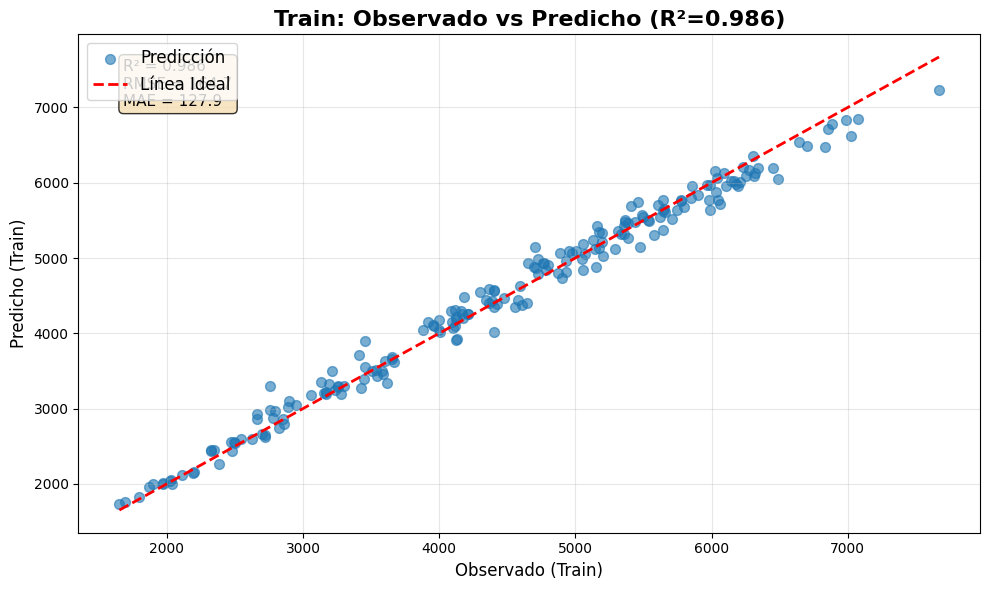

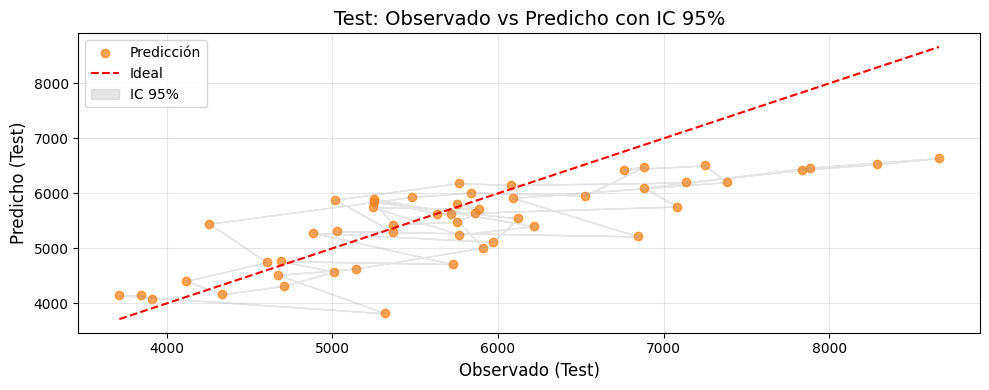

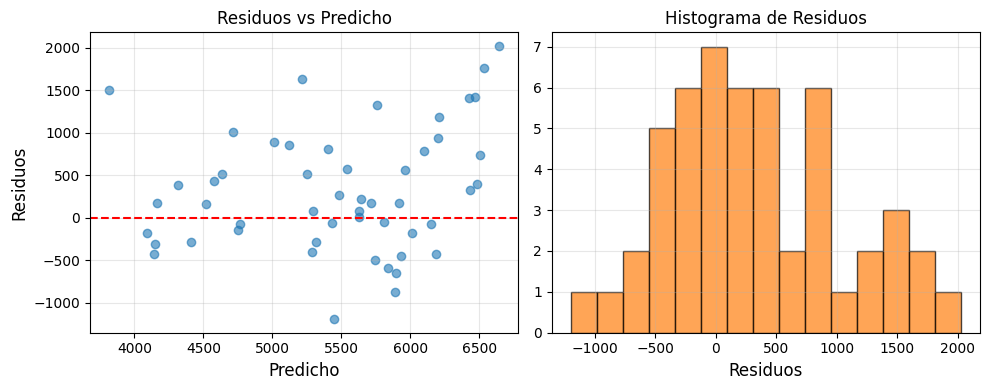

In [ ]:
#### 7.2 Observado vs Predicho: Train y Test

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Dividir los datos en train y test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Entrenar el modelo final en los datos de entrenamiento
rf_final.fit(X_train, y_train)

# Predicciones
y_train_pred = rf_final.predict(X_train)
y_test_pred = rf_final.predict(X_test)

# Calcular métricas
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print("=== MÉTRICAS DEL MODELO RANDOM FOREST ===")
print(f"TRAIN - R²: {r2_train:.4f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
print(f"TEST  - R²: {r2_test:.4f}, RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}")

# Gráfico para datos de entrenamiento
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, y_train_pred, alpha=0.6, color='tab:blue', label='Predicción', s=50)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Línea Ideal', linewidth=2)
ax.set_title(f"Train: Observado vs Predicho (R²={r2_train:.3f})", fontsize=16, fontweight='bold')
ax.set_xlabel("Observado (Train)", fontsize=12)
ax.set_ylabel("Predicho (Train)", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Añadir texto con métricas
ax.text(0.05, 0.95, f'R² = {r2_train:.3f}\nRMSE = {rmse_train:.1f}\nMAE = {mae_train:.1f}', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

from sklearn.utils import resample

# Bootstrap para IC 95%
n_bootstraps = 500  # Menor para acelerar, puedes subirlo si quieres
preds_bootstrap = np.zeros((n_bootstraps, len(y_test)))

for i in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_test, y_test)
    rf_final.fit(X_train, y_train)
    preds_bootstrap[i] = rf_final.predict(X_test)

lower = np.percentile(preds_bootstrap, 2.5, axis=0)
upper = np.percentile(preds_bootstrap, 97.5, axis=0)

plt.figure(figsize=(10, 4))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='tab:orange', label="Predicción")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal")
plt.fill_between(y_test, lower, upper, color='gray', alpha=0.2, label="IC 95%")
plt.title("Test: Observado vs Predicho con IC 95%", fontsize=14)
plt.xlabel("Observado (Test)", fontsize=12)
plt.ylabel("Predicho (Test)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 7.3 Análisis de residuos

residuos = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(y_test_pred, residuos, alpha=0.6, color='tab:blue')
axes[0].axhline(0, color='r', linestyle='--')
axes[0].set_xlabel("Predicho", fontsize=12)
axes[0].set_ylabel("Residuos", fontsize=12)
axes[0].set_title("Residuos vs Predicho", fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuos, bins=15, edgecolor='k', color='tab:orange', alpha=0.7)
axes[1].set_xlabel("Residuos", fontsize=12)
axes[1].set_title("Histograma de Residuos", fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### Forecast

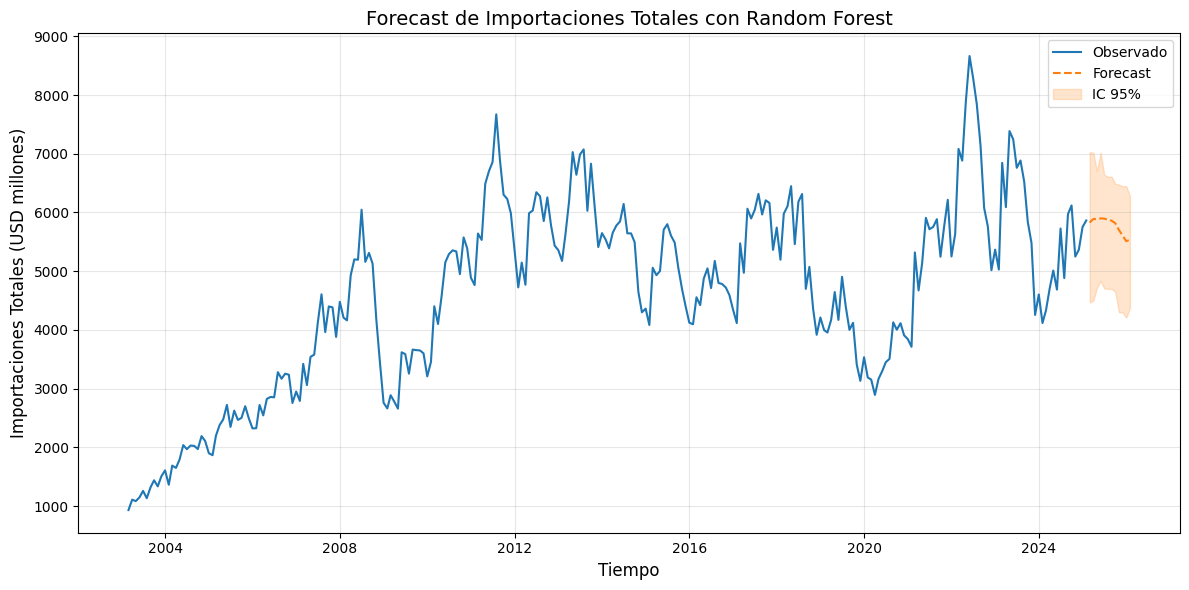

=== FORECAST DE IMPORTACIONES TOTALES ===
      Fecha  Forecast  IC_Inferior  IC_Superior
0   2025-03   5828.83      4467.40      7028.09
1   2025-04   5888.35      4499.52      7019.10
2   2025-05   5887.66      4714.13      6704.55
3   2025-06   5899.86      4834.66      7019.58
4   2025-07   5894.74      4704.88      6642.81
5   2025-08   5879.48      4699.57      6608.39
6   2025-09   5860.68      4699.57      6608.39
7   2025-10   5818.39      4650.99      6488.76
8   2025-11   5702.99      4300.42      6476.71
9   2025-12   5608.61      4300.42      6448.00
10  2026-01   5511.94      4208.87      6448.00
11  2026-02   5532.55      4371.10      6281.46


In [ ]:
## 8. Forecast con Random Forest e Intervalos de Confianza

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir rf_final como el mejor modelo encontrado en el grid search
rf_final = gsearch_rf.best_estimator_

n_forecast = 12
cols = X.columns

# Obtener los últimos valores de df_feat (que contiene todas las features)
# Necesitamos los últimos valores para construir las features del forecast
last_row = df_feat.iloc[-1:].copy()

future_preds = []
lower_ci = []
upper_ci = []

# Obtener los árboles individuales del Random Forest
trees = rf_final.estimators_

# Para almacenar las predicciones y poder actualizar las features
forecast_history = df_feat['importaciones_total'].values[-6:].tolist()  # Últimos 6 lags
dev_history = df_feat['tasa_devaluacion'].values[-3:].tolist()  # Últimos 3 lags

for i in range(n_forecast):
    # Construir las features usando los nombres reales del dataset
    current_features = {}
    
    # Lags de importaciones (imp_lag1 a imp_lag6)
    for lag in range(1, 7):
        current_features[f'imp_lag{lag}'] = forecast_history[-lag]
    
    # Lags de tasa_devaluacion (dev_lag1 a dev_lag3)
    for lag in range(1, 4):
        if lag <= len(dev_history):
            current_features[f'dev_lag{lag}'] = dev_history[-lag]
        else:
            current_features[f'dev_lag{lag}'] = dev_history[-1]  # Usar el último valor disponible
    
    # Variables adicionales del último período conocido
    current_month = (last_row.index[0].month + i - 1) % 12 + 1
    current_features['month'] = current_month
    current_features['quarter'] = (current_month - 1) // 3 + 1
    
    # Medias móviles y desviaciones estándar - usar valores aproximados del último período
    # Para simplificar, usamos los valores del último período conocido
    for col in ['imp_ma3', 'imp_std3', 'imp_ma6', 'imp_std6', 'dev_ma3']:
        if col in last_row.columns:
            current_features[col] = last_row[col].iloc[0]
    
    # Variable actual de tasa_devaluacion (asumimos que se mantiene constante)
    current_features['tasa_devaluacion'] = dev_history[-1]
    
    # Crear DataFrame con las features en el orden correcto
    X_next = pd.DataFrame([current_features], columns=cols)
    
    # Obtener predicciones de todos los árboles
    tree_preds = np.array([tree.predict(X_next)[0] for tree in trees])
    
    # Predicción promedio (la predicción del Random Forest)
    y_next = np.mean(tree_preds)
    
    # Calcular el intervalo de confianza del 95% (percentiles 2.5 y 97.5)
    ci_lower = np.percentile(tree_preds, 2.5)
    ci_upper = np.percentile(tree_preds, 97.5)
    
    future_preds.append(y_next)
    lower_ci.append(ci_lower)
    upper_ci.append(ci_upper)
    
    # Actualizar el historial para el siguiente paso
    forecast_history.append(y_next)
    # Mantener solo los últimos 6 valores para los lags
    if len(forecast_history) > 6:
        forecast_history.pop(0)

# Convertir a arrays para graficar
future_preds = np.array(future_preds)
lower_ci = np.array(lower_ci)
upper_ci = np.array(upper_ci)

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df_merged.index, df_merged['importaciones_total'], label="Observado", color='tab:blue')

# Crear un rango de fechas para el forecast
fechas_forecast = pd.date_range(df_merged.index[-1] + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')

# Graficar predicciones y el intervalo de confianza
plt.plot(fechas_forecast, future_preds, label="Forecast", linestyle='--', color='tab:orange')
plt.fill_between(fechas_forecast, lower_ci, upper_ci, color='tab:orange', alpha=0.2, label='IC 95%')

plt.xlabel("Tiempo", fontsize=12)
plt.ylabel("Importaciones Totales (USD millones)", fontsize=12)
plt.title("Forecast de Importaciones Totales con Random Forest", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar los valores predichos
print("=== FORECAST DE IMPORTACIONES TOTALES ===")
forecast_df = pd.DataFrame({
    'Fecha': fechas_forecast,
    'Forecast': future_preds,
    'IC_Inferior': lower_ci,
    'IC_Superior': upper_ci
})
forecast_df['Fecha'] = forecast_df['Fecha'].dt.strftime('%Y-%m')
print(forecast_df.round(2))
